In [1]:
%matplotlib inline
import json
import pandas as pd
from scipy.stats import ttest_1samp, ttest_rel
import numpy as np
from matplotlib import pyplot as plt
import datetime
from IPython import display
import base64
from base64 import b64decode
from statsmodels.stats.multitest import multipletests

### Intro
We're going to test the efficiency optimizing trading strategies with different window sizes using walk forward. method

### Basic objective

Similar to SignalToNoise ratio or SharpeRatio. For given set of trades $ T $ and profits $P = \{p_1, p_2, ... p_i\}$

$$ R(P) = \frac{\text{AVG}(P)}{\text{STD}(P)} $$

### Overfitting and robustness modifications

The ratio becomes unstable and the result becomes statistically insignificant when $|T|$ is low.
Let's measure the amount of trades with the following ratio:
$$\text{TradeNumCoeff(T)} = \frac{|T|}{|T| + 300}$$

Text(0, 0.5, 'SampleSizeCoeff')

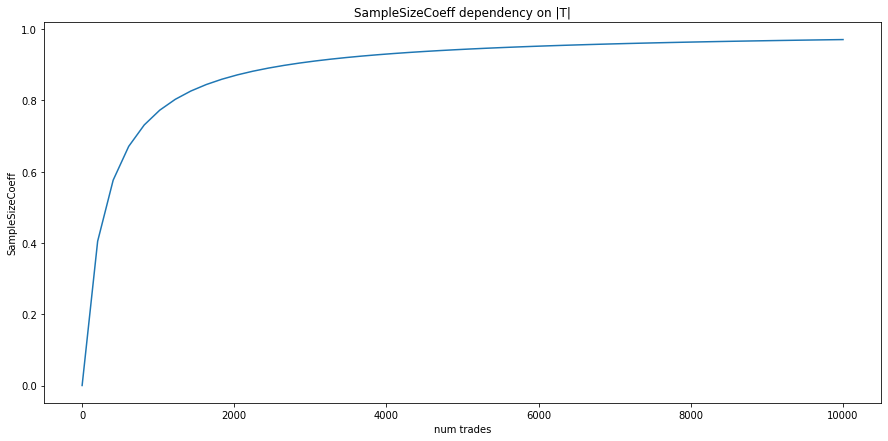

In [2]:
def tnc(t):
    return t/(t + 300)

x = np.linspace(0, 10000)
y = tnc(x)
plt.figure(figsize=(15,7))
plt.title('SampleSizeCoeff dependency on |T|')
plt.plot(x, y)
plt.xlabel('num trades')
plt.ylabel('SampleSizeCoeff')

The other type of overfitting of trading system is when it learns to do few trades that give large profits. In real price historical data there is always a few unpredictable large price flunctuations. We cannot predict such price movements, they create noise in the performance metrics and strategies tend to overfit to them.

Fortunately, there is a way to measure such effect.
Let's take the absolute values of profits $P_{\text{abs}} = \{|p_1|, |p_2|, ... |p_i|\}$ and take 1% of most valuable trades. Let's call it $P_\text{abs 1%}$

Then let's compute the following ratio:

$$\text{OverfittingScore}(P_\text{abs}) = \frac{\sum_{p_i \in P_\text{abs 1%}}{p_i}}{\sum_{p_i \in P_\text{abs}}{p_i}}$$

This is in some sense a measure of profit distribution skewness(?)
This value is large for the list of trades where few trades contribute to the overall metric more than the tail of distribution.

Example

In [3]:
import math

def os(x):
    Pabs = sorted(list(map(abs, x)), reverse=True)
    idx = math.ceil(len(Pabs) * 0.01)
    percent = Pabs[:idx]
    return sum(percent)/sum(Pabs)

demo_lists = [
    [1,2,3,2,1,2,3,2, -100],
    [1,2,3,2,1,2,3,2,1],
    [1,1,1,1,1,-2,1,-1,1,1,1]
]

for l in demo_lists:
    print(l, os(l))

[1, 2, 3, 2, 1, 2, 3, 2, -100] 0.8620689655172413
[1, 2, 3, 2, 1, 2, 3, 2, 1] 0.17647058823529413
[1, 1, 1, 1, 1, -2, 1, -1, 1, 1, 1] 0.16666666666666666


I assume large values of this ratio is a sign of overfitting.
Moreover, to increase robustness of the main performance metric we can compute it only on the distribution tail, which is the list of trades without $P_\text{abs 1%}$. Let's denote it as $P_\text{abs 99%}$

### The final stabilized and overfitting-resistant objective function and optimization task

Our strategy parameters is
$$ \theta = \begin{bmatrix} w_1, w_2, w_3, w_4, thr_{atr}, sl, b, t, n_1, n_2, n_3 \end{bmatrix} $$
The optimization task is

$$ \underset{\theta}{\arg\min} -R(P_\text{abs 99%}) \cdot \text{OverfittingScore(P)} \cdot \text{TradeNumCoeff(T)} $$

**The perfect strategy from the point of view of this objective is the one that**
1. Makes at least a few hundred of trades
2. The distribution of profits over trades is more or less uniform, no ultra large spikes
3. It has the largest Sharpe Ratio (avg over variance)

### Strategy

For two timeseries

$$ x = \{x_1, x_2, ..., x_{n-1}, x_n\} $$
$$ y = \{y_1, y_2, ..., y_{m-1}, y_m\} $$

$$\text{crossedAbove}(x, y) = (x_n \gt y_m) \land (x_{n-1} \leq y_{m-1})$$
$$\text{crossedBelow}(x, y) = (x_n \lt y_m) \land (x_{n-1} \geq y_{m-1})$$

### Factors



$$sma_1 = \text{Simple Moving Average, timeframe}=n_1$$
$$sma_2 = \text{Simple Moving Average, timeframe}=n_2$$
$$sma_3 = \text{Simple Moving Average, timeframe}=n_3$$\
$$\text{smaDiff} = \frac{sma_2 - sma_3}{sma_2}$$\
$$ \text{atr_relative} = \frac{\text{ATR}_{20}}{\text{close}} $$\
$$ \text{up} = [sma_2 \gt sma_3] $$
$$ \text{down} = [sma_2 \leq sma_3] $$
$$ ca = [\text{crossedAbove}(sma_1, sma_2)] $$
$$ cb =  -1 \cdot [\text{crossedBelow}(sma_2, sma_2)] $$

$$ f = \begin{bmatrix}
[\text{crossedAbove}(sma_1, sma_2)]\\
[sma_2 \gt sma_3] \cdot \text{smaDiff}\\
-1 \cdot [\text{crossedBelow}(sma_2, sma_2)]\\
[sma_2 \leq sma_3] \cdot \text{smaDiff}
\end{bmatrix} $$

$$ w = \begin{bmatrix}
w_1\\
w_2\\
w_3\\
w_4
\end{bmatrix} $$

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

$$ \text{score} = \sigma(w^Tf)$$

### Params

$$w_1, w_2, w_3, w_4 \in [1, 50] \cap \mathbb{R},\\
thr_{atr} \in [0.01, 0.15] \cap \mathbb{R},\\
sl \in [-15, 0] \cap \mathbb{R}, \\
b \in [0.85, 1] \cap \mathbb{R}, \\
t \in [2, 10] \cap \mathbb{R}, \\
n_1 \in [8, 21] \cap \mathbb{N}\\ 
n_2 \in [n_1 + 8, n_1 + 21] \cap \mathbb{N}\\
n_3 \in [n_2 + 8, n_2 + 21] \cap \mathbb{N}
$$

### Rules



**buy** when _score_ > 0.75 and _atr_relative_ < _atr_thr_

set stoploss at $\text{sl} \cdot \text{atr_relative} \cdot 100$%\
set take_profit at $t(b^{\text{tradeLengthMinutes}})$%



**sell** when score < 0.25 (or when stoploss/take profit is triggered)



### Trade optimizer

There was a few requirements to the optimization software:



1. Non-bruteforce optimisation(e.g. Baysesian)
2. The optimisation is done by iteratively sampling new parameters, running the strategy on the dataset and evaluating the objective, so performance and memory consumption of single backtesting iteration matters
3. As much parallelisation as we can do in order to use multiple cores/processors and even cluster of multiple machines


A distributed bayesian optimizer of strategies from scratch was implemented in Go language to satisfy this list of requirements


In order to satisfy this requirements optimisation and backtesting was implemented in Go language which offers massive parallelisation. The system uses mysql database as storage of common data between the machines.
This solution allows to optimize strategies using the cluster of multicore machines. 

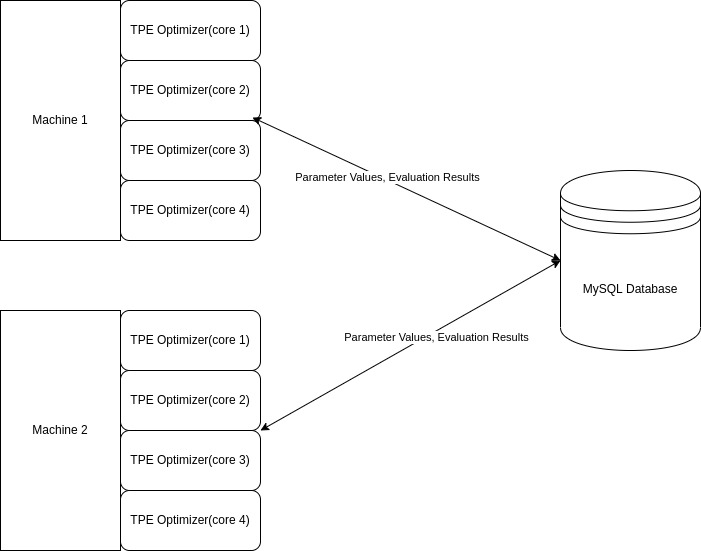

In [4]:

pic = """
/9j/4AAQSkZJRgABAQAAAQABAAD/4gIoSUNDX1BST0ZJTEUAAQEAAAIYAAAAAAQwAABtbnRyUkdCIFhZWiAAAAAAAAAAAAAAAABhY3NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAA9tYAAQAAAADTLQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAAHRyWFlaAAABZAAAABRnWFlaAAABeAAAABRiWFlaAAABjAAAABRyVFJDAAABoAAAAChnVFJDAAABoAAAAChiVFJDAAABoAAAACh3dHB0AAAByAAAABRjcHJ0AAAB3AAAADxtbHVjAAAAAAAAAAEAAAAMZW5VUwAAAFgAAAAcAHMAUgBHAEIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFhZWiAAAAAAAABvogAAOPUAAAOQWFlaIAAAAAAAAGKZAAC3hQAAGNpYWVogAAAAAAAAJKAAAA+EAAC2z3BhcmEAAAAAAAQAAAACZmYAAPKnAAANWQAAE9AAAApbAAAAAAAAAABYWVogAAAAAAAA9tYAAQAAAADTLW1sdWMAAAAAAAAAAQAAAAxlblVTAAAAIAAAABwARwBvAG8AZwBsAGUAIABJAG4AYwAuACAAMgAwADEANv/bAEMAAwICAgICAwICAgMDAwMEBgQEBAQECAYGBQYJCAoKCQgJCQoMDwwKCw4LCQkNEQ0ODxAQERAKDBITEhATDxAQEP/bAEMBAwMDBAMECAQECBALCQsQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEP/AABEIAicCvQMBIgACEQEDEQH/xAAdAAEBAAICAwEAAAAAAAAAAAAABwYIBAUBAwkC/8QAZBAAAAYBAgMBCA0GCAgLBQkAAAECAwQFBgcRCBITIRQYIjE4WHe1FRYXIzJBUVdhlpfT1RlWgZWm1AkzNEJHUnHFJDVDYnKGkbElRVNjc4OTlKGisydEgrLBJjY3dHV2hLTR/8QAFAEBAAAAAAAAAAAAAAAAAAAAAP/EABQRAQAAAAAAAAAAAAAAAAAAAAD/2gAMAwEAAhEDEQA/ANs+GThk4bb/AIbdKL294fNNbGyscHopcyZLxOA8/JfcgMqcdccU0alrUozUajMzMzMzFL707hY82nSr6m133IcJ3ksaN+j/AB71cwKqAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5EZ4SNPJutvDhpleauJne1eBilVWUeJIlLZiPNRojbCps4mzLutTym1LbacM2kNKb8A3DUotuxKeE0iTwsaNkkiL/AOwGPH2f/pzADz3p3Cz8fDVpWZ/KeHVxmf6TZDvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5DvTuFjzadKvqbXfciqgAlXencLHm06VfU2u+5H4d4T+GskH7E6IYfj8nbwJ+PVbVPOZP+s3Khk082ZfEaVkYrAAJbptd5Ni+cWeiuaXUm8ch1yLvHLuUSSkzqw3Oi4xI5SIlyIznTJTpEXURIZUfh9QzqQlWR9nFPp7t8en+Y7/TtY45t/vP/AGiqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8AHvVzAqolXCd5LGjfo/x71cwKqAAAAAAAAAAAAAAAAAAAAACVcJ3ksaN+j/HvVzAqolXCd5LGjfo/x71cwAqoDX7iUweDMyLALlnKM6rH77Ma2ksG6jN7mtjvQ1MyDUgmIsptpBmaEma0pJZ7fCGAZmeMVOtmaYPe3WusuNRYhj/tcjYnbZVOWy+4qxJxbzkRxbSnlm2x75OUZK5O0zSSwG4ADSuoRqdf6iP0equH6v5he1Wn2HvWkXB89OiiwLV5uaU5TjSbaC24p1xotlIS4XvXjSW3Nbtb7u+w3RvHqrF7K3xpy4uMdxd2ymS+7J9TFmTGIzri5Dq3ickkhZtk8tbnvqyWaln2mFmAaqawXGQcK85Nxp9l2Q3seww7KrORTZXdzLppMqrrzlsTErkOqfbR1Eky42hxLaikI2JKiIx51N1f12qZLeDoyHEoFzJnYLZxbKDTSVstxLO/RBkQ3WlS93NjJB9VK0dVtbqCQ0rZxIbVANT4OuWriVWlJiXtZZcht6kXT0i4Zn2HN7DZB3KwyglSyUhLiHj3Il8jexE2hKEpbHKna8ajSZNNVZLFpN7ZzT2/iexZzYhxY9xcrjPRHVpkbyDbJkjJfgNu85pcYNO6VBtMA1kyHXvV/DHNT8jkyMTyrFMDiN17L9bjs2E67kD8hpCIhKKXJN9uOh1HXNttKjW4SEFzIWkvS3r/AK3TbKlw6tqK1qfc5bEo4+RXWDXVNBfiv1NjLcU3AmOtvKeYdgEStnjQtDiS3bUvdAbQgNbqzU/Ppts5LoLSKVvn+o9vhVOds2/JraWFSszidcKI2611HHXK2UrscQpRyEcyzQylJe3KdZ9bqZGXRI0fA2rHTPDWcqyFKmZchi3cccn8seIvqtnEI261ZqccS/yLeJHKsmzUoNjAGr93xMajQoOaZPEraYqauy2ow6hjIo582b1p0aukHLkIjuqW8lpE10ijstkt1SUJJbfjOs6H5/lefUdy7l9FLhSqe4cro817Hp9I3bR+gy8iUzDnl12k7vKZMlKUXUYcNKjSZAKOA11wqhzWyreIDBk6oZRMtarJ2UUtzLnn14UhWP1MxHTSgktoYKU6tZx0pJpSVrQpJpUojsOlWae6Rpfh+ohxije2mgr7rolvs33THQ9ylv8AJz7foAYnkflT6eej/MvWOOCqiVZH5U+nno/zL1jjgqoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACVcJ3ksaN+j/HvVzAqolXCd5LGjfo/x71cwKqAAAAAAAAAAAAAAAAAAAAACVcJ3ksaN+j/HvVzAqolXCd5LGjfo/wAe9XMAM9yLEceytdS5f1/dSqOyat4B9VaOjLbSpKHPAUXNsTiy5VbpPftLxBBxHHq3KbbNIVf07m9iw4c+T1Vn1mYpvGwnkNXInlOQ92pIjPn7TPYtu4ABO8q0E06zDK5Wb2KsrgXU6JHhSpNHmdzTFIZYNw2UuNwZTSF8hvO7GpJmXOfaMjm4DidrhK9Or2sXdUD0MoD8a3lPT1yGSIiLqvPqW66rsI+dajXuRHvv2jIQARXL+GTDj0z1CxzT+C8jJsvxCzxmLa5BeT7NxhEiOtDbPXlOPusxycUhSkNeD4JHymZEO7jcN+krdDY0UjH5zqbgq3ut9V7YKko7geJ+EmPIN7rRW2Ht3GkMKbS2ozNJFuYp4AMFgaIaYVjj7sPGlJckxrqG8pU+Ss1tW0tMuwSZqcPtdfSle/jTtsg0p7B5kaJaYSpUGY/jPM9WxqaJFV3bILptVUlUmAnYnNj6Ty1L3Pc177L5i7BnIAJjjvDbpHi9VZY/WVN49TW8eXGmVVhlNrPgOIkuG4+ZRZMlbKVqcUpXUSglkalGRlzHv2dPojpxSP18yPV2UuXV2xXcWXZXk+wkpmFFeiJWp6S8txaUsSHkJbUo0J5zMkkexlnYAJNX6EVb68px3KWW5uM2GSqy2hch2EmFY1c+QSlSyQ8wbbjR9ZTziXW3SUaZbraiIk7ucydw2aLWEGDWP4etuJBgHVmzHtJjCJsM3VOqYmk26nu1tTjjq1Ik9QlKddMyM3F700AGHz9I9PbOsyKomY8S4uVWbV1aEmU8hbk5puO21IbWlZKYcQUSMaFNGg0qaStOyt1H2WIYTj2DVTtPjrM1LMh9cp92ZYyZ0l95RERuOSJDi3nFbJSkjUszIkpItiIiLvgARt/h2qMOpculaO2F7AyrLYi4j8++zK6tI5OONtMHNWzKkPIdfaYZbJtRpJRkyhrqNoMzKn4pjVVhmL0+H0TRtVtFAj1sNtR7mhhltLbZGf0JSQ7UAEqyPyp9PPR/mXrHHBVRKsj8qfTz0f5l6xxwVUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABKuE7yWNG/R/j3q5gVUSrhO8ljRv0f496uYFVAAAAAAAAAAAAAAAAAAAAABFuCzJKnKuEnSGypZSJDEfDqutcUk9+V+JHRGeQf0pdZWk/wCwWkaOaBz8vw/TTSuDw0Q/Z69ssGxmbmeOS2yRRxFuVUfkluS+dBwpbqCQZoaTIU6kkuKYLfrGG8YCUpyTioNJGrRvSrfbt/8AaVYl/cR/7x59sfFP8zelX2l2P4EAqoCVe2Pin+ZvSr7S7H8CD2x8U/zN6VfaXY/gQCqgJV7Y+Kf5m9KvtLsfwIPbHxT/ADN6VfaXY/gQCqgJV7Y+Kf5m9KvtLsfwIPbHxT/M3pV9pdj+BAKqAlXtj4p/mb0q+0ux/Ag9sfFP8zelX2l2P4EAqoCVe2Pin+ZvSr7S7H8CD2x8U/zN6VfaXY/gQCqgJV7Y+Kf5m9KvtLsfwIPbHxT/ADN6VfaXY/gQCqgJV7Y+Kf5m9KvtLsfwIdHmWW8YsOiffxzRjTc5iS8E4eZybR4i+M0RpEGA24r5EqlNkZ9nMXjAdzZuos+KvGmYaicVjen16diRHv0fZGxqu5d/k5/YuZt8vSP5BWBLOHyPiUjGbLJKa8s7vILWwV7aZ9xG7msk2TaEpVFfY2LuZLKTSlthJciUGlSTXzm4upgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8e9XMCqiVcJ3ksaN+j/HvVzAqoAAAAAAAAAAAAAAAAAAAAAIVwN4XT4PwmaWw6htX/CuMV11JdWfM46/LjtvKNSj7T5SWltPyIbQktiSRFdRKuE7yWNG/R/j3q5gBVQAAAAAAAAAAAAAAAAAAAAAAAAABJXY7eO8U8Aq0uk3nODWUu0bT2JckVM2vajumXi5zbtnUGrxmltsj3JCdq0JVkflT6eej/MvWOOCqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8e9XMCqiVcJ3ksaN+j/HvVzAqoAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8e9XMCqiVcJ3ksaN+j/AB71cwA/eqOuU7S+8q6h7RfOshYupzFXX2NQ/TFHfmPJWpLBFKnsupPZtW6lNkjs+EY4E/iInRMhn4vD0F1Hs7Klp4NzcswlUq1Vrcvr9NpZKsUm86Xcz26Y5Ol2ERGozIh3WsuI5DlcnT5ygr+6k0eawLeefVQjoxG2n0rc8NRc2xuILlTuo9+wvGMPtdFc6ybXTO8qb1Dy3DMdusfoa5pyhcq97JxhVh10LORGffZNsn2+VbZtGfVMyNRp3SHZRuJevyO3RWaY6U5tnzCqGqyTu+lcqI8codil1UQ/8PnRlmpSWHDMiQfL2bnuewznKdSaXBdP/dBzWBY07CWYxuVq2kSZyZUhSG2oSUR1uIdkKecQ0SWlrSpZlyqMvCGvF3ok/hurFo5TaMaqXOHtYljlBQKwXPEUaI6IHdiFsyEey8Fx00odY5FLS5/P2Mt1b1nVLCsoz3SWh9qtJIr8ix2ypckr6jIJ6XHFvQJLT5w5Ultx9JuLQhbZvE46RLUSzUrYzMOTR8QOOv3D1Bn2KZFpvMRVybxn22FDYYkwI3Kcl9EiPIeYSTRLQpxC1oWhKuY0kkjMudkPELoljNA9k9jqli66yLbwqOTIj20d1EeZKeS0226aV7IMuY1q5tuVtDiz8FJmUI4lq7UbVDTzLs3yfTWfgtLgunmYPIatLGFJmWM6VUusEltMN55CI6GzeUalrJalG34BEkzHtyXTbVTLJkjOqzSaVUpqI2ARY1Gixr+vbFTX5WElUdSX+iltLBmljrraUo1LJSWy23C9e7fpbEr12WSZzjuOtFNsIaPZW8gt9XuOWqK84lSXlJ5eoktyMyWjnSlxLbm6C5UjVvADbdVS5RT3jkW3g0kxmut4alw5Mp9LLaXud5JJVzK36e5uK2MkIWrZJwGj0L1E9lriwtcMSlMul1RjRydlxVqJ25yBuVAR2OHsbsYlKM/EntSs0mex+ZuhWo6LbE11uJIbiVdHplBkk3LjJS05T3T8iajbn7SZYcJRGW5K5tkcx7kAvlJrPo9ktpOpMc1Yw21sauM9MnQ4N7Fffix2lEl111CFmpCEKUklKUREk1ERmW4e7Po97XEZj7q+HewLkhyIi09nYvcan0NLdW0T3PyGtLTbjhp33JKFKMtiMxr1c6dav6u41qmeXaWZFjuZZbFOJVzZlhTu18SpiSkrjVTKmpT6yVISS3HVuR+mpx5RL3Q22kc2k0Tzm2zzGM9u6DMpDjed19ta+2ybQm+3Gh0lpHalJZqkIYIyflx2yMlOOqJDZmSEtgLqvWHAosjKV3F5Gp6nD5MeDZ3dnJZi1yZbraXDYS84st1oS4zzGZEnd5KSUpRLSjmWGqml9SimctdSMWhIyNKVUypFxHbKyJXLynHNSy6xHzJ25N9+YvlIa/UGOZSsmrCmxt/IrXTfWfJbu6omX2GZUuNPRYKhuNHIW20bjce0hOoJxaEmlCtlEokj05PpZqU/BzlNZoTXpRqbgCMWjVkCxgJjY3KKRZrV3Ua1NkbTnsi084qKl5XVadIkr97WoNipWp2m0Gfa1U7ULGo82iYVKtYzttHQ7AZTyGpx9Jr3aQXVb3UoiIuon+sW/ZUWU4zlFI3k2MZDW3NQ8lS2p9dKRJjuEkzJRpcbM0q2MjI9j8ZGQ1pv+H7UZ/ENQY0BuWVrM1HocniSIr0Luu4g18KpQpSDkk4wl3qxZCm0SU8nUbSauVK+cVTQrEL3C8cyq4ua/LFWmR3j927FyCXUuTnXO5WGCPlrkNw2TX3OR8iVKI1Ga1r5lqJIddH4osY7knTrjT7OaVqLRKymMVhXx0uT6Vt1tuRNaaQ+pxKWSebcWy8luRyKLlaUoySdjjyGJcdqVFfbeZeQlxtxtRKStJluSiMuwyMu0jGt2FXGUVlTmuqfEHpJlNDcuY3Lfs7GzmU71VX17RGv2KhIiTnnjT4SlKdW0k3lINSzRsy0it6D0d5jGh2neNZMhxNxU4pUQbBLnwiktQ2kOkf086VbgOkyPyp9PPR/mXrHHBVRKsj8qfTz0f5l6xxwVUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABKuE7yWNG/R/j3q5gVUSrhO8ljRv0f496uYFVAAAAAAAAAAAAAAAAAAAAABKuE7yWNG/R/j3q5gVUSrhO8ljRv0f496uYAVUAAAAAAcW1qqu9q5lJd1sWwrrCO5FmQ5TKXWJDDiTSttxCiNK0KSZkaTIyMjMjHJSlKEkhCSSlJbERFsRF8g8gAAAAAAADiM1FVGs5V1HrIjVhNaaZlS0MpS8+20azbQtZFzKSg3HOUjMyLnVttuY5YAAAAAOJaVFVeRPY+6rIlhF6rT3QlMpdb6jbiXG18qiMuZK0JWk/GSkkZbGRDlgACVZH5U+nno/zL1jjgqolWR+VPp56P8AMvWOOCqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8e9XMCqiVcJ3ksaN+j/AB71cwKqAAAANcMb4oMhdrdZ/bNRVvspgdpNbxmLES4graL3XIgwW1861cz65kVxpRpNKffWvBTzdvYY5xQS6/R3F9R9QMCvphycXZyTJbTHq9KampZPcnXDVJfStaU8q1m00bzqUJ5lJ2NJq5qOFysVmGP5bKy15fsNk91kEqKiGSG7FqbOKexGc8M9u5pbUZ5DnbubSi5U9Q9sGyjgXbynDW8Hsc/qpcL2ks4f17LFkTZEBbXdJ921xuSOSG44chJO+A4tRMNklaDIlEFgm64V3tps8WpsMyiyZqZqqiZfRYTb1ZEse5SkFHd5Xe6CIkLbJTpNGylSySpxKtyKaY3xdu2ukVXlGRYla49kM/CIGXtPv1bT1fYNLVFbkuRGUzCe6aHZTZEl9bS+VxCi5y7Tzam0Yz2lvrOTC1WixqTIrEry7ro2Pkl2RYKhtsPJZfXIX0Yji2kvGyaFukZqST5JMY9bcKHspheJ4h7fel7WNO/aF3R7Fc3dHv1a53Xy9YuT/Fu3T3P+O35/A2UGS1PEriFnfMVL+MZLW18rIrnFGbuazGRAXZVvdapDW6X1Okk24MhxDht8hknlNSV7oLtNOddMf1HtINVGxnI6Nd1TnkNE5bx2G029YlbSFSWCbdcUgknIjGpDyWnSJ9vdBbnt0R8OUN+spaiwybumLV57kGavo7h5e6W7RNolUPfqeByFan77283R+Ann8Hj6EcM9RojYNSobWEuFBqU0sOVUYTGqrJ9klIM3J0xC1qkumTSOY0Ey2pXMo2zPl5A7+Xn2eQeIim01mVdG1il3jNxbRJCHHXLByRBerEGpXwW2mz9kXE8my1GbRK5kkfIKcJPkemGqdvrfQ6qVupGKw6nH4M2pj07+JSX5LkKa7AclkuWVihPVNVejprJgkoJwyUh0yIxWAAAAAGqnBZqqjE9BdLdOdYLKLTWsvFquTjdhKUTEK7gPRG3mWo7i9knJYbWTLjG/P711EkaFkZbVjUDhT0wc134btMrXWqHJexWuxeprqPD1PKbhuoixW2DnTkoMu6lvLbU4204ZtNtKbPkNw1KINviMlESkmRkZbkZfGPIlJcJ3CwRbd7VpWf0nh1cZ/wC3ojz3p3Cx5tOlX1NrvuQFVASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuQFVASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuQFVASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuQFVASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuQFVASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuQFVASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuQFVE31918wbhvwP3R9RGLhdKmY1DdXWQjlLZU4SuVa0kZcqN0knmM9uZaC/nEOF3p3Cx5tOlX1NrvuR11/wZ8KGR1Mmml8POBQ2JbamnHKqjYrpHKotjJL8ZLbiew/iUQCLcNnGDgPFXxN2VzhGKZoutosbXS1c1+pSmJFS86mRMelPJcMmjeVGiNtN7GZ9zrUZlzcqdzxpLw68IGK6BZflujFJleSUtw8+5l2KZXUzCZlPVThoYXAlsqSqPLVFdQ2pXWaWhRS21JSg+Yivicu1x013b1BxBnPqNv/j7EY5t2LSN/HIqlqUa9i23VFdcUo9zJhBdgCvAMbwbUfBdSq520wfJ4Vs1GX0pTbSzS/Ed/wCTfZUROMOdh+A4lKvoGSAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlXCd5LGjfo/wAe9XMCqiVcJ3ksaN+j/HvVzAqoAAAAAAAAAAAAAAAAAAAAAJTwmkRcLGjmxbb4Bjx/pOuYFWEq4TvJY0b9H+PermAFVAAAAAAAAAAAAAAAAAAAAAAAAAAEqyPs4p9Pdvj0/wAx3+naxxzb/ef+0VUSrI/Kn089H+ZesccFVAYNnOi+AZ9YtZDY1r9bkcZHTi5DTSVwLRhPZ4JSWTJa2+wt2l8zavEpJl2DGkva/wCmCSKY0xq1j7RdrzCWK3I2UF8am/AhzT2IzM0HFPtIiQoxXgAYZgmr+n+oz8isx285LmCklT6SwYXCtIXxbvRHiS6hO+5Evl5FbHyqUXaMzGJ57pVp/qdHjtZrjMee/BUbkGchS486A4ZGXUjSmjS9HXsZlzNrSfb4xh3tf120z8PEshZ1MoW/+KcieRDuWU/IxYIT0pG2/YiQ2lR7eE+Z9oCugJ5h+uuB5Xdow+a7OxfLVJUv2t5HH7hsFknbmUylRm3KQW5buR1utluRc2/YKGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlXCd5LGjfo/x71cwKqJVwneSxo36P8e9XMCqgAAAAAAAAAAAAAAAAAAAAAlXCd5LGjfo/x71cwKqJVwneSxo36P8AHvVzADE+JTB4MzIsAuWcozqsfvsxraSwbqM3ua2O9DUzINSCYiym2kGZoSZrSklnt8IYBmZ4xU62Zpg97da6y41FiGP+1yNidtlU5bL7irEnFvORHFtKeWbbHvk5Rkrk7TNJLG1GRYjj2VrqXL+v7qVR2TVvAPqrR0ZbaVJQ54Ci5ticWXKrdJ79peIIOI49W5TbZpCr+nc3sWHDnyeqs+szFN42E8hq5E8pyHu1JEZ8/aZ7FsGodQjU6/1Efo9VcP1fzC9qtPsPetIuD56dFFgWrzc0pynGk20FtxTrjRbKQlwvevGktua3a33d9hujePVWL2VvjTlxcY7i7tlMl92T6mLMmMRnXFyHVvE5JJCzbJ5a3PfVks1LPtPIsq0E06zDK5Wb2KsrgXU6JHhSpNHmdzTFIZYNw2UuNwZTSF8hvO7GpJmXOfaMjm4DidrhK9Or2sXdUD0MoD8a3lPT1yGSIiLqvPqW66rsI+dajXuRHvv2gNddYLjIOFecm40+y7Ib2PYYdlVnIpsru5l00mVV15y2JiVyHVPto6iSZcbQ4ltRSEbElREY86m6v67VMlvB0ZDiUC5kzsFs4tlBppK2W4lnfogyIbrSpe7mxkg+qlaOq2t1BIaVs4mgZfwyYcemeoWOafwXkZNl+IWeMxbXILyfZuMIkR1obZ68px91mOTikKUhrwfBI+UzIh3cbhv0lbobGikY/OdTcFW91vqvbBUlHcDxPwkx5BvdaK2w9u40hhTaW1GZpItzAR6Drlq4lVpSYl7WWXIbepF09IuGZ9hzew2QdysMoJUslIS4h49yJfI3sRNoShKWxyp2vGo0mTTVWSxaTe2c09v4nsWc2IcWPcXK4z0R1aZG8g2yZIyX4DbvOaXGDTulVsgaIaYVjj7sPGlJckxrqG8pU+Ss1tW0tMuwSZqcPtdfSle/jTtsg0p7B5kaJaYSpUGY/jPM9WxqaJFV3bILptVUlUmAnYnNj6Ty1L3Pc177L5i7AEdyHXvV/DHNT8jkyMTyrFMDiN17L9bjs2E67kD8hpCIhKKXJN9uOh1HXNttKjW4SEFzIWkvS3r/AK3TbKlw6tqK1qfc5bEo4+RXWDXVNBfiv1NjLcU3AmOtvKeYdgEStnjQtDiS3bUvdFTx3ht0jxeqssfrKm8eprePLjTKqwym1nwHESXDcfMosmStlK1OKUrqJQSyNSjIy5j37On0R04pH6+ZHq7KXLq7YruLLsryfYSUzCivRErU9JeW4tKWJDyEtqUaE85mSSPYyCU1mp+fTbZyXQWkUrfP9R7fCqc7Zt+TW0sKlZnE64URt1rqOOuVspXY4hSjkI5lmhlKS9uU6z63UyMuiRo+BtWOmeGs5VkKVMy5DFu445P5Y8RfVbOIRt1qzU44l/kW8SOVZNmpWZ1+hFW+vKcdyllubjNhkqstoXIdhJhWNXPkEpUskPMG240fWU84l1t0lGmW62oiJO7nMncNmi1hBg1j+HrbiQYB1Zsx7SYwibDN1TqmJpNup7tbU446tSJPUJSnXTMjNxe4Sy74mNRoUHNMniVtMVNXZbUYdQxkUc+bN606NXSDlyER3VLeS0ia6RR2WyW6pKEktvxnVNGtQcrzzGb9/L6uTVyqa0er49m/js6kZso/c7LyJjUOwLrNII3lNKJalFzsOGSjSZDvJ+kentnWZFUTMeJcXKrNq6tCTKeQtyc03HbakNrSslMOIKJGNCmjQaVNJWnZW6j7DFcExjDKWRQUkSSuJMdcflKsJ0iwflOLIkqU8/JW466ZpSlPhqPwUkkuwiIBrbX0GaQ8/wAg0zq8/wBQ6xc/BZVhV219kKpx31tGkxlJt4JNvOtRmGlOtpdi+8ocTJQk4/TIzPYnSrNPdI0vw/UQ4xRvbTQV910S32b7pjoe5S3+Tn2/QMIlcPOOYhjN21o1ATU5JYUy8frZ9rcT5rNNCdUkloiNvOOkw02RJcTHZJtta2WkmaCIlJpeKY1VYZi9Ph9E0bVbRQI9bDbUe5oYZbS22Rn9CUkAn+R+VPp56P8AMvWOOCqiVZH5U+nno/zL1jjgqoAAAAAAAOjzHB8O1Bpl4/nGMVt5XLUTnc86Ol1KHC+C4jmLdC0n2pWnZST7SMjE+9zrVfTf37SPOfbBUN9pYvmcp18kpL+ZFtCJclnsIiLrplF8nKK6ACXUfEDjBWsbFtSqez06yKU50Y8LIUobjTXO3siTkKVFkme25IS4TpEZGptBnsKiOFdUlLklVJosiqIVpWzUdKTDmx0PsPI/qrbWRpUX0GQl56L5TgP+EaD589SRUdvtXvics6RRf1WeZZSIXx7Ey70k779FW2wCugJJG18TirrVZrviErT2UtSW02rj5TcekLPsLp2SEpSzue5EmUiOs9uxJ+MVePIjy47UqK+28w8hLjbjaiUhaDLclJMuwyMu0jIB7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEq4TvJY0b9H+PermBVRKuE7yWNG/R/j3q5gVUAAAAAAAAAAAAAAAAAAAAAEq4TvJY0b9H+PermBVRF+C7I6jKOEvSKxpJiJMePh9XWrWg9yJ+JHRGeT/al1lZbfQAtAAAAAAAAAAAAAAAAAAAAAAAAAAAlWR+VPp56P8y9Y44KqJPZuos+KvGmYaicVjen16diRHv0fZGxqu5d/k5/YuZt8vSP5BWAAAAAABIcE4kqLNU4nMmYBluMVWcsLex+0ufY/uaaaYrkvk/waW840o47LzpdVCC2bUW+/YYV4BiDOsWkcmieymPqniDtLGfKK9YovIqorb3Jz9NTpL5CXyeFyme+3b4h7/dS0yKysKU9RcY9kKmKudYRPZeP1okZCCWt51HPzNtpSpKjUoiIiMjM9jAZQAxODq3pTaTmKys1NxOXMlSjhMR2LqM467I5SV0UpSszUvlUk+Ui32Mj27R1+Ta66QYnVZBbW2o+OmjFkc9uyxZsOPwz6hNElxsl8yFG4ZIIlbeEZF4wGcPsMymXI0llDrLqTQ42tJKStJlsZGR9hkZfEJRK0AYxl9y00Ly+Zp1LWtTq6yOyUygkrPcz6tatRIb3M9zVFXHcVsW6zLsGbsak6dSrn2uRc+xx62KMUzuBu1YVI7nNsnOr0yVzcnIol8223KZHvse46291hwOowOVqXX3UfIMdgyGWZc2kksy246FPoaceUtK+Xpsk51HdjNSUIWZJUZEkwxj3ZctwD/B9dsBeqoiOw8ox3q2dMov6zySSUmF8W5utqaT/AMse24p1HfUWT1Ma+xq6gW1ZNR1I02DJQ+w8j+shxBmlRfSRjF8j1jwHEMvcxDKbyNUKjVTdtLsZ8liNBitvPqZjtOOuLTs68puQbaSIyMo7u5kZESpyvG9EbLU+Uen+Tz8CyF6DT3jl1jFhFjQL9Fk7MRHQbC+pFmvLKte3WthThIUg23O1XKF9AYtY6mab47Bjyb/UjHIbDsl6ubkzbaMyl6Uws232iM1JSbqHEqStBdqVEZGRGWw5bOfYJIylzBo+a0LuSMoNxynRZMqnIRykrmNgldQi5VJVvy+JRH8YDvgGIal6jxdNa2qmu4zc38m6tWKaDAqe5ifdkOpWpPbJeZaSkibVuZrL4vGPfi+cKvFtQchxayw+2lG8qHU3UyvXLmMtE31H2kxJL6VNpN1CVHzEaTMtyIlJMwygBi8TVPTCwta6igaj4vJsrdlMivhs3Edb8xpRKNLjLZL5nEmSFmRpIyMkn8hjh4bq/gWaYdBzaLexa6HNgQrFxixlMsvw2pZ7R+uklmTZuKI0p7dlKIySZgM0AYPkut2kuKQsllW2oeP9bEIEiyuYTNkw5LiMMkRrNbJK50nupKSIyLdS0l4zIfpvWbTJNbPvbLN8frKeFOZgIs5l3CTFkuOw2ZbZoWl4+XmakJMkOcizIuckm2ptxYZsAxp3UzTdi2iUL2oONN2c9TKYkJVswT8g3Ukpom2zXzLNaTI07EfMRkZb7jp851XPD8vpcFq9Pcnyu4u62fbNM0y69tLMaI7FadU4uZKYTvzzGSIkmoz8I+zYBnoDAabXPTOwxWBll3k8DFmJ82ZWFGyGYxBfbnRJC48qMZKc5VONvNLQfIpST2I0mpJkZ9vM1Q00r7mdjk/UPGY1tWRnJs6A9bx0SIsdDZOLddbNfMhCWzJZqURESTIzPbtAZOAw/LdV8Kw2RAiWdsy69OmQ4i2477KlRESieNmQ+SlkbbCu5ntl9u/TVtvyntwcW160bzCrxqzptS8bP23xmpVNFetGG5MxLhmlKUMmvnUvnJSDSRGZLSpJ9pGQDPgAAAAAAAAAAAAAAAAAAAAHFs7WrpIL1pc2UWBCjp5npMp5LTTaflUtRkRF/aYmbnE3pJMcVHwyztc5eSo07YhTS7lnmLxkqTGbVHb7ezdbqS37NwFWASktUdYbntxbhwuYyFfAeyjIK+tbX9PLFXLdSX+k2SvoDn4qLPt7m0pxvf4utY3fL+nkhc3+wgFWASn2l8RsztsdeMXi7+MqjBFM7f2d0T3x59yrVx/tlcT+WNH8fcVBRtl+jqw3AFVASr3HNR1dquK/VIj/AMysxci/8acw9x/UxHa1xV6krP8A5+pxlRf+WqSAqoCVe5prXG7YXEnZPmXi9kcXrHS/T0W2f/oPHtd4noHbE1Y06tUF/k52ETGHD/61qzNJf9kAqwCU+z3E9U9s3TXTzIGS8a67K5cF8/8ARZehLQf6Xy/SPB645DT9mc6Baj0yE/CkwIUa8YMvlSmueekGX9rKT+gBVwGAYtr5o5mVmmhpNQqkrlW21ROWqDY9vyxJBIfL9KBn4AAAAlXCd5LGjfo/x71cwKqJVwneSxo36P8AHvVzAqoAAAAAAAAAAAAAAAAAAAAANHNA5+X4fpppXB4aIfs9e2WDYzNzPHJbZIo4i3KqPyS3JfOg4Ut1BIM0NJkKdSSXFMFv1j3jEK4G8Lp8H4TNLYdQ2r/hXGK66kurPmcdflx23lGpR9p8pLS2n5ENoSWxJIiDv05JxUGkjVo3pVvt2/8AtKsS/uI/948+2Pin+ZvSr7S7H8CFVABKvbHxT/M3pV9pdj+BB7Y+Kf5m9KvtLsfwIVUAEq9sfFP8zelX2l2P4EHtj4p/mb0q+0ux/AhVQASr2x8U/wAzelX2l2P4EHtj4p/mb0q+0ux/AhVQASr2x8U/zN6VfaXY/gQe2Pin+ZvSr7S7H8CFVABKvbHxT/M3pV9pdj+BB7Y+Kf5m9KvtLsfwIVUAEq9sfFP8zelX2l2P4EHtj4p/mb0q+0ux/AhVQASr2x8U/wAzelX2l2P4EOjzLLeMWHRPv45oxpucxJeCcPM5No8RfGaI0iDAbcV8iVSmyM+zmLxi4gAlnD5HxKRjNlklNeWd3kFrYK9tM+4jdzWSbJtCUqivsbF3MllJpS2wkuRKDSpJr5zcXUxJXY7eO8U8Aq0uk3nODWUu0bT2JckVM2vajumXi5zbtnUGrxmltsj3JCdq0AAAAA18wfhc9puicDGotos9Q63EJFLX2024n2tdWWLsNTByIsWWtTTSOY9tm2Ubt7o2JJmkbBgA1eoOGzUdjNUZBbewDda5aYxaKjO5LY278dVUqXzpS9KYI3OcpDa0GXSSk0mnk8EnFcDPuGbWbLbSymNXGPPG/PypTT0rILBDbsO1hTY0ZPcSWDjxlxkyI6VGglqf5FrU4hW6V7YAAhFroDkUmwtplc/RsFOs8BlteG4lSWaOxZkSUns32GpptaWiLcjNWyjQRmYwaJwlZhDwyyxVJU0ifBpbCspLmbllxKVJU/LZeT1IbpHHgIWTCOr0UvbrJKkkkk8qtsAAa5U/DnlLOZz7q6h1UuPMvbHJmJi8ut1nDlS4jrfRbriSiIZtrfW2Ug+1TPYbRKVuVTwbTSJUaH0Gj+VxIUyNDxWLjdmwxucd9CYiY7yU7kkzQoiURbkR7H4iGdAA1jp+HjWOtx6slXOUVN9kyb9h+4cTczKvu6rh1jkCEhE5hlUhhzmNMtxKEkSnX5DZL5FeF1mD8L2q+Horpr1jis6dj6Mcbgt+yMtLc0q2yu3nDdcUwtbPPHtmeXseMnG1pMzLZxW14ANVJHC9qK+srmx9gbWbPPK2Z1W3llvUw2mra3cntGT0NtLklKUL6brLiEJXypMlp5e3MKrR7UDCc/byHD41JX49CefmyIaLqZJTaKKtXHZLuJ+O4UN/qdHmkMSDUtDayU2s3VbXsAEf1pwDNtW8Aw8q2rhxLmuua6+nVz+RTKnl5GXCdYbnw21vNrJTuxLQktySfaW4xjI9FtV7rT5iJjSqzFcypbR6TTzpWb22SJSzKiLhyTXKmx0vp5WnlOoZIlNm6w0Zmjc1FsOMOzzSPANR3Y0/JaMitoCTKBdQXnIdnB+P3iWyaXmy37TSSuVX84jLsARXIuGzUBvJYntNkUiMdoL3GbChjP306ImNXVbcRtUBcRlk2HFmbL7iZThuLLnQ1yJSklp4FXwz6s0WFJwyvmYlITY0GJ1thKenyUHGfqZa3Xuk2Uc+shxCiJKlKbNKtzNJkKYqLxAaZFvWyY+rGPtf+7TFs1uRMoL4kPESYcw+wiInExj8ZqdWYyTB9acCzuycxyFPk1OSx0dSTjt1GXAtGU/Gvud0iU432djrfO2fjJRl2gIHmnC5rHl7lyh+8x9R2MbM645b19YKS7HuWZKI7iYRM9zxVMEthK0Nko3fDcU7zFs5mNdozqvU6gS9WmYmIyreRev2RUr1xJTESzIoKmA4ZSiiGonUP1jnKfQ2Uy8e5oUo0lsKADWbFOFnK8VwmfizdzRyZL72ELak++tly00uO++nl5DNCfenCZSRq23SRmntMUPUjRRWpGqWO5bYXdpXVNPjN3UOKpr+dVTylTJFc40tC4q0c7aURHuZK1mnmNo+RW26asADVl/hczdqmxmL0aC0ep8ctcXmxkZRb0seamRLS6mwdXDTzvOvklS5MdfgqccMydPl5ldhkPDZnNhMu8exiVSY7jF1CsYcw0W0uamWUiodgtOFAkMqTFfStbSlPsyd3ENLJaVG6oy2WABryzolqpdZ/FzjJjxSATDuJmcWDYyZOzdWdmb/AIa47e5rOe2aC2IuxRGZbEaukxPh51exmnwOtgqxatscbp8foLO3h38xxE2HWPmfK7XuxDYk8zRrUgzNlxlbyiS6okJWe0IAAAAAAAAAAAAAAAAAA6HNs7xHTmgdyfNb2PVVzbiGSdd5lKdeWfK2002kjW66tWxJbQlS1GexEZietWWvOqhdekjI0oxtwz6cqyitTsilI3PZaIyjVGgkZbKSb3XXt2LZbPxenSGtRqtar4gcqQia3JfkM4PEdTu1VVKVm2mUhJ9ndMskm6p34RNLaaIyIl89mAS+q4btKI89m8ymmkZxdsK6iLTLpS7d5pzxc7KH92Yx7dmzDbae0+ztPenNttstpaabShCEklKUlsSSLxERfEQ/QAAAAAAAAAAAAAAAAAA6XK8Kw7O6tdJm+J02Q1y9+aJawWpbJ7+PdDiTT/4CfK0DfxQjkaJ6j32EuJ7U1cl1dxSLP4knCkrNTKPF4MV2P4vH2nvWwASSFrRd4VZR8d1+xuLi65brcaDk0CQp/H7B5auVDRurInITyj2Im5CSQajJLbrpitji2lXWXddJp7quiz4E1pTEmLKZS6y+2otlIWhRGlSTI9jIy2Ma8P6x4pwn3s3TXVDI5CMUdban4VKfUp55qIo1pfrlrUfM4UZaEGhajM+lIaQZmbZqMM84TvJY0b9H+PermBVRKuE7yWNG/R/j3q5gVUAAAAAAAAAAAAAAAAAAAAAEq4TvJY0b9H+PermBVRKuE7yWNG/R/j3q5gBVQEt1R1ynaX3lXUPaL51kLF1OYq6+xqH6Yo78x5K1JYIpU9l1J7Nq3UpskdnwjHAn8RE6JkM/F4eguo9nZUtPBublmEqlWqtbl9fptLJVik3nS7me3THJ0uwiI1GZEAsICNRuJevyO3RWaY6U5tnzCqGqyTu+lcqI8codil1UQ/8AD50ZZqUlhwzIkHy9m57nsM5ynUmlwXT/AN0HNYFjTsJZjG5WraRJnJlSFIbahJRHW4h2Qp5xDRJaWtKlmXKoy8IBlgCXUfEDjr9w9QZ9imRabzEVcm8Z9thQ2GJMCNynJfRIjyHmEk0S0KcQtaFoSrmNJJIzLnZDxC6JYzQPZPY6pYuusi28KjkyI9tHdRHmSnktNtumleyDLmNaubblbQ4s/BSZkFDAYJ7t+lsSvXZZJnOO460U2who9lbyC31e45aorziVJeUnl6iS3IzJaOdKXEtuboLlSNW8ANt1VLlFPeORbeDSTGa63hqXDkyn0stpe53kklXMrfp7m4rYyQhatkmGYgMNpNZ9HsltJ1JjmrGG2tjVxnpk6HBvYr78WO0okuuuoQs1IQhSkkpSiIkmoiMy3D3Z9Hva4jMfdXw72BckOREWns7F7jU+hpbq2ie5+Q1pabccNO+5JQpRlsRmAzIBhS9YcCiyMpXcXkanqcPkx4Nnd2clmLXJlutpcNhLziy3WhLjPMZkSd3kpJSlEtKOZYaqaX1KKZy11IxaEjI0pVTKkXEdsrIlcvKcc1LLrEfMnbk335i+UgGUgMZlanabQZ9rVTtQsajzaJhUq1jO20dDsBlPIanH0mvdpBdVvdSiIi6if6xb9pj2S45l1QxkGJ39bdVcrm6E6ulNyY7uxmk+VxszSrYyMj2PxkYDsgEpsuJHAq+/z+gZr7ywXppAh2V9IhxULZQw+t0nOkZrJTqo6WXFvJSkzIkmlHO4RtlUo8hiXHalRX23mXkJcbcbUSkrSZbkojLsMjLtIwEuyPyp9PPR/mXrHHBVRKsj8qfTz0f5l6xxwVUAAAAAAAAAAAAAAAAAAAAAAAAAAAAY5nGnODak1rdTnOMQbhhhfVjqfb2diu/E4w6nZxlwti2W2pKi+IxkYAJAeGa3abK6uneaN51Rt9vtfzGQpM5tPZ4Ma2QlS1dm+yZTbylGZbvIIh2+L674hcXUfDsqiWWEZZJPkZo8jaTGdlL+MojyVKjzC33/AJO44fZ2kQpA6nKMTxfN6WRjeY47XXdVLLlfhWEZD7Ln9qFkZbl8R+MgHbAJCWkuoWnhm/onqI8uuR2liuXvPWFft/UjzDM5kTx9m6n2kkREllJDkQOIGlp5rFDrHQTtN7Z9xLLLlu4hypmOGexJj2SPeFGZmRJbdNp4zP8AiwFWAeEqStJLQolJUW5GR7kZDyAAAAAAAAAAAAAAAAAAAAA1w4GNTI95w/ab4BkrKafK6nDKh1Fe8oiOdWHFb7lnRz/yzamjbJw079N3nQrYyI1bHjXjh9wPTvWHhC0VbyCvasSrMLpSgWEV9ceZWzGoLTLjkaU0pLsd1KkLQam1JPsMj7OwZW3i/EFgRcmJZxUahVTe/JX5ck4FihPxITYxG1IcIi7C6sU1nsXM6ZmagFcAScteLCj971H0W1Cxs0fDlQ6r2ehq/wA5C6xT7pI+l1psy7TMiLtHZUnEboNkEsq2v1cxZuxP/i+ZZNxJpf2x3jQ6X6UgKMA9bEhiUyiRFfbeacLmQ42olJUXykZdhj2AAAAAAAAAAAAAOpyDLcVxON3ZlOTVVNH236thNbjo2+XmWZEA7YBKl8UGiMlZs4vl7uYvEZpJvEKyXf7q+Q1QW3UJ+k1KIi+MyHrPUrWbKvesB0Lk1LK+wrLNrViva2/rojRTkyF/6DiWDM/jIu0BV3FoaQp11aUIQRqUpR7ERF4zMx8dv4YrUxOol3pnNxdg38RgFdw6+8QrZq0mJVD7r7nP/KsNl0Ek8XgKWbxJMyRuf0tXoVb50rra9Z/JzCIrY1Y1AjexmP8A0pdjJWt6Ynt7UyXnWz5SMm0mPn3/AA4MiojSNFMbrjjsuV0W9c7jZSSSYjrOAhrZJdiUn0XCLbs8A/kAfQ3hO8ljRv0f496uYFVEq4TvJY0b9H+PermBVQAAAAAAAAAAAAAAAAAAAAASrhO8ljRv0f496uYFVEq4TvJY0b9H+PermAHO1lxHIcrk6fOUFf3UmjzWBbzz6qEdGI20+lbnhqLm2NxBcqd1Hv2F4xh9rornWTa6Z3lTeoeW4Zjt1j9DXNOULlXvZOMKsOuhZyIz77Jtk+3yrbNoz6pmRqNO6buADUy70Sfw3Vi0cptGNVLnD2sSxygoFYLniKNEdEDuxC2ZCPZeC46aUOscilpc/n7GW6t6zqlhWUZ7pLQ+1WkkV+RY7ZUuSV9RkE9Lji3oElp84cqS24+k3FoQts3icdIlqJZqVsZnWgAai8S1dqNqhp5l2b5PprPwWlwXTzMHkNWljCkzLGdKqXWCS2mG88hEdDZvKNS1ktSjb8AiSZj25LptqplkyRnVZpNKqU1EbAIsajRY1/Xtipr8rCSqOpL/AEUtpYM0sddbSlGpZKS2W2+1drVVd7VzKS7rYthXWEdyLMhymUusSGHEmlbbiFEaVoUkzI0mRkZGZGOSlKUJJCEklKS2IiLYiL5AGqNHoXqJ7LXFha4YlKZdLqjGjk7LirUTtzkDcqAjscPY3YxKUZ+JPalZpM9j8zdCtR0W2JrrcSQ3Eq6PTKDJJuXGSlpynun5E1G3P2kyw4SiMtyVzbI5j3IbXAA1IudOtX9Xca1TPLtLMix3MstinEq5sywp3a+JUxJSVxqplTUp9ZKkJJbjq3I/TU48ol7obbSObSaJ5zbZ5jGe3dBmUhxvO6+2tfbZNoTfbjQ6S0jtSks1SEMEZPy47ZGSnHVEhszJCWxtUADVWgxzKVk1YU2Nv5Fa6b6z5Ld3VEy+wzKlxp6LBUNxo5C22jcbj2kJ1BOLQk0oVsolEkenJ9LNSn4OcprNCa9KNTcARi0asgWMBMbG5RSLNau6jWpsjac9kWnnFRUvK6rTpElfva1bSs1FVGs5V1HrIjVhNaaZlS0MpS8+20azbQtZFzKSg3HOUjMyLnVttuY5YDVW/wCH7UZ/ENQY0BuWVrM1HocniSIr0Luu4g18KpQpSDkk4wl3qxZCm0SU8nUbSauVK+cU3RjA8qx3EMyfflZLU3+W28m1Q/k66uZKYkKiMR0PrYrENxElvHSs2kKVzHzKUvmcUSa6ADVnEdMM80It8yyrUXJcYtcDq9OWIsudFonYb095mRZSZCnepPfUbyjkrddcUnZ5UkiTyqQvmtmg9HeYxodp3jWTIcTcVOKVEGwS58IpLUNpDpH9POlW4y+0qKq8iex91WRLCL1WnuhKZS631G3EuNr5VEZcyVoStJ+MlJIy2MiHLASrI/Kn089H+ZesccFVEqyPyp9PPR/mXrHHBVQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHHsK+BbQn6y0gx5kOSg2n48hpLjbqD7DSpKiMlEfyGOQACRe4PLwbeVoFmUjCko7Sx2S0qwx1z/ADUw1LSuIXYRF3I4yku0zQsx4PXedgplE18wqThqEHynkcNxVjjrn+euWlCXIZdhmfdTTSC3IicWYrw8GRKI0qIjI+wyP4wHHrrKuuILFpUz402FKQTrEiM6lxp1B+JSVpMyUR/KRjkiVWPD/R1c5+/0fvp2m9xIWbz6aZCFVUxw/GqTWr/wdZn28zjZNPHuZ9QcU9V9R9PFdz606dOP1qPHleHsvT4JF2eHJg+FMieMzPlKQ2kkmanUgK+A6jFstxbOKVjJMNyKuu6qUW7MyvkofZX8pEpBmW5fGXjL4x24AAAAAAAAAAAAAA1L4X8A1A0z4e9Mcx0Y7jt6q9wqhsbjDLKScZpcxyAwp+XXyuVXc7zhma1suJNl1ZmrmZUpa1WWk4itN5lgxj2XypuBZC+fI3T5cwVa88v+rHdUo48s/H2xnXS7D7ewxKuDHVU8d0K0j021YdYprewxOoPGJ7quSFew3IbbjDLDh9hSmmjS24woyWo2zcQSkK3TsvcUlNkVc9T5BUQrOBILleizI6HmXC+RSFkaTL+0gHMIyMiMjIyPtIyHAu8eoMliHX5HR19rFPxsTYyH2z/+FZGQm/ezaaVZ8+APZHgKi+A1il5Jr4af/wCCSjhnt8W7J7fF2GY8+55rvS9mM8QyLNCfgoy7E4s0zL5DXAXBP9JkZ/Ge4D2v8LnDy48uVC0hxuokOHzLfpYhVbqlfKa4vTUZ/TvuPX3t2Exu2ly7U2q+RMfUK7cbT/Y09KcbL+wk7B7IcUtV2OYrpdkiS8a2r2wplGXykhUWWW/0Gv8ASHula2wuy04bbCUZeP2FymtkEf8AZ3UuNv8Ap2AefcLu2P8AFnENqrCIvEXd9fK2/wC8w3d/0h7j+pbX8n4qtSFF8RSKrG1//LVpMPduypj/ABnw1aqQzLx7IppX/wDWsXNw74CM3/K9H9VWD+Mvao87/wCkawD3KtXC+DxP5cf+lQUZn/4QyD3J9WF/xnFFmiS/5qioSP8A80FQd8Tj5fD021VSfye0OzP/AHMmHfD0iv4rTHVVw/8A9j2CP/nbIA9xnPnf5bxTaoul8aG4eOMp/wBqKolf+YePcBKR/jbWrVWeR+MvbJ3Jv/3Rtrb9Gw8+72+7/IdDtVZJ/EXsC2xv/wBu8gePdj1Dk9lZwu6kL38Tkufj8Zv9JHZG5/5ADvZNJ3y/4ZRl95v8IrrN7qwQr/q35akEX0Eki+gdrj/D3oPisnu7HtGsKgy99zltUUbuhR/Kp00c6j+kzHVe3fiJn9lToJj8LfxHeZwTG39pRYcn/Zv+kO4uKW37HMh0vxdCvhEzVT7tZF/mrU/ETv8ASaDL6D8QCqIQhtCW20ElCSJKUpLYiIvEREOrybLMVwqpdvsxyWqoaxj+Nm2c1uKwj/SccMkl+kxPj0azq67c24h84mtq+FDpGoVNH+nZbDJyi/7x/wD6Ozxrh80dxa1ayKHg8WwvGf4u6u3nbezT8Z7TJi3Xy3MiM9l9uxAOkd1vv85/wHQbAp2RE74JZJctO1lCwXiNaXHE9ebtvuRRm1Nq2NJvN+MfND+F/wBMFYGrSm/vsjkZLl2SuZA7d3T7RM9YmiryZjsMpM0sRmiWsm2iMzLnWpSlrWtavr5keS49h9HMybK7yBT1Ne0b0udOkJYYYQX85a1mRJL+0x8gP4YPMMj1AsdLMsOokVuHPt3UfHEzmVMzJ3IcI35ymlESmmXeoylpKyJZkypZkROJIB9POE7yWNG/R/j3q5gVUSrhO8ljRv0f496uYFVAAAAAAAAAAAAAAAAAAAAABKuE7yWNG/R/j3q5gVUaqcFmqqMT0F0t051gsotNay8Wq5ON2EpRMQruA9EbeZajuL2SclhtZMuMb8/vXUSRoWRkG1YDwRkoiUkyMjLcjL4x5AAAAAAAAAAAAAAAAAAAAAAAdXkmU4zh1S/f5dkNbSVkZJremWMtuOw2ku0zUtZkkv8AaAn2R+VPp56P8y9Y44KqJFp0c7UzU2ZrauBKhY5CplY7iaZjC2X5rDzzb8ywNtZEpDLymIiGiURKUmOpzblcQK6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJxlOhOH3V0/mOMSrHCcskHzO3uOOpjPyVF4jlMqSqPMLf4pDbni7Nh1BZfrhpsZt6hYezntG3/wAfYhHNuwaR/WkVS1KUvYtt1RXXVKPcyYQXYK8ADG8H1HwbUqudtMGyeFbsx19KShlZk9Fd/wCTfZUROMOdh+A4lKi+QZIMFznRfAc9sWsisK6RWZJGR04uQ00lcC0YT2eCUloyUtvsLdpzmbV4lJMuwY2l/X/TBJFOaY1ax9ou1+OhityNlBfGprwIc09iMzNBxT7SJLazAV4BhuCavaf6jPyK3HLzkuIKSVPpJ7K4VpC+L36I8SXkJ37CWaeRWx8qlF2jMgAAAAAAARbh0xfG8z4PdJcay6gr7qpnaeY83JhT4yH2HU+xzHYpCyMjHNb0XzHCi30a1ctaiIjc0UWStKvqtBeMktm44iYyn4iSiT00lsSW9iIh7+E7yWNG/R/j3q5gVUBJyzzXvG/Ay3Q2LkTKP/e8MyFh1xZf1lRbAovT/wBFLzp/IZmew/XfK6fQPAzCmzbE3C+Ed3iVi0wn+2UhlcY/0OmKsADAKHiB0IyhzoY7rNhFg+R8qmI9/FW6k/kU2S+ZJ/QZEYzqPJjTGUyIkht9pZbpW2slJP8AsMuwdbfYfiWVN9LJ8WqLdG23LPgtSC2+TZaTGCyeFvhvkPKko0LweJIX2qfg0keI6o/lNbKUqM/0gKiAlXewaON/yGpyGu+Qq3LriERf2dCUnYO9twRH8ly3VSP9CdT8jWRfocmqIBVQEq73TGi+DqJqqkvSBbH/AL3zDvc8VV/G5/qq4Xye6Jco/wDkkkAqoCVd7Rpsv+V3WpMz5Sk6m5I6k/8A4VTuX/wHjvW9CHP8YYIVoXxla2cyeR/290Or3/SAod1lGM42118iyKsq2yLfnmy22E7fLusyGBS+KDh7jPrhxdX8atpbZ7KiUswrSQk/kNmJ1F7/AEcu45tLw7aAY44T9DofgNe9vv1Y+OQ0OGfymsm+Yz+kzGexIcSBHREgxWYzDZbJbZQSEJL6CLsIBLvd8dt/BwPRfU3JDV8Bxyi9hGf9I1Wy4p8v0pSozLxEfYPyb3E1l3gNwsH06hL7Oq68/kNgaf8Ao0pjR2V/F8N9JePY/EKyACY0WgGJR7uLlud21zqBkcJZPRbDJZCX24Tux+HFhtpREjK7TLnaaS5tsRrVsPnz/Dnf0J/6yf3aPqoPlX/Dnf0J/wCsn92gN/8AvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuRVQASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuRVQASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuRVQASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuRVQASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuRVQASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuRVQASrvTuFjzadKvqbXfch3p3Cx5tOlX1NrvuRVQASrvTuFjzadKvqbXfcjO38JwyTi7GDycRpXccjRm4bNOuA0qE1HbSSW2ksGnppQlJESUkWxERERDugASo+E/haUZqVw1aVmZ9pmeG133Id6dwsebTpV9Ta77kVUAEq707hY82nSr6m133Id6dwsebTpV9Ta77kVUAEq707hY82nSr6m133Id6dwsebTpV9Ta77kVUAEq707hY82nSr6m133Id6dwsebTpV9Ta77kVUAEq707hY82nSr6m133Id6dwsebTpV9Ta77kVUAEq707hY82nSr6m133Id6dwsebTpV9Ta77kVUAEq707hY82nSr6m133Id6dwsebTpV9Ta77kVUAEq707hY82nSr6m133I7Gg4cuHrFLNq6xfQfTunsI6iU1LgYvBjvNmXiNK0NEoj/sMUQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABiefaVaf6msR280xqPOfgqNcGe2tcedAWZGXPGlNGl+OvYz8JtaT7fGMO9gNdtM/CxPIWdTKFv/irIXkQ7plPyM2CEkzI237ESG0KPbwnzPtFdABPcO10wLLLtGHy3p2MZapClnjeRR+4bBRJ25lMpUZtykFuW7kdbrZbkXNv2ChDosxwbDdQqZWP5xjFbeVylE4TE6Ol1KHC+C4jct0LSfaladlJPtIyMT/3O9V9N/ftJM59sNQ32li+ZynXySkv5kW0IlyWuwiIu6Eyi+TlAV0BLqPiBxf2WjYrqTU2eneRyl9GPCyJKG401zt8GJOQpUWSZ7GZIS51SLY1NoM9hkVBqzgOTaiZTpTT3yHMpw1ER23r1oUhbTclpLrS0cxETiTStO6kbkk1Ek9jPYBjPCd5LGjfo/x71cwKqJVwneSxo36P8e9XMCqgAAAAAAAAAAAAAAAAAAAAAAAAPlX/AA539Cf+sn92j6qD5V/w539Cf+sn92gPqoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADEc+1VwnTZuK3ktotVjYqNutqITC5djYuF/MjxmiNxz6VEXKnxqUktzAdhntWV1hN7VljdbkLj9e+TNVZModizXiQZttOoXsk0KWSSPcyL6S8Y+DGn+ca6YTxgRMgxiDc1OqXsw3WpxNFQ4lhSVmlsq1bbkndMUm+VJcy9kISlRKI0pUX2jKj1l1fSbmXTpemWJvfBpamWlV/MbMvFKnNmaIX0txTW58khPakdNp/waaS6c6+2GvOP1EKPLOkYpqevYh9NFae7hypJuGozeff5yJTiiJW3U3NZuKMBk3Cd5LGjfo/x71cwKqJVwneSxo36P8e9XMCqgAAAAAAAAAAAAAAAAAAAAAAAAPlX/AA539Cf+sn92j6qD5V/w539Cf+sn92gPqoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9b77EVhyVKebZZZQbjjjiiSlCSLc1GZ9hERdu4D2DqMry/F8Fo5GS5jkECmq4pF1ZU19LTZGfiSRn41GfYSS3Mz7CIzE3e1pvtQZDlRw949HyFpClNP5dZmtnHoyi8fRWn3yxV49ij+9bkZKfbPsHaYnofUV16xnWoN3MzvMWO1i1tkJJivP5IENPvMMtj250Ebyi7Fur8YDqE5dq7q6amtOKp7AcWWexZPfwN7SYgyIyXBrXS96SfiJ2YSTLx9zrIyUMu0+0iwrTdyXZU0STOvbIiKyv7WQqZaT9j3InZLm6uQj3NLSeVpHiQhJdgzQAAAABKuE7yWNG/R/j3q5gVUSrhO8ljRv0f496uYFVAAHDuJ/sVUzbTpdXuOM5I6fNy8/Ik1bb7Htvt49hrxL4z66NwvVfEMjAnHLSzkFBLF/ZMicRKQpan0d0dLtSiMy9JJXTLnbQR7FzEZBsmAwtesenaYDNgi9cdTJv5OLstNwn1POWsdTxOxia5Ofcu53lcxkSDQnnJRoMlHg+mXEDkue0NXqHPwCmh4Db1j1qV1XZUiwfq2kMdYk2MboNkyvlI0qSy7INDngq2LdRBbAEIgcRebNUtBqPlujfsJp5kkqCzFtPZ5L9pCamuIaiSJsDoJQy2tbrJK5JDq2yc3UkiSrlo+luoPulY/Y3vsR7Hex+R3uP9Lujrc/sdZSIXW5uVO3U7n6nLsfLz8u6tuYwzABJMt1X1Nj6rWumWnGmFBkJ0eOVuQzZNnlLtY6spkmcyhlhpMJ9C1F3AszUt1svfEl2bGY/ELil0nPDafL7yba1J2kafJfrzqZM2VWlBfOPPOUmI26TLcd9Km3HlGTRGXw9u0BXgEqZ4ktNvZTMYE922iM4bPgVrsr2ImOtz35jTK2EROm0ZyVrOQ2lLbXOtW5KSRpUlR9bacVOnNfkGKwIyLOfV5NBvnykxaqe7OjS6t+Gy7EVWojqldT/AApxSyUhJtlHUakmR7pCzgJtYcRmjVaVU49mRPx7mvhW0eXDr5UqK1CmLNEWTIfZaU1FadWlSULfU2lRoVsfgnt2LOtWm7+Wv4U3dyisI8h6G4+uqlogFJZaN51gpymiim6htKlKbJ01kSFbl4J7BnADDMD1h091LkPRMOupEl5qK1PSiTWyoRyIjpqJuSx3Q2juhhRpMiea5mz+JXaQzMAHyr/hzv6E/wDWT+7R9VB8q/4c7+hP/WT+7QH1UAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYVqBq9henL0Sqt5Umff2STVW4/VR1TLSeRHsamo6PC6ZHsSnVcrSPGtaS7RiR4fq5q4ondS7Z7BMWX2+1agn72UxHaRon2TZl00mXjahmky8RyHCMyAdvlWuNTBv38E07o5eeZhH8GRWVTiUxq4+z+XzVe8xOw9+mozeUXahpY6xjRW8z+S3c8QeRR8jQhSXWMSrUrZx6Koj7DdbV75YL8W6pJm1uRGlhsxR8VxLF8Ho4+NYdQQKariFszEhMJabTv4z2SXaoz7TUfaZ9pmZjtwHrYYZjMtxozKGmmkkhttCSSlCSLYiIi7CIi+IewAAAAAAAABKuE7yWNG/R/j3q5gVUSrhO8ljRv0f496uYFVAcG9gvWlHY1kdSEuy4jzCDWZkklKQaSM9tz23MapyuDfN3ccm0DOR0XcruBM1seEpx7ot5Sqvj10idzdPcme5IbaEGSeYzffM0kZkNugAay4rhhZNxX5rkGH5NCk4xj0Y7FRMo67UHNJUf2Pf7SPlNbMKIk3GiMjJU1XNsajH6b4cMvy7M6y+zfD9OcWcQxPjZLeYfKkJn5YzJgvxVMSWVRmkNNGt9MjZx2SaVsoJJl2rGzAANSrBjUk5uF8JGrlph9bSqYrZMbKW5zyZGVR62U2ooDMRxpLbExfQYN4kvu+9urU2k+3p03R/FdbdOZ9nitlimDysWn5bkV6m4YyqX7IJjWFnKmtJOCquJvqJKQhCi7p27FGSj7CO0AAjGUYhrXTa3Xmpem1FhNtAv8Tp6BRXl/LgPQ5EKXZPG4TTMJ9LyFJno7Oo2e7ai7NyMYBkHC/qqrE4uCVGcx59ZOpbhq3dVeWFKlF5ZzHpUqyJiERnMbNchxKYrzyEJSki5lcxmW0wANXazQrX+npbavrrHGYh3EvHLCa3AyefCcklCrY0KVBKU1D6sdtfcqHUyGy6h7m2aEEfOOJg3D9r1pxmtfmVM3g9qdZIyl5EaxySzW48m3XWOoQqS7Ged5mVwnkm4rqG4kkHsg3FE1taADT3JOErWiVpunS6uzSsn1zOHwKiE67kVnWRodiz1VyVKgRUG3LafcU2RKfcM2UF2NucvKvNLnQHUfKMzspqyoMQqsiOenIZWP5FYueysaTBdjky7VuMpiddC3Gld2ksnFdzkfIgnDQnY4AEK0C0MyDTm5ZustroPd1ZQN4/FnNZnd3jkhvnbU6ombBRNQm1Gw0omWicMjLbqbFsd1AAAfKv8Ahzv6E/8AWT+7R9VB8q/4c7+hP/WT+7QG+lTxWaS39VCvaKv1Ksa2xjty4cyJpblDzElhxJKbdbcTXmlaFJMlEojMjIyMhy++W06/NzVX7J8q/Dg4TvJY0b9H+PermBVQEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8OHcT9d9JazDMbz6dmcZqnzGIxOx8zZeOVaNPMpeb7niEjuhxRtrSo0JbNaSPtIhno1s4DNOTpOHnT3UDKVN2WWXuIVLRT1o7YtSiM2UGEwX+TbSwTa1knbneU44rtUWwZ93y2nJ9pY7qoZfEZaUZSZH+n2ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8ODvltOvzc1V+yfKvw4VUAEq75bTr83NVfsnyr8OH5c4oNIoaTfvHsxx6Intcn5Dgl7UQmi+VyTMhtMtl9KlkQq48GRKI0qIjIy2Mj+MB6oU2HYw2LCvlsyosppLzD7LhLbdbURGlaVF2KSZGRkZdhkY9wjuF1rOlet0rTCgbRGxTLqOXlVVWoLZqsmxZUdmwSyXiQy73fDcJstkpc6yi/jDIrEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9E6dCrIb9jZTGIkSK2p1999wm22kJLdSlKVsSSIu0zPsISRer2X6oJOFw+UMeVWu+Ceb3jTiKZBH/PhskaXbI9/jQbbB/E+ZlygKJmud4dp1RLyXOMjg0tahxDJPynOXqOrPZDTafhOOKPsS2gjUo+wiMxO1XOs+r+zWKwZemGJu/DuLWIleQTWzLb/BoThG3B+hyUS3PiOOg9lDvsN0Tx3HrxvN8osp+Z5mlCkFf3ZocdjJV8JuGykiZhtGf81lKTMtudSz8I6IAxHAdK8J01alKxmqV7IWKicsraY8uVY2LhF8ORJdM3HT+QjPlT4kkktiGXAAAAAAAAAAAAAAAAlXCd5LGjfo/wAe9XMCqiVcJ3ksaN+j/HvVzAqoAAAAAAAAAAAAAAAAAAAAAAAAD5V/w539Cf8ArJ/do+qg+Vf8Od/Qn/rJ/doDf/hO8ljRv0f496uYFVEq4TvJY0b9H+PermBVQAAAAAAAAAAAAAAAAAAAAASrhO8ljRv0f496uYFVEq4TvJY0b9H+PermAFVAYLl+vGh2n1yrHc91mwXGrZDaXlQLfIocOQSFfBUbbriVbHt2HtsY48/iI4fqp2Axaa6aew3bWK1NgIfyeE2qXHdMybeaJTpdRCjI+VSdyPY9jMBQgGDZdrvofp/aIo881kwbG7JxhEpEO3yKHDfUyvckuE264lRoPlPZW2x7H8gymHkFDYULGVQLuBJpZMRNgxZMyULiuxVI50vpdI+RTZoMlEsj5TSe++wDsAGNYZqZpxqM3Ke091AxvKG4KyblKprViaTCj32Ss2Vq5T7D7D28RjIX5EeKgnZL7bKFLQ2SnFEkjWtRJSnc/jNRkRF8ZmRAPYA4dZcVN2w5KprSJPZZkvw3HIr6XUofZcU080ZpMyJaHELQpJ9qVJUkyIyMgs7ippWWZFxaRIDUiSzDaXJfS0lx95ZNtNJNRkRrWtSUpSXapSiIiMzAcwAAAAcRm3qpNnKpY9nEdsITTT0mIh5KnmG3TWTa1oI+ZKVm25ymZER8itt9jHLAAAAAB0Ted4Q6zYyGsyo1tVFgipsXE2LJphzlm2SYrx82zbxm80RNq2UZuI7PCLfvQEqyPyp9PPR/mXrHHBVRKsj8qfTz0f5l6xxwVUAAAAAAAAAAAAAAAASSHxG08iyUmTp3mEKhLKXMOLI3016oCrJM44CU8jctUpKFyiJtK1MEW60mrlI9wFbAYtG1W0umJtVw9SMWfTQqJNqbdxHUUAzWaCJ/ZfvRmsjT4W3hEZeMeYmqemNha1tFA1GxeTZXDCJVdDZt4635jK0mpLjLZL5nEGlKjJSSMjJJn8QDKAGFt616NPFuzq3hayM2S8G+in2vbk0X8Z/P5Vcv9bY9t9hy7jVTTSgn2VRcZ/j0WyqIbthOgOWbKZUeM231VurZNXOlJN+EZmW23b4gGUgMMotZdK8ij487Xag491sqiNTaiI5ZsIkzGnN+XptGvmWe6VJMkkeykqLxkY5EvUzETxzJMhxqzj5UeLR5Ds6BQymJcrqtIUs45JJZJJ5XIZJQtSe3xmXjAZWAwK11u09p1Yo9KuWygZdXSLmJZKdaaiR65lltxUx91xaSQzu/GbJRbnzyGy2IjNRfs9bNNlXVLWRsor5UK+qbK5i3UebHXWkzClQorqFSCc25zdsGUpIiMjNKyMyMiJQZ0Ax+51BwLHI86XkOb0FWxWSm4M12bZMsIiyVtpdQy6a1ESHFNrQskq2M0rSoi2MjHqXqZpw3bVdA5qBjabO8ZbkVkI7Zgn5zThGbbjDfPzOpUSVbGkjI9j28QDJRLsi1yiyLeZhmkWPO59lENZsSm4b5M1dW7tvtPnmSkMn8rTaXX/8Amtu0eviHh0kfCX8oy64zR3Hqo2im49jcxiIq4N11DSGnHTNt3lNThEaCkNNqSZkvmLsHZac39RR1cHEFaTzNLqyOpquo6+xeqGWJThocX3PEagy3i5koaWs0mSTMtzLm2VsHTwtDpeYTGL/X3Im8zlsupkRqFlg4+PV7iT5kGiIZqOU4g/E9JUs9y5kIa8QrSUpSRJSRERFsRF8RDGJuqemFbNjVtjqPi8WXMluwI0d+4jocektuE04yhJr3U4lwyQpBdpKPlMt+wcfG9V8KyRi0eTbMVqqeXax5LNg+yy4TddKVGkyeXnP3gnE/xh7ERKTzcpnsAzABjL2p2mse5bxyRqFjLVs7G7sbgLto6ZC4/TNzqk2a+Y0dNKl8223KRnvsW46HFdfdKsvx/wBuFbmFQ1jvsPX3Z20m0iNMIYmOvtNpcI3eoyolxloM3EISat0IUtaHUthRAGJStXtJ4USFPm6n4lHjWTSZEJ527jIbktKUaCW2o17LSaiNJGnctyMvGPTqPqYzp27jcFvEL7JbHK7RdRXQKc4iXVPIhyJa1KVLfYbSgmorp78++/KREe4DMwE+otcMHnU9za5XJPB3MdtSpLaLk8qLFXDmKYakNtqdQ8thfOy+y4k23FEZL233JRF3i9TNOG7aroHNQMbTZ3jLcishHbME/OacIzbcYb5+Z1KiSrY0kZHse3iAZKAwvKtX8CxXF0ZYu9i2kWRERYRGqyUy+7MiqfZZN9gucicaSuSzzLI+Uuont3Ukj4NbxB6JWVau291LF4cZNtNpCXNt48fnmRHjaebTzrLmMlcplt40rQrxKLcKEAAAAAAJfwsxJUDhj0hgT4zsaTGwOgZeZeQaFtrTXsEpKkn2kZGRkZH2kZCoCP8AD5NThtc/w93ZHFt8CQceqS52FY4+SzTBls/1kob5I7u3wHWj32JbZqsAAAAAAAAAAAAAAAAAAAAAAAAAD5gfw2OJ5VlHuNe1nGbW37m9sXX7ghOSOlzex3LzchHy78qtt/HsfyD6fjUzUvQbDOOjKpGQ5K48WE4fvU4zOZSS02klSlHYSmj32VH5kRmULLsWqO6ojNJpMwr3Cd5LGjfo/wAe9XMCqiVcJ3ksaN+j/HvVzAqoAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8e9XMCqiVcJ3ksaN+j/HvVzADi8Q/wDLNKPSPV/+hKGEWydTpfEhqzTafYfhl2xY4hjEeevJLqREbYJSrZKdmGob5SUmRr5kKW14iLc+YzTssADSGktO931btNOF8SmluEnS6d4TTnKz2D1nbfuRFg11mC9k4fLttusvfP4xHanbwrPxDvNZloHT3sSVFzDG/ZfHrbIF0TJyY9tStTmHZi2Wm1OG6wbaVOG2lS+ZpKk7r37buADSziD1AwzMzs894c8nhzJuIaZ5ku8yPGJBE3BinWGcOKuUzsSXyloadba5uo30HFbJ8Z9BqJeY5exLJmo1RyK6wGpmab2t/Zv5XNNFXZqyRKJvPJ6xKiqKKSXXmCUhMdTbTpIaWSVDdTPsNq9RsEyPT27flMV2T1EymmOxVJS+hiSyppamzUlSSWSVmZGaTLfbcj8Q7phlMdhuOgzNLSCQRn49iLYBpLGtsny+bbQZGo2XtQYdTq3Yx/Y7IpcY1PQcmbZgrNxpwlKSw0s0tp35SSfLsafBHKVk2Z0Vxj0BnPMnkovYWld3OVLt5DxrmTr55mapBKWZMtvtoQlbDZJZ2TsSCIz33UABosnUSvyCu1h1E0K1jsJs6FWP1VBjR59NtZXcrMxsrK7VDfekrjGXhJYNDO6GmyWSVdckFzqOyyjK7nFcdhardbDbvUOFXkWJ6j2t44lHtftnpcVdu40w6ptamYrhNocWppfMolNqJvl3bABqC7fFCpTvMryidjuP5FrNkcHOrqNZu1zkaBDTPi1qHZrS0ORWVdxVSDcJaOxaU8xE4e/SZvnUCPXZAfu05wzCg6fNTtLZb9vJhSr+3OTZJWaUI6fsq6RtVqENOodJxpxtZpc6ylq23x3B6nFsgyO/p35bftolMz5sI1pOMmWhpLS3208vMlbiG2iWXMaTNolEklKWpeRANMMputUI+P6rZp7ZrtFhD1Ao8fnsuZNMhV9NTOQqZ6d01NE6URJrfd55SGlOMtrcWk0bKULXww2t3Z4bfTLPLKe+qE375Ub9bkkvIGo8Io7BqZOzlMNLmcsjugyc2WSUqS3zqNtW1kABqXo1e8PGaP8AETpfh+ZYPNobWzJ5mupbSK6hVV7WaiO/JaQ0o92kvE4hTiS2JxKiM+YjF60IvbzKND9PMmyZTiri3xSonWCnPhHJdhtLdM/p51KHeZ1h8DP8Ss8Ltp06LX3DPck1UJ1LbrkZRl1WSWaT5UuI5m1GnZZJWrlUlWyi7qPHjxI7USIw2ywwhLbTbaSSlCCLYkkRdhERFsRAJdkflT6eej/MvWOOCqiVZH5U+nno/wAy9Y44KqAAAAAAAAAAAAAAAjenXDrRY/Nsb3Me6rSzdzC4yaEyV9YPVrHdFg/JiuFBW4UZL7aHUGaia3S4RqSoz8M7IADT8uFPWWwhNxb+1xma7IxN3G7N5+/sJCJcg58OUcxuO5H6MZtzud5JxWUpQ3zJ2W4R7IzfUfQ3VbKtSJOV1dlSvwGsqx/Ia5Mm+nRCbiwe5utCciMsmw4tS25DqZThuLLqIa5EpSS07EgA1hc4Wsx9y97DWJuNos16QWmAIfJx0mysZRkpLvN0uboc5cylbc+/byGY56uGe9dzG+kzEwJtZZXttkEKzkZRbdaI9MiPNEhNWkyhktCn1o63Me7O6Tb5j5i2PABq5jfDHnEa1r5eVQaKxZlM417JNtZlcssQXqpDTe7MVltpmaSu523mze6RturVuTiUkR2zRvBZ2nGCpxezXCXJ9lrixUqGajbNMuxkykdqkpPm5X0krs+ER7GZbGebjh29xUY/WSbu+tYdbXQmzdky5j6WWWUF41LWsySki+Uz2Aa3scMuolTV5FEq8hp3Ciy6+txCN3W/GKNjbFqc92GuQhpS4ry0rKMl1lKzS3CirSZL35ejZ4UdVHVW6pVpjbZPx8jcgEq4nzV9ewnUk1hp519o3FIQurkNreNSlKJTbhI3UptFWLVDP9VlHE0NoEQKJfYrNsjiOIiLSe5GdfCM0PTDLxk450WD7FJW6XgjI8F0XxbDbdzMLGVPynMZKDRIyW8cS/N5TLwm2CIibiMn/wAjHQ22fjNJnuZhJ7zh81OyHLZ+odkqkTYPZgd+zT1+V2da0cZVDGrDSdhGZQ+h5K46lls0aVIWpBkXNuXKq+HzOMYuMYdwmJjuPx4XsMVu9Hv7CQ28zFkdZ+MqDLaeRKPZTqWZJvMvINxKt/ekpPY0AEo1RxLN9ZNCLfFfYqBUZDaqQSIz9k+wwRMTkrSfdLTRvNc7bRKJSW+dJrLsIyGMJ0f1Fm4ZdVJ0tfUXLEqvu8fkzNSbvJkeycJ8n2UuKnxkqisrNPTcNnmNSHFkaT2IjvwANTs14VdVLbCV4bSZFTSO7MPTXSJL1zOr0pv3JMmXPmuNRmz7sblPPo8F5REzyqWSHDWpJ9tL4fNWmGb6XUuYi5OyatzOskNyLKShqEm4sEyo7qFJjGbxtlzJWg0t7ntyqGzYANY5PD1q8vLqm6O1oZUelySkuo6l38+Og4kWDHivRDhNs9zm5zJkOpkr6i1EaGzJtJkpvg4fwy6qY3FxadKk4m/Y4ZRYbVQ4hWMk41i5SLuG3FPOHG5mScZsmXUbIcNDrZkZGSSWraoAGsieGLNn6zUByZNxtFjnGJZPUpZbeeUxCm201+STaVmySlMJ6qCW5ykpayUrpluRFS9T9Ipmo8zTVEqyejwsSvHLO0XDtplfLcbOpnREkw/FUh0ldaU0ZlzoI0EsjM/gqqAANZneGLL6yJVs1lhHtV47l1ldRnpGV2tbPuYkyIbKVzrCOlUhMtglJZJfvpOMMJJXIazJHMq+HzOMYuMYdwmJjuPx4XsMVu9Hv7CQ28zFkdZ+MqDLaeRKPZTqWZJvMvINxKt/ekpPY0AGqvez6sysdx3FZczEmomKYa/ikR9ufJW5LUdnVyEPuJOORNEbNesjQRr5VqSRKURmpPPu+H7Vg6+wj46jGY9qm3yyRU3jeRTIr7EW4sVTkpfj9xux5KCUskuRnUrQroIUlxPOpKdmwAemG28zEYZkuoceQ2lLi0I5EqURdpknc+UjP4t+we4AAAAAGI6i6YY1qXChtXK50Cyqnu6qm5q5BxrCsf22Nxh4iPbcuxSFEptxPgrStPYMNazTWbTAu49SsQfzulbMyRk2JQ95qUbnscuq3Nw1ERFuuIbvOo9yZaLsKwAAxPBtWNNtSkvFg2aVVtIidkuG0+SZcRX9V+OrZ1lXaXguJSfaXZ2jLBiOcaR6Y6kqYezrBKW5kxe2LMkREnKin29rL5bOtH2n2oUR9pjFS0LuKLt061w1Bx5tPwIc2e1exNv6p+yTbz5JL4iQ8jbxb7dgCsAJSUHijpOxjItM8ubT8FMqsnUbxl8i3G3ZaDP6UtJL/ND3Qde63su+HdicZeP2uZjFlEf+j3a1D3/SRAKsAlPu45DG7Lnh01UrzLx7RayaRf8AdJz24898VjbXZO061Vin8Ze0C2f2/wCwYWX+wBVQEq75XT0vh4zqqk/k9ynKD/3V5kHfJYIvsYxLVV0/k9y7JG//AFIKSAVUBKu+DgP9lbpJqrNP4i9qEmNv/wB56ZF+kePdj1Cm9lLwxaiOb+J6fNo4bX6SVYG6X/ZgKsAlPtn4l7Xwa3SLCKRs/wDLXGYvvPI/6iNBUhX/AG5Dx7TOIm+/+8Gt1Fj7Kv8AJ4riiSkIL/8AMWD0ltR/T3OkvoAVYzIiMzPYiExuuIrTiLYv49h8idn2QR1cjlRiLBWLzK/6sh5KijxD8XbIdaLtLt7SHGPho08t/D1GsMm1CUfw2squXZcJfy7wEckLt/6D6PEKXT0tNjtczT4/UwqyBGTysxYbCGWWy+RKEESSL+wgEnf0+1L1kM/dmlsY1iS+UywyjmqcemkR/Bsp6SSbjai25ozCUoPtSt19B7CvwoUOthsV1dEZixYrSWWGGWyQ202kiJKEpLsSkiIiIi7CIh7gASrhO8ljRv0f496uYFVEq4TvJY0b9H+PermBVQAAAAAAAAAAAAAAAAAAAAASrhO8ljRv0f496uYFVGvnAdn8TNeFvTutdZVCuMaxqqqrCve2J5lCYjZxXjT/AFH43RfQrxGlz5SURBsGAAAAAAAAAAAAAAAAAAAAAAAAAAJVkflT6eej/MvWOOCqiRVstvOOJV68pj69Xp3jM7HJcxHa0uzspUKQ7FSr41sNV0dSy/m91ILx8xFXQAAAAAAAAAAAAAAAAAAAAABP851pxfD7hGG1cSflWZPtk4xjdG2l+YlKi8FyQozJqGye38dIW2g/ERqPsPHT0tz3VVZTNdL9uHRrIzRhGOynEQlpPYyKwmbIemqLxG2gmWD7SU26XhAOXba5HfWsnEtD8e9vVzFcNiZYIkdCiq3O0jKTP5VJWtJlspiOl14j7FJQR8w80+hpXdrGy7W7Ifb3dxnCfhwXI/Qo6pzsMu5YHMpKlpPtJ+Qp14j+CtBHylS6moqaCtjUtFVxK6vhtk1GiRGEsssoLxJQhJElJF8hFsOWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8e9XMCqiVcJ3ksaN+j/HvVzAqoAAAAAAAAAAAAAAAAAAAAANH+H3ErniA0c0gu9OLNeCxsOwukpZOcQTcK0tXmYLKZECO2laWlxmHiWhS5SX0dZLiW2iNJunvAJFwgV8Kt4U9H2IEdDDbmD0kpSEFsRuPQmnXFbfStalf2mA96dGtRkpIj4sdVewtv8XYt/8AWmMx59xvUXzsdVf1biv4MKqACVe43qL52Oqv6txX8GD3G9RfOx1V/VuK/gwqoAJV7jeovnY6q/q3FfwYPcb1F87HVX9W4r+DCqgAlXuN6i+djqr+rcV/Bg9xvUXzsdVf1biv4MKqACVe43qL52Oqv6txX8GD3G9RfOx1V/VuK/gwqoAJV7jeovnY6q/q3FfwYPcb1F87HVX9W4r+DCqgAlXuN6i+djqr+rcV/Bg9xvUXzsdVf1biv4MKqACVe43qL52Oqv6txX8GHR5lw/apZHRP1cDi21IQ64XYUyHUNMr/AM1aq2HClEk/EfTkNq28SiPtFxABLdCrivra6ZpHJw+txLIMMSyUyprlmuJIjvms2bCMtREtxp9SHtzX74TrbyVmpRc66kJTeJKNxU4UtguQ7HT7KClGX+V7msaPo7/6PdUjb/pFfKKsAAAAAAAAAAAAAAADrckyXHcOo5mTZZeQKaor2zelzp0hDDDCC/nLWsySkv7TEvXn2qWrBFH0fpDxbHnDLmzDJYCycfb37Tr61fI45zJPwX5Bttl2KS2+kBnOf6nYTplAjzcwukxnJ7hsV0FlpcidYvkW/RixmiU7Ic27eRtKj27T2LtGDKia1avmR2D8vSrEXO3uaM627ks9G+5c7pc7NehRdhpb6r2x9jjKi2GU4Fo5h+BT38iZKbeZRObJqdkl2/3VZykEe/IbpkSWm/kZZS20XxIIZyAx3B9PcL03qFUmE49Gq4zjhvPm3zLekun8J195Zm484fxuOKUo/jMxkQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACVcJ3ksaN+j/HvVzAqolXCd5LGjfo/x71cwKqAAAAAAAAAAAAAAAAAAAAACVcJ3ksaN+j/AB71cwKqJVwneSxo36P8e9XMAKqAi2uWUa44ff4qeBZbgsWpyjIIWPJjW+KTJ0iMt5t1anzeasmErIulsTfTSfb8Mx1FhnPEA7neW4dWZzplXtYLjNRbz5lni03pT5Eru3qGSk2ae42UlDLbmJ80kszM1bbGGwADURji3vcivoLc7WDSHR+DPwnG8qjw85grkS5Dtm3IceaQs7OEk0s9FtJ7IUe7naZdhC36h6m3GBaWU+Q1p1GV5HeyKmmq3Ipqi1s+wnOtMtyC8N5TUXdw3jIluKJtJkSlnsZhTAEByPWvUbQqwM9dix2/pZeP3N3FsMTrH4L7T1ZFOW/DXHkyXUuGthDqm3SdQXM0aVJTzEovbmPFQmggG3W6U5Y5eFY4y23VTe4WHZNfcWSYbUtpXdXJ8InEE2tSFpcNvqJbQo3CC8gIO3xT1VezKjy8QybILBhzLZSmqeuisdGBR2pwpBr683lUpPM3solkbuxqJts1E0XKe4m6KwKJHrKW7p5EqbizkY7StadKfWXU84seS0huUlTZKNt0j6vK612KUwvsQoLcAjcviboqTIMox/LtOcyx88TpU3k6VJTXSmVNOP8ARjMoKHLecJ+Qsl9JtaEmokK327N/FlxO0dO9GpbHTXNmsolXcehRjfSgKndeRCkzI7hrTLON0XEQ30k4TxklaTJfISVqSFlARxrX11uddS145KtYTuVOYZitVUttnZW1hEZdcnrNb7zbCG0KYkpIlKQSShuKNajcShK44nMZp4j0teAZy/7FUacjyJlNay09j0A3H2+pLbeeQpR7xJRkiOTylJZUtBKSpBqCxgJDK4mMRYnZPFjYplE5jGbSFQnMjMRlM2VpLRFXGhxN3yW44tM1lXMpKG0ESjWtBERnmeCahwc+rrZ+FS2dXZ0M9yqtKizJpMqFLS028TSzaccaPmafYcSpC1pNDqT38ZEGVgNeS1U4hKq2vsXtazBrfIIGHnlvcFTGlJRWPJfSSaqQ8p9XWckNk+TMkktESmFrNhSS5TuOK5JVZli9PmFE8btbewI9lDcMtjWw82lxszL6UqIBP8j8qfTz0f5l6xxwVUSrI/Kn089H+ZesccFVAAAAAAAAABOsx1tx6gvHMIxSsn5pmaEJUqhpCQtcUlfBcmPqMmYbf+c6olGW/Ilw/BAURSkoSa1qJKUluZmexEQks3XCdmUt+h0Ax1rMpTLqo8nIH3zj47AWlXKslSkko5TiT/yMZK+0uVa2vGPQjR/LdT0Jm8Qt9Gm17pEr2kUjjiKRBH/MluqJLtn8XY4ltg/+Q3LmFchQodbDYr66IzFixm0tMsMtkhtpCS2SlKS7EkRERERdhAJrjuhsN25h5rq1kD2fZTCWT8R6awTNZVu7bc0CARqbYPbs6qzdf+I3TLsFQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABKuE7yWNG/R/j3q5gVUSrhO8ljRv0f496uYFVAAAAAAAAAAAAAAAAAAAAABKuE7yWNG/R/j3q5gVUSrhO8ljRv0f496uYAZLqJp/7fXsUd9l+4faxkkXINu5+r3R0W3UdH4SeTfq783bty+I9+zF7Xhr0xyrVq91W1AxDF8tkWdbV18CPc0EeWusOGuSpTjTrpKMuqclG5JSnbop7Vbly1gAEiudKdU4OqV/qPplqRiVK1kdVV1kuBd4hJs+n3CqUba2nGbGLykopaiNJoV8Etj8YyLOdNJepWnLOI5bkaWLxhyFYs3dND7lKLaRHkPsSmGHXHuVKXm0n01rcI07oUoyMzGdgA1n1r0T1HyLTDP8nz3Mms4yGu0/ySpxiqoMcXXtJkTIC21udDryHZEpwkpaTsskkS1klvde47iz4bsvypiZfZFqfCeyc2sZbp5hY6pEeE3TWabJopEfurmkOOvFyuqS4yRpJPIhvY99gAAQ2m4Z3KuZYzns4S+5Y12awFkmr5CSeQWyLA1lu8fYxydPl/ym/NujblCfwy93WdHY+3bk9hq7DoHJ7G79X2BsnJvPv1fB6/U6e3b09ubde/KLkADXqFww5bZ4bnWCaj6j47kMDPH5FjYzWMScjWDk9Tra4zjrjs59lxlhDLTSWOilJttITuXhc3PxHhgh41Z49dIfwiqlUeUN5C4zieEM0kWU23WTYSGFIQ844at563eotxZFymlKEkozF2ABrxQ6R5Q/LtKGDPcx2+wjUK1zTGbmXVLm102PcFLcdQtBONdUiOwmsrbS6hxCmmnNySpHP2F/w6Zrcs3Ro1jIpma403i+YTJOPodcmx0OS1JdhEh5tMN1KJ8hpJrJ9JIJrmStSDUu7gAh1/wsY7fYjl+JSbKE9GyDK4GV17U6pRLiwnYcSBHajvsOL5ZTKigbLIzbNSHlJI0qSSxmWlOlqNLcSsKKraxKDMsJbs1SsdxZqmr23VNoQgyiNOKUrYm0bqcdWtXaXMSSSlOfgA1+xfA9X9CdPclfmZJQZ/NkwpD6W6jDZcO4u7x40IakSpK7CQhSVKMkq96Q203ymSmmmeUVjSrCz030vw/Ts5JSTxegr6U3k77OdzR0M8xb/Lyb/pGUgAlWR+VPp56P8y9Y44KqJVkflT6eej/MvWOOCqgAAOoyvL8XwajkZLmOQQKarikXVlTX0tNkZ+JJGfjUZ9hJLczPsIjMB24xHPtVcJ02bit5LaLVY2KjbraiEwuXY2LhfzI8Zojcc+lRFyp8alJLcxhacu1d1dNTem9U9gOLLPYsnv4G9pMbMiMlwa1wvekn4idmEky8fc6yMlDLtP8ASLCtOHJdlTRJM69siIrK/tZCplpP2Pcidkubq5CPflaTytI8SEJLsAYiVHrLq+k3MunS9MsTe+DS1MtKr+Y2ZeKVObM0Qvpbimtz5JCe1IouGYNiGndE3jWEY7Bpq1ta3uhEaJBLdWe63Vn43HFH2qWozUo+0zMx3oAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8AHvVzAqolXCd5LGjfo/x71cwKqAAAAADTLHtV9Qsee1dwuRlNlNtszyO2YwF6ZJW+qFKVcrqHGWSUZmliJ1K6TyJ2JKXXT2SRGY48TiUz3THh+xa9iZDAvpGPaeR8muGLKrtry2sdjd/lEmOZNwEuIjucsqSpwlrJe6CS2pRhuqAi8bUHVPLMmy17HVYrFxPF71/G5UWW3Ibs3jbhNurltSUuG2lROvJSlg2T5kp5usk1EkojTa26w49oRisXM7GquV3uk0DLIEthdhHsGnGXKxh1MuWmV1JDjpT0OG430TJSVkZLI9zDdYBrbB4hNSoE6vyPJYeNu4vPz7KsMKFAgyE2CGqxNq4xK6ynzbUpSavpra6Rbm5zktJe9l2PD3r1qDqlc1TWS4u+VXf417YW5jGH3FTGqX+djlgLlTk9KepaJBqQ8xyEoozp8hEpBgNgQGv+c1NxI1uqYuFagZdPypVzX2tjCbtHkUtFjiCSl9iRFSoo61yem8TSnEKkG44akqS0yrl2AAAAAASfhKdbd4V9HTaWlRIwKgbVse+ykwGUqL+0lEZH9JCsDSnh01Ic4XOHnR+Dl/dF7hmZYzUzaU4byH7ivmyYTUiVG7kUonZkfquOONnHJxxol9NTfIlKwG6wCUp4mNOVJJRY5qr2lv8A/hPlJ/7q/Yee+W06/NzVX7J8q/DgFVASrvltOvzc1V+yfKvw4O+W06/NzVX7J8q/DgFVASrvltOvzc1V+yfKvw4O+W06/NzVX7J8q/DgFVASrvltOvzc1V+yfKvw4O+W06/NzVX7J8q/DgFVASrvltOvzc1V+yfKvw4O+W06/NzVX7J8q/DgFVASrvltOvzc1V+yfKvw4O+W06/NzVX7J8q/DgFVASrvltOvzc1V+yfKvw4O+W06/NzVX7J8q/DgFVASrvltOvzc1V+yfKvw4dHmPGBpfhtG9eTca1JU2yXimYFb1DO/+dKso8aK0XyqcdSkvGZkQDu8hMl8U+Akg+Y2NP8ALupt/M57HHuTf5N+mvb/AET+QUSBkuOWsSdPq7+tmRqyQ/EmvMS23G4r7Bml5p1STMkLbMjJaVbGkyMj2Gs2qMnXzH9M8l1s0/wssq1Uz2JFoscgUkpuTCxqqUl11p03lGlDyiNbjrjqSNLjqo6CJTbZKOH8BugPEBVxV6acV2k+SysRjPyLetOZfQ3KpU1xw3HFT4aF9aWtalGZG8brSTIve0q3cAbePa032oMhyo4e8dj5C0hSmn8uszWzj0ZRePorT75Yq8exR/etyMlPtn2DtMT0PqK6+YzrUG7mZ3mLHaxa2yEkxXH8kCGn3mGWx7c6CN5Rdi3V+MUdhhmMy3GjMoaaaSSG20JJKUJItiIiLsIiL4h7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAASrhO8ljRv0f496uYFVEq4TvJY0b9H+PermBVQAAABhbOjemjFxUZAjFWTsKK4sr6ukLfdWqPOn9Tut0t1GR9Tqr8E90pPY0kk0p2x2w4XNDbSrTRzMNfVW+wjeOPQkXM9uPLrm+r0mZLSXiRJ6ZvumhTpLWhSzNKknsYqwAJ4jQHSlOQsZSvH5j1gybThm/cznmXpDUYozcp5lbxtPykskSCkuJU9sReHuRGP1L0D0mnUtTjsrFOevo8d9qkBnu+SXRqueMvufmJzmV4UKMfOozX738Lwlb0EAGIR9JtPoqa5DOPkSanIZ2VwyOU8om7SZ3V3S/2r8Ln7uleArdBdXwUlyp5fVg2jun2nExU3EKqbFV3KUFhp+2mS2IUXmJXc8Vl91bcVndKfe2UoR4CC22SnbNAATotA9OkZtO1Ciry2Hc2dizazu4s0uY0SVJaQ22hTsNqUmM4XIy0g0KbNCkoJJkZdgooAAAAAA1t4DtN/YLh70/z7KXGrPK7zEalpNgpHbFqW4zZQYbBH/FtpYJtayLbndW44rtURFskJVwneSxo36P8e9XMAKqAAAAAAAAAAAAAAAAAAAAAAADwZEojSoiMjLYyP4x5ABHcLrWdK9bpWmFA2iNimXUcvKqqtQWzVZNiyo7NglkvEhl3u+G4TZbJS51lF/GGRWISrI/Kn089H+ZesccFVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAASrhO8ljRv0f496uYFVEq4TvJY0b9H+PermBVQAAAAAAAAAAAAAAAAAAAAASrhO8ljRv0f496uYFVEq4TvJY0b9H+PermAHd5frxodp9cqx3PdZsFxq2Q2l5UC3yKHDkEhXwVG264lWx7dh7bGOPP4iOH6qdgMWmumnsN21itTYCH8nhNqlx3TMm3miU6XUQoyPlUncj2PYzHRcQ/8s0o9I9X/wChKGEWydTpfEhqzTafYfhl2xY4hjEeevJLqREbYJSrZKdmGob5SUmRr5kKW14iLc+YzSFdy7XfQ/T+0RR55rJg2N2TjCJSIdvkUOG+ple5JcJt1xKjQfKeyttj2P5BlMPIKGwoWMqgXcCTSyYibBiyZkoXFdiqRzpfS6R8imzQZKJZHymk999hpjSWne76t2mnC+JTS3CTpdO8JpzlZ7B6ztv3Iiwa6zBeycPl223WXvn8YjtTt4Vn4h3msy0Dp72JKi5hjfsvj1tkC6Jk5Me2pWpzDsxbLTanDdYNtKnDbSpfM0lSd179oVLDNTNONRm5T2nuoGN5Q3BWTcpVNasTSYUe+yVmytXKfYfYe3iMZC/IjxUE7JfbZQpaGyU4okka1qJKU7n8ZqMiIvjMyIaYcQeoGGZmdnnvDnk8OZNxDTPMl3mR4xIIm4MU6wzhxVymdiS+UtDTrbXN1G+g4rZPjPoNRLzHL2JZM1GqORXWA1MzTe1v7N/K5poq7NWSJRN55PWJUVRRSS68wSkJjqbadJDSySoBvNWXFTdsOSqa0iT2WZL8NxyK+l1KH2XFNPNGaTMiWhxC0KSfalSVJMiMjILO4qaVlmRcWkSA1Iksw2lyX0tJcfeWTbTSTUZEa1rUlKUl2qUoiIjMxpbGtsny+bbQZGo2XtQYdTq3Yx/Y7IpcY1PQcmbZgrNxpwlKSw0s0tp35SSfLsafBHKVk2Z0Vxj0BnPMnkovYWld3OVLt5DxrmTr55mapBKWZMtvtoQlbDZJZ2TsSCIz3DdQBosnUSvyCu1h1E0K1jsJs6FWP1VBjR59NtZXcrMxsrK7VDfekrjGXhJYNDO6GmyWSVdckFzqOyyjK7nFcdhardbDbvUOFXkWJ6j2t44lHtftnpcVdu40w6ptamYrhNocWppfMolNqJvlDdBm3qpNnKpY9nEdsITTT0mIh5KnmG3TWTa1oI+ZKVm25ymZER8itt9jHLGoLt8UKlO8yvKJ2O4/kWs2Rwc6uo1m7XORoENM+LWodmtLQ5FZV3FVINwlo7FpTzETh79Jm+dQI9dkB+7TnDMKDp81O0tlv28mFKv7c5NklZpQjp+yrpG1WoQ06h0nGnG1mlzrKWoN2QGmGU3WqEfH9Vs09s12iwh6gUePz2XMmmQq+mpnIVM9O6amidKIk1vu88pDSnGW1uLSaNlKFk4cLW4s9P8AJ5lxkdbk1Km5klSnUZDMyIm4JRmDXGKxksMuTVE/3TyrLn2StLfOpTZ7Bn9Zq3pTdHYlTam4nPOnktQ7HuW6jO9xyHXCabae5Vn01rcMkJSrYzUZERGfYMsGm+JPaY6lajW9NS2+N3eEu6VWVLHi0UE4JYlW9aKR11o2pbh91LIzU3zGypsoj5dAuY1nsdoRe3mUaH6eZNkynFXFvilROsFOfCOS7DaW6Z/TzqUA6TI/Kn089H+ZesccFVEqyPyp9PPR/mXrHHBVQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEq4TvJY0b9H+PermBVRKuE7yWNG/R/j3q5gVUAAAAAAAAAAAAAAAAAAAAAEq4TvJY0b9H+PermBVRKuE7yWNG/R/j3q5gBVQAAAAAB0OfYbV6jYJkent2/KYrsnqJlNMdiqSl9DEllTS1NmpKkkskrMyM0mW+25H4h3TDKY7DcdBmaWkEgjPx7EWw9gAAAAAAAAx3HcHqcWyDI7+nflt+2iUzPmwjWk4yZaGktLfbTy8yVuIbaJZcxpM2iUSSUpal5EAAAAADoc6w+Bn+JWeF206dFr7hnuSaqE6lt1yMoy6rJLNJ8qXEczajTsskrVyqSrZRd1Hjx4kdqJEYbZYYQltpttJJShBFsSSIuwiIi2Ih7AASrI/Kn089H+ZesccFVEqyPyp9PPR/mXrHHBVQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEq4TvJY0b9H+PermBVRKuE7yWNG/R/j3q5gVUAAAAAAAAAAAAAAAAAAAAAGvvAhqBDzbhc08rlMKg22NY1VVU+ueMieZbTEbOK8Zf1H43ReQrxGlz5SURbBDR/h9xK54gNHNILvTizXgsbDsLpKWTnEE3CtLV5mCymRAjtpWlpcZh4loUuUl9HWS4ltojSbphvAAlKdGtRkpIj4sdVewtv8XYt/wDWmMx59xvUXzsdVf1biv4MAqoCVe43qL52Oqv6txX8GD3G9RfOx1V/VuK/gwCqgJV7jeovnY6q/q3FfwYPcb1F87HVX9W4r+DAKqAlXuN6i+djqr+rcV/Bg9xvUXzsdVf1biv4MAqoCVe43qL52Oqv6txX8GD3G9RfOx1V/VuK/gwCqgJV7jeovnY6q/q3FfwYPcb1F87HVX9W4r+DAKqAlXuN6i+djqr+rcV/Bg9xvUXzsdVf1biv4MAqoCVe43qL52Oqv6txX8GHR5lw/apZHRP1cDi21IQ64XYUyHUNMr/zVqrYcKUST8R9OQ2rbxKI+0B2lbLbzjiVevKY+vV6d4zOxyXMR2tLs7KVCkOxUq+NbDVdHUsv5vdSC8fMRV0S3Qq4r62umaRycPrcSyDDEslMqa5ZriSI75rNmwjLURLcafUh7c1++E628lZqUXOupAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8e9XMCqiVcJ3ksaN+j/HvVzAqoAAAAAAAAAAAAAAAAAAAAAJFwgV8Kt4U9H2IEdDDbmD0kpSEFsRuPQmnXFbfStalf2mK6JVwneSxo36P8e9XMAKqAAAAAAAAAAAAAAAAAAAAAAAAAAJTeJKNxU4UtguQ7HT7KClGX+V7msaPo7/6PdUjb/pFfKKsJVkflT6eej/MvWOOCqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8e9XMCqiVcJ3ksaN+j/HvVzAqoAAAAAAAAAAAAAAAAAAAAAJVwneSxo36P8AHvVzAqolXCd5LGjfo/x71cwA6vXLKNccPv8AFTwLLcFi1OUZBCx5Ma3xSZOkRlvNurU+bzVkwlZF0tib6aT7fhmOosM54gHc7y3DqzOdMq9rBcZqLefMs8Wm9KfIld29QyUmzT3GykoZbcxPmklmZmrbY6hqJp/7fXsUd9l+4faxkkXINu5+r3R0W3UdH4SeTfq783bty+I9+zF7Xhr0xyrVq91W1AxDF8tkWdbV18CPc0EeWusOGuSpTjTrpKMuqclG5JSnbop7VblyhHGOLe9yK+gtztYNIdH4M/CcbyqPDzmCuRLkO2bchx5pCzs4STSz0W0nshR7udpl2ELfqHqbcYFpZT5DWnUZXkd7IqaarcimqLWz7Cc60y3ILw3lNRd3DeMiW4om0mRKWexn11zpTqnB1Sv9R9MtSMSpWsjqquslwLvEJNn0+4VSjbW04zYxeUlFLURpNCvglsfjGRZzppL1K05ZxHLcjSxeMOQrFm7pofcpRbSI8h9iUww649ypS82k+mtbhGndClGRmYCeZHrXqNoVYGeuxY7f0svH7m7i2GJ1j8F9p6sinLfhrjyZLqXDWwh1TbpOoLmaNKkp5iUXtzHioTQQDbrdKcscvCscZbbqpvcLDsmvuLJMNqW0rurk+ETiCbWpC0uG31EtoUbhdBrXonqPkWmGf5PnuZNZxkNdp/klTjFVQY4uvaTImQFtrc6HXkOyJThJS0nZZJIlrJLe69x3Fnw3ZflTEy+yLU+E9k5tYy3TzCx1SI8Jums02TRSI/dXNIcdeLldUlxkjSSeRDex7hyG+Keqr2ZUeXiGTZBYMOZbKU1T10VjowKO1OFINfXm8qlJ5m9lEsjd2NRNtmomi5T3E3RWBRI9ZS3dPIlTcWcjHaVrTpT6y6nnFjyWkNykqbJRtukfV5XWuxSmF9iFeum4Z3KuZYzns4S+5Y12awFkmr5CSeQWyLA1lu8fYxydPl/ym/NujblCfwy93WdHY+3bk9hq7DoHJ7G79X2BsnJvPv1fB6/U6e3b09ubde/KA50viboqTIMox/LtOcyx88TpU3k6VJTXSmVNOP8ARjMoKHLecJ+Qsl9JtaEmokK327N/FlxO0dO9GpbHTXNmsolXcehRjfSgKndeRCkzI7hrTLON0XEQ30k4TxklaTJfISVqTj8Lhhy2zw3OsE1H1Hx3IYGePyLGxmsYk5GsHJ6nW1xnHXHZz7LjLCGWmksdFKTbaQncvC5ufiPDBDxqzx66Q/hFVKo8obyFxnE8IZpIsptusmwkMKQh5xw1bz1u9RbiyLlNKUJJRmA7NrX11uddS145KtYTuVOYZitVUttnZW1hEZdcnrNb7zbCG0KYkpIlKQSShuKNajcShK44nMZp4j0teAZy/wCxVGnI8iZTWstPY9ANx9vqS23nkKUe8SUZIjk8pSWVLQSkqQasbodI8ofl2lDBnuY7fYRqFa5pjNzLqlza6bHuCluOoWgnGuqRHYTWVtpdQ4hTTTm5JUjn7C/4dM1uWbo0axkUzNcabxfMJknH0OuTY6HJakuwiQ82mG6lE+Q0k1k+kkE1zJWpBqWHcyuJjEWJ2TxY2KZROYxm0hUJzIzEZTNlaS0RVxocTd8luOLTNZVzKShtBEo1rQREZ5rp/qDXagwrNyNU2dPYUdiuptqqzS0UqDKS028TazZccaVzMvsuJUhxSTQ6kyPxkU3v+FjHb7EcvxKTZQno2QZXAyuvanVKJcWE7DiQI7Ud9hxfLKZUUDZZGbZqQ8pJGlSSWMr020apsHwW4wqXAxlti/ekOT2sWx9GPQzS60lo0tssOKcSrpoIuop1bm/iURElKQn0DiB1Fy/INSmsExulkU+N47BvsTXJS6bt8juma1IM1JWSUNvHBWiOskn2KQ8fUQsmyuWK5JVZli9PmFE8btbewI9lDcMtjWw82lxszL6UqIRN/Qmm0OlZPqjpujMLmX7UIuNUuNLu7W0LrtOyOiku6JLqekapLSCJSCbjpQ45zJJbhisaVYWem+l+H6dnJKSeL0FfSm8nfZzuaOhnmLf5eTf9IDE8j8qfTz0f5l6xxwVUSrI/Kn089H+ZesccFVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAASrhO8ljRv0f496uYFVEq4TvJY0b9H+PermBVQAAAAAAAAAAAAAAAAAAAAASrhO8ljRv0f496uYFVEn4SnW3eFfR02lpUSMCoG1bHvspMBlKi/tJRGR/SQCsAAAAAAAAAAAAAAAAAAAAAAAAAACVZH5U+nno/wAy9Y44KqJTkJkvinwEkHzGxp/l3U2/mc9jj3Jv8m/TXt/on8gqwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADRXh6/hHuDHBtAtNMKynWTuK6x/D6arsY3tdtXOhKYhNNut86IykK5VoUW6TNJ7bkZl2igflR+BP58/2ZuP3QAAPyo/An8+f7M3H7oH5UfgT+fP8AZm4/dAAA/Kj8Cfz5/szcfugflR+BP58/2ZuP3QAAPyo/An8+f7M3H7oH5UfgT+fP9mbj90AAD8qPwJ/Pn+zNx+6B+VH4E/nz/Zm4/dAAA/Kj8Cfz5/szcfugflR+BP58/wBmbj90AAD8qPwJ/Pn+zNx+6B+VH4E/nz/Zm4/dAAA/Kj8Cfz5/szcfug6Lhqyy64aeF/Te3ymDMvNNLHEai4RZx3m1zcfflQ2n5DL7TikqfjKeccW0pnncQS+mbZoQlYAA70/4UXgWSZpXriaVF2GR4zcdh/J2RA/Kj8Cfz5/szcfugAAflR+BP58/2ZuP3QPyo/An8+f7M3H7oAAH5UfgT+fP9mbj90D8qPwJ/Pn+zNx+6AAB+VH4E/nz/Zm4/dA/Kj8Cfz5/szcfugAAflR+BP58/wBmbj90D8qPwJ/Pn+zNx+6AAB+VH4E/nz/Zm4/dA/Kj8Cfz5/szcfugAAflR+BP58/2ZuP3QPyo/An8+f7M3H7oAAH5UfgT+fP9mbj90HOpf4RzhUzSe3QaZZnZZnkEk+SJT11LKivyFn4kpcnIYYTufZutxJAACqaaYXlHtjuNVtSW4rGUX0ZiBHrYj5vMUtW0pS24qXNiJ15Tji3HnSIiUrkQndLSFHSAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB/9k=
"""
display.Image(b64decode(pic))

#### Walk forward

Walk forward optimisation is a process for testing a trading strategy by finding its optimal trading parameters in a certain time period (called the in-sample or training data) and checking the performance of those parameters in the following time period



#### The experiment

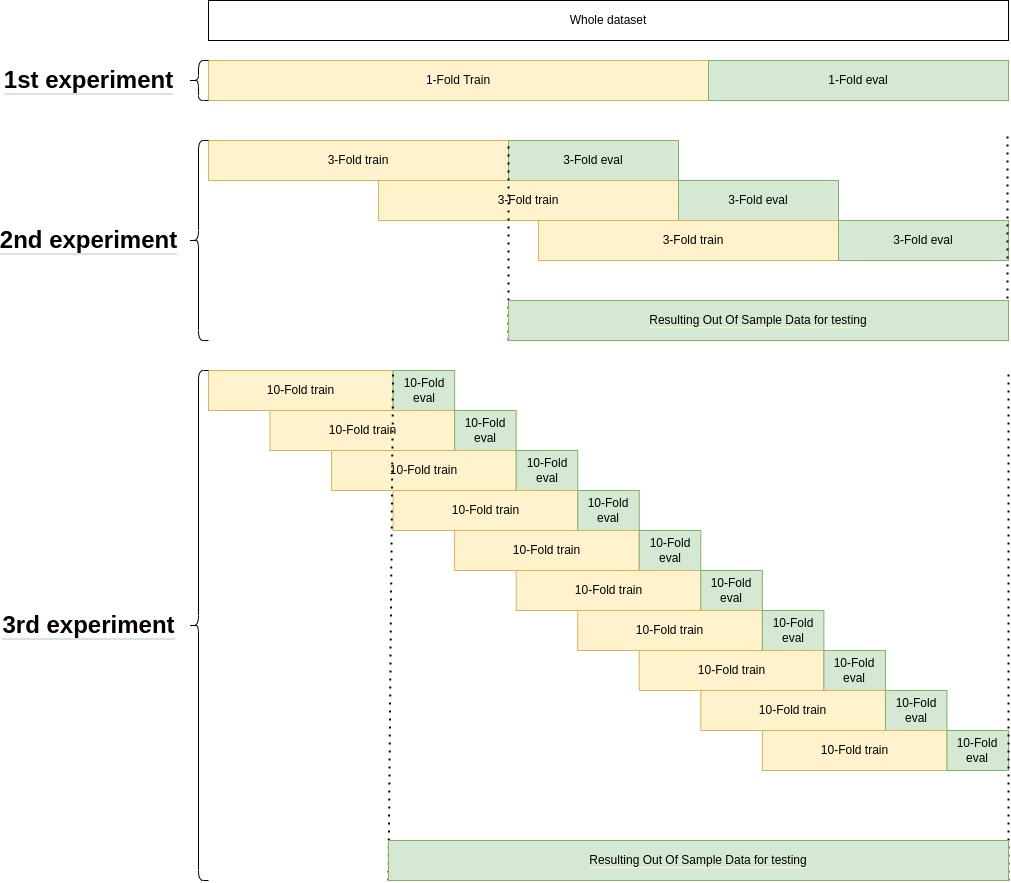

In [5]:
exp_pic = """
/9j/4AAQSkZJRgABAQAAAQABAAD/4gIoSUNDX1BST0ZJTEUAAQEAAAIYAAAAAAQwAABtbnRyUkdCIFhZWiAAAAAAAAAAAAAAAABhY3NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAA9tYAAQAAAADTLQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAAHRyWFlaAAABZAAAABRnWFlaAAABeAAAABRiWFlaAAABjAAAABRyVFJDAAABoAAAAChnVFJDAAABoAAAAChiVFJDAAABoAAAACh3dHB0AAAByAAAABRjcHJ0AAAB3AAAADxtbHVjAAAAAAAAAAEAAAAMZW5VUwAAAFgAAAAcAHMAUgBHAEIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFhZWiAAAAAAAABvogAAOPUAAAOQWFlaIAAAAAAAAGKZAAC3hQAAGNpYWVogAAAAAAAAJKAAAA+EAAC2z3BhcmEAAAAAAAQAAAACZmYAAPKnAAANWQAAE9AAAApbAAAAAAAAAABYWVogAAAAAAAA9tYAAQAAAADTLW1sdWMAAAAAAAAAAQAAAAxlblVTAAAAIAAAABwARwBvAG8AZwBsAGUAIABJAG4AYwAuACAAMgAwADEANv/bAEMAAwICAgICAwICAgMDAwMEBgQEBAQECAYGBQYJCAoKCQgJCQoMDwwKCw4LCQkNEQ0ODxAQERAKDBITEhATDxAQEP/bAEMBAwMDBAMECAQECBALCQsQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEP/AABEIA3MD8wMBIgACEQEDEQH/xAAdAAEAAwADAQEBAAAAAAAAAAAABQYHAwQICQEC/8QAZBAAAAYBAgEHBQoICgYHBQYHAAECAwQFBgcREggTIVaV09QUFRYXVRgiMUFYkpOUltI2N2F0dXeztgkjMjVRVGVmtOEkMzRTcbE4QnOBsrXDQ0VScpEZJTl2ocHEJkZihNGj/8QAGgEBAAMBAQEAAAAAAAAAAAAAAAECBAMFBv/EAD4RAQABAQUFBAkCBgICAwEBAAABAgMUUaHRBBESUpETFTFhBSEzQXGSseHwMoEiNEJTwdJyooLCI2LxQ7L/2gAMAwEAAhEDEQA/APqmAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8v8mTkycm2/5NulF7e8nzTWxsrHB6KXMmS8TgPPyX3IDKnHXHFNGpa1KM1GozMzMzMxpfuTuSx8mnSr7G13chyTv+ixo3+r/Hv/LmBqoDKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqohZma4bXQruysMtpYsTGVGm7kPT2kN1hk0h4ykqNWzJ804257/AG94tKvgMjAUT3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kXy0zPD6Swh1N1ldNAnWBIVEjSp7TTsglvNMJNtClEayN59hstiPdbrafhUkjmQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cjSm7epdtn6Fq0iLs4sdqY/CS+k32mHVOIadU3vxJQtTLqUqMtjNtZEZmk9u2Ayr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaUu3qW7ZmhctIibORHcmMwlPpJ9xhtSEOOpb34jQlTraTURbEbiSM91FvzuyI8c20vvttm8vm2yWoi417GfCW/wnsRnt+QwGXe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cjVQAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyNRVIjpkIiKfbJ9xCnENGouNSEmklKIvhMiNaSM/i4i/pIcgDKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq9ydyWPk06VfY2u7kPcnclj5NOlX2Nru5GqgAyr3J3JY+TTpV9ja7uQ9ydyWPk06VfY2u7kaqADKvcnclj5NOlX2Nru5D3J3JY+TTpV9ja7uRqoAMq5J3/RY0b/V/j3/lzAByTv8AosaN/q/x7/y5gAGqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMq5J3/RY0b/V/j3/lzA1UZVyTv+ixo3+r/Hv/AC5gaqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADyVrnjxSdfW9H5ENbtJr0mmfmoIj4FeZHXHrMlGXQSXoSYLB7/F0F8JbetQAfPyuj3OouMrt8kmzmJ+GZTp7pI5MaUbTxTq+9jqspLSv+qpxx+P74vgNgtukhfHMhcx/MpmBZzqXktRplS6g2tZJtpuVzY7zJeY6+ZDiSLVTxSENG9KmKSani4lIab4jLZB+xwAfPtOZ6pNQLrImbWcqS/jOGxpttOsHq6QrHDyq/bblPS22lux+cgkwp2Sls1oQ44770y4i9H6B3WZzNLcysoOSU+TJZspp4qquyOXkLTbKYjJpjHZSmGVzNpXP7L9+RJWlvjUbatt1AB8+qbUTGK5+uzGm1MzDI7RGilk5kUlq+VImVts/OqESDJ2TzqK91C1mp1okpRHQglk0j/rctbmdVc59S0+T6gKTj2Pal0s6vdj6iWVpGaiS6Wc3ziLN/mXZDC5rKGyNXE2Tq3GUqMlKQf0AAB4GRrNYTssW9Tar22MxsqrMwhTJ0/KZV5MqpqULcheUVKGExq6QwTTim48dXOrabXxEo0qWXbkan5CnGo9VjmTtSMcj5hCj5Lfs6sWMuhVDcrJjiEt5AplyZBJUpmKTzfviQpxpBOJS+pQ93AA8f6UPPSNaNH7/O89ZsXZuM5zDoJcTKZ8mHOQm2rVRIxOvJYKwcTFN4ucU0ZvpjIeM3OaQ4n2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKuSd/0WNG/1f49/5cwAck7/AKLGjf6v8e/8uYABqoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKuSd/0WNG/1f49/5cwNVGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyA1UBlXuTuSx8mnSr7G13ch7k7ksfJp0q+xtd3IDVQGVe5O5LHyadKvsbXdyHuTuSx8mnSr7G13cgNVAZV7k7ksfJp0q+xtd3Ie5O5LHyadKvsbXdyAck7/osaN/q/wAe/wDLmAGlVNTVUFVCoqKsiV1bXR24kOHEZSyxGYbSSW2m20kSUISkiSSSIiIiIiAB2wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEbkmRUmIY9Z5Xkti1X1NNDenzpTp7IYjtINbi1bfESUmf/AHDN4Gd8orIayPe4/ofiMOHONbseNkecSYFg3HM/4pTzMerkobcUnZSmydVwGfCZmZGA1oBTqfLsqtKmFZrxipZVLjNvm2Vu4skGtJK4eLyYt9t9t9i3/oIdv0gyjq/V9queHHlx6Z2KY3xVPy1aNNzto92carMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OJ742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFZ9IMo6v1farnhw9IMo6v1farnhw742Pmn5atC6W2GcarMArPpBlHV+r7Vc8OHpBlHV+r7Vc8OHfGx80/LVoXS2wzjVZgFDtc/yWssYlYWLVjrstl59J+d3EpSlpTaTI/9HM9zN1O3/Axx+sLLOqNR2274Ud7Pb7C1p4qJnd8KtGO1tKbGubOvxj9/o0ABn/rCyzqjUdtu+FD1hZZ1RqO23fCi97svPpOjnebPHKdGgAM/9YWWdUajtt3woesLLOqNR2274UL3ZefSdC82eOU6NAAZ/wCsLLOqNR2274UPWFlnVGo7bd8KF7svPpOhebPHKdGgAM/9YWWdUajtt3woesLLOqNR2274UL3ZefSdC82eOU6NAAZ/6wss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAAz/wBYWWdUajtt3woesLLOqNR2274UL3ZefSdC82eOU6NAAZ/6wss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAAz/ANYWWdUajtt3woesLLOqNR2274UL3ZefSdC82eOU6NAAZ/6wss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAAz/1hZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/AKwss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAAz/1hZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/rCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP/AFhZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/rCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP8A1hZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/rCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP/WFlnVGo7bd8KHrCyzqjUdtu+FC92Xn0nQvNnjlOjQAEdjtt5/x+svfJ+Y85Q2ZfNcfFzfOIJXDxbFvtvtvsQDRTVFURVHhLtExMb4SIq2M6q6X5re2OL4bqRi19c1HF5wrqy4jypUPhVwHzzTazW3sr3p8RF09HwiucoTSC31z09VpzXajXWGRLCayq2nU6uGXIgJ4udioXuXBzm6SNR7ltvulRGZH4S/g6sCxvS3l48oDTrD4zselx2CuvgtuuqdWlpuY0RcS1dKj+Mz/ACiUvpyA8f8AKX5Y2p2E8oXHOS3oTiWISsvvK0rR21zGe5GrWUqJ00spS2pC1rNLKj6FfCpJEkz32sGmmrfLVunc5081I0Hxqky+pqHJeM5NEfkOYvZzDSnm2HN1m+kt1kZmlW+yXCMkmRcQeoAHy9/gwMv5SeZ62arZNKZwqTjtzlbsrPH3jklPamG1KNhNcRK4CaJ3hSZOEoybLYukh9GNVNSMc0g05yLU7LXHE1ONV7thJJoiNxwkJ6G0EexGtauFKSMyLdRbmQC1APnlH5c3LOm6NucrKLoZp16pGn1OnVKtJXn9UBMjmVPk5vzXCSyMtza32I1cHD0jSOUNyydTdOtMNNuU/pRilHk2j+QJhP5QzIhv+eK5h9SdltuIfJpPwm0ZLbUSXUpIzUS/eh7FAeOMX5aeba+8qWBpLyYIGL3OnVJXRrPMMtsYkl7m0ukSyZim282lLhkaWy40qPnOdM08LSt6dD5cHKdy3lR6o8mnTPSrDL+wxl59FHJkLkQ2YrDTiCXJsHTeVziSJaEEhpCDUtxPSREYD3wA8dck7lq6gaj6s53yeuUdhFJiGfYPGcsHXKp1fkL8VtSCcPZxazIyS604lRLMloWZ7J4emj4xy3OVnygoGa6mcl/R/An9OsMlvREKyeZJK0uVMtk6tMdLS0IbcNtTauBZGRc4kuJR77B79ERl+WY/geKXOb5ZYeQ0lBAfs7GVzS3eYjMoNxxfA2Slq2Skz2SRme3QRmPF+pP8IpcL5D9Zyq9Isapm7l67Yo7KovEuymIcjdZPI3ZcaUr4G1oVuW6Flukj6Ck8W5UHKezTSLUjW7KNE8WptNoWnc/IMTfn7vPXEtmPxkcmOUjjKI8ROLSg0IVwGn357kZh6l0o1b0+1wwiFqPpdkHnrHbBx5qNM8kfjcamnFNuFzb6EOFstKi6UlvtuW5C3j56O8urVLFf4PCg5TuP4RgMHIp2QuVblWxWSG6pDPlT7ZqQyiQThLMm0mZ84Zbmro6ejoajfwjXKU0sjaeau5loHj8LR/OPJksyzkuKtXkKbStbySS6aWCcRxutNrQozQREpRHvsH0aAfP3Lf4QHlFaW6uaeq1a0Jo6DSrU+YhukfKWty4airW2knpBpcNtDiUPtOqYNsj2UaSVukzLT+UdywNQcU14xvkrcnXCKLI9Rb2IdhKlX8lxqsrGOBay5wmjJalc22pZ7KLYjQREtS9iD1mA8qcnblYal5HrrkfJb5R2F4/j+oVNXpt4MzHZLrlXaxDJBnzROmbiVElZKLdR7kThGSDRseF6F8vjlncojEMsi6UaF4RfZdjFivyiUpb8KrYhcBcy3wOyjW/JdWl/YkuISlLZcX8ogH0fAeC9OOXJrVyguR9qJqVp7iuLUOpGnynk3Meecg4JQ0R1POSI6SVziHuBDhIbWpREtv3xmR7FH/wQMvW1/RNCLuNih6aG9YuVklpUg7pyzOUnnCf4lc1zOxubGRcW/DufwgPoIAAAynlN8D2lSal9Jqj3WU4rSyU7bkqPMvoEZ5J/kNt5ZH/xGrDJuUBaUs2Fienxu+VXt3mWNzIVdHfSmQpqBbRZ78g07KPmWmoi1LVsRHsSOJJrSZayApGK/gvT/mEf9mkSgi8V/Ben/MI/7NIlB8FYeyp+EfR7tf6pAAB1VAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABm2oWd5zimpmnFBWVlIrGcsunaawkyFurm875ssJiSZQnhQ2STgo3Wo18ROmRJTw8R2ppmqd0ImdzSQGWcorU650qxCnuaa+xmiVZ5FAp5Frkcdb0CAw+pRLecSmRH34di+F1Jf0iIxnXRiNSxHH8/wAW1ctbq2VV1UfTmC0wSnER1PutuG/ZPtJNDaFOGtb7ZbGhJEalJ4rRZVTTxQiaoidzagGDt8qamXdS5aamY5RtU0RTUBEUit1Xbty/VKrjSbpNcZSWia23JJK4lG5wdJWvSvU3JNSrHUavlUKsdexW9apoMawjkqQyaqqFKM5JNPrbdMnZTmxtOElTZI2PfdRpsqoiZkiuJ8GmgPOTeresmG3OpFpqXl+FTsW0rjMT7VukwyWxOsI7kI5KiZU7auNtLT8HvkrJW3/V36L1kWvkbE4LVrkOlueQq9uIzPtZjkOLzNRHdfWy2t9XlH8YfvDcU3H55xtBpNxKDURHM2NUeHrRxx72pgMeb5QkWNksjEU4xfZFbyL62qa6JUwY7B7QGo7jpLckSybP3sgjJxSmyVsaeBKuEl6JguZU+oeHU+cY/wCUFX3cNuYwmQ3wOoSst+Badz2Wk90mRGZbkexn8IrVRVTG+UxVE+CdAAFFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFQyr8LKb9HWH7WIPwfuVfhZTfo6w/axB+D2Ng9lPxfM7d/M1/t9IAABtZQAAAAAAAAAAAAAAAAAAUrWXJ8vwvTTIMrwivqpVnUV8mckrRxxMdtDLK3FKUlv3zh+82JBKRuai3UktzExG8iN66gI+hsHrSgrrWQlCXZcNmQtKCMkkpaCUZFuZntuf9I866O8phzJsMqdRM+180hcjrxxWQ3OM0tW4i1hJTEN91slHZvK3Z2PiI4+5kgy2SZ7lMUzKYpmXpoBjl5r9IYKNWRsPtMfvvPONsP12Qss8aq2zsUxPKGzjPuI3LZ4iI18SFpLjRsZEpVa/uZTn+G4/jmK2LFBk79s21b2DDZNT2obSz5yKbbyloSbiS/17aDWg90EZbqJwycMtjAZ3lut2N4he2NRKo7ybFom4jt9aQ2WTiU6JCjJo3zW6lxXQXGomkOGhBkpXCRkY/ljXbE5MKolM1F84/bS7iH5CzDS9Lirq+fKWbrTa1KMicYJtJN8alLeZIiMlblHDJwy0YBjltr9INlMGDh1pQ3ka9xmHNrchZZ5wq+2npjIkIOM+4jc0okEkjXxJW0fGjboPYwmJgmJjxAABCAAAAAAAAAAAAAAAAAAAAFy06/F9jH6GhfsEAGnX4vsY/Q0L9ggBusPZU/CPo9Kz/RHwVjXzlAac8mzBkaiaoS50emcntVyVw4qpDnPOJWpJcKenbZtXSPlpybuW5oPplyztbNbcqs7hvF8657zQ6zWrceXxSUOFxtke6PepP4R9iJ0/yHg/0KVI49/9Q3x8O23w9PR8I6vn7+xbX6t/mLzVEepM1xHql4M5ceUclTLM7xqLyodCssZxmwoUS6TU2p53+LS4ROFEWlhJn0GpZ8DhL4TUSiRss1FTv4PBWQwuU5kFLyfcu1EyXk6sUqj8rytlxEducZI4ExuJKE84S+IveoQZo4uJJ8KVH9JPP39i2v1b/MPP39i2v1b/ADDjpRx0vmn/AAaWpFPo/r3q5yetQKq6rMwynK1u1rCq9w2lpY8qU4a17bITwkSkqP3qiUWxnuPb3LC0tvtaeTNqFppiyScuLepM4DRrJPPSGXEPttcR9BcamiRufQXF09A07z9/Ytr9W/zDz9/Ytr9W/wAw46TjpfFnSKLyGMd0lhYbrNyUs7yLXmtkrr5mOx3rmLIs3DkK4HEk28SGtmlJI08BK4kHsk9+IeteVLqVB0k5N+DcjLRDTPzRnOq9aiogYfJmHZLoYEtavKOfddUviVxOONpUpRpSZOrJWzRb+8fP39i2v1b/ADDz9/Ytr9W/zDjpOOl83+S4m4/g4eUd7mDVSfDmYXqq1FnY/lJRiZQdqltLS2Vq+EkG4Zt8KjPhNTC9kk6sxUdLNa6vQX+Eg5Q+cZVj1zOxc/K4ttOqoKpblWlUlhTch1tG6+ZNSObUpJHspxG/QPqd5+/sW1+rf5jyhoJybdRdLeWLq9yhMg8hkY7n7LrdbFh8+ua0apDThc8hbSW09Dav5Liuky/4hx0nHSwTksUdvyteWrrVynKShtabT+8x2TjtbYzIxtHJdcix4bZoL4FHzUdbqiIz4DUgj6VEPO2i2CclDQyDmemfLq0AyqZqPUWbzlGcV20bRbRuaSlEdg4zzbaiNxC1pdMuFSXi9973YfbPz9/Ytr9W/wAw8/f2La/Vv8w46TjpfL3lT4ZheIfwZCJGCaGW2ktfkWZwrlWOWtpInSkrWg2iecU+tS2+NDLZk2e2xERmRGox68zpCG/4Ni4bbSSUp0VcSkiLoIipPgHobz9/Ytr9W/zDz9/Ytr9W/wAw46TjpfHzJP8A8F/FP/zm5/j5Y1H+EuSlP8HloKSUkRFKx4i2L4C8xyB9MvP39i2v1b/MPP39i2v1b/MOOk46Xzu/hYUpTX8nEkpIiLI1EREXwFwxBS+Xho7ieH8uKn115QGm1zlmimU1zEa4kVpySKBJajHHSTio60LRwqQy7txFxpNZJ4jSaR9RfP39i2v1b/MPP39i2v1b/MOOk46XhXkRYtyRsl1wscx5M/JeyiiqMZhuJh6gWNvZpiS3HkE2uOzGlPK41GS19JkfCSeI+EzRvCfwMKUlgurSiSXEeWNEZ7dO3Mn/AP7MfQXz9/Ytr9W/zDz9/Ytr9W/zDjpOOl8wv4Pmjs8k0X5YON0cNcqwtFWEGHHbLdTrzsSchtCS/pNSiIv+I0v+CE1jxSTpC7yd3Y1tFzPGZNlaz48iA4hlEdUhsiPnDLhJfE8RcB7K96o9ti3HvLz9/Ytr9W/zHYhWflrpteb5rGyeLifa4Un0l0b7/D0hFUSmK6Z9TuiKyjE8WziilYtmuNVWQU03g8prrSG3Liv8C0rRxtOEaFcK0pUW5HsaSMukiEqAss8959oppLo9NwzUrSrTTFMMs67L6eumSKCnjV65kOylIr3I7xsoTzjfHLbcJKtyJTSDLYyHoQZfyjIsuZp/Uswozz7ic7wh1SWkGpRNoyesWtRkX/VShKlGfwERGZ9BDUAFIxX8F6f8wj/s0iUEXiv4L0/5hH/ZpEoPgrD2VPwj6Pdr/VIAAOqoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAy3VjTTU3OcqxG+xHUPGKGJh9kdzFi2WLSLJx6aqHMhqNbrdhHLmuZmqMkEglEtBHxmRmgakAtTVNE74RMb/ABZjkegGDWc2Ja43SUmOWC8pgZTcyoVS2ly4fjOOL2fUk0mpSlPOHxqNRka1Hse5iU1C03m5ROxvI8TvYlBf4pOemQZEmuOZFcS9HcYeaeYS60paVJcJRGlxCiU2g9zLdKr0AntKsUcMPPfuSyaYekxtQVpuXPJrFM9dWSklctXz10qWbROkRsrkvqRzG5GTXvSc398WjaV6b3uCT8yvMmy+PkFpmd01dSXY9YcFmOpECLDJpts3XT4CTESZbqM9lbGajI1HfgE1WtdUbpkiiI8GT5joP6WVurdf6VeS+tOuagcfkPH5u4IXk3Htzhc9v/K295/Rv8YretvJZPWS+vrWTllSw1dVEeuYOyxxNlKqHmDdUl2C8t9KY6VrcSbqSbNayR71xB8Kk74Amm2rpnfE/nq0gmiJ8WSYroRKx/PYufTsvamSWrS5tHmGq02EOLsGYjakpM3lmkkHFNRb8RmTm3Rw7quGleC+rLT2jwPzr5y8zRvJ/K+Y5nnffGrfg4lcP8r4OIxawFarSqqN0kUxHgAACiwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACoZV+FlN+jrD9rEH4P3Kvwspv0dYftYg/B7Gweyn4vmdu/ma/2+kAAA2soAAAAAAAAAAAAAAAAAqOq+JZLnmB22G4xkdZRu3cV6vlS59U5YJKM80ttwkNokMGlz35GlZqURbHulW/RbgEx6iJ3etRMc0tr0xMfsNRK/FslynGWuYrruPQ+SrjNkWyeaJ159battuIyc2M9z2L4BH02htJD0Ah6CW9iqZFZxVGLyLJiOUd51BRiYN9CTNXAro4iIzVse3SY0sBPFKeKWOStB8hyK3TlOb6gRLG8blY+pt+FSHEYTFq7Dy3m+aOQ4ZuvLNRLc4+EiJHC2XCZK/nDNA77FMixGS9qExMx/BXLJNNWJpuaf5iWhaSRIkc+onFNEpKUqS22RpIyUkzPiLZQDik4pYxnHJqoMv1Em56cbD31XKYSbJF7iMe3kp8n96RxH3VkUc1t8KFEtt1PvSUSSPff+rHk5tTsj1Evo+bzoBZpVSq+tbisc25QuzGWkTX2XCXus3lxYzuxEg0qQv3x8W6dlAOKU8cvPtJyVXae+k3UfJsarmbCRjcuZAo8TKvjG9T2K5bSmklJUaedQ642s3DcVxGlZKJKebP0EACJmZ8UTVM+IAAIQAAAAAAAAAAAAAAAAAAAAuWnX4vsY/Q0L9ggA06/F9jH6GhfsEAN1h7Kn4R9HpWf6I+CwgADquAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACram4KzqRhU/EnLN6sefXGlwp7KCWuHNjPtyYsgkn0K5t9lpfCZlvw7blvuKuVzyn4cFlk9OdLraYha0PSCzSwrmnEESeBxLXmqQaDUZr3QbiuEkp9+viPh1EAFHoqXOK6kr6+VV0fPRYrTLnN2ryk8SUER7GcYjMty6DMi/4EO95FmHsqm7Td8OLUA8ePQthTG6Kqt37aNc7ZXPrmI/P3VXyLMPZVN2m74cPIsw9lU3abvhxagE9zWPNVloXyvCM9VV8izD2VTdpu+HDyLMPZVN2m74cWoA7msearLQvleEZ6qr5FmHsqm7Td8OHkWYeyqbtN3w4tQB3NY81WWhfK8Iz1VXyLMPZVN2m74cPIsw9lU3abvhxagDuax5qstC+V4RnqqvkWYeyqbtN3w4eRZh7Kpu03fDi1AHc1jzVZaF8rwjPVVfIsw9lU3abvhw8izD2VTdpu+HFqAO5rHmqy0L5XhGeqq+RZh7Kpu03fDh5FmHsqm7Td8OLUAdzWPNVloXyvCM9VV8izD2VTdpu+HDyLMPZVN2m74cWoA7msearLQvleEZ6qr5FmHsqm7Td8OHkWYeyqbtN3w4tQB3NY81WWhfK8Iz1VXyLMPZVN2m74cPIsw9lU3abvhxagDuax5qstC+V4RnqqvkWYeyqbtN3w4eRZh7Kpu03fDi1AHc1jzVZaF8rwjPVVfIsw9lU3abvhw8izD2VTdpu+HFqAO5rHmqy0L5XhGeqq+RZh7Kpu03fDh5FmHsqm7Td8OLUAdzWPNVloXyvCM9VV8izD2VTdpu+HDyLMPZVN2m74cWoA7msearLQvleEZ6qr5FmHsqm7Td8OHkWYeyqbtN3w4tQB3NY81WWhfK8Iz1VXyLMPZVN2m74cPIsw9lU3abvhxagDuax5qstC+V4RnqqvkWYeyqbtN3w4eRZh7Kpu03fDi1AHc1jzVZaF8rwjPVVfIsw9lU3abvhw8izD2VTdpu+HFqAO5rHmqy0L5XhGeqq+RZh7Kpu03fDh5FmHsqm7Td8OLUAdzWPNVloXyvCM9VV8izD2VTdpu+HDyLMPZVN2m74cWoA7msearLQvleEZ6qr5FmHsqm7Td8OHkWYeyqbtN3w4tQB3NY81WWhfK8Iz1VXyLMPZVN2m74cPIsw9lU3abvhxagDuax5qstC+V4RnqqvkWYeyqbtN3w4eRZh7Kpu03fDi1AHc1jzVZaF8rwjPVVfIsw9lU3abvhw8izD2VTdpu+HFqAO5rHmqy0L5XhGeqq+RZh7Kpu03fDh5FmHsqm7Td8OLUAdzWPNVloXyvCM9VV8izD2VTdpu+HDyLMPZVN2m74cWoA7msearLQvleEZ6qr5FmHsqm7Td8OHkWYeyqbtN3w4tQB3NY81WWhfK8Iz1VXyLMPZVN2m74cPIsw9lU3abvhxagDuax5qstC+V4RnqqvkWYeyqbtN3w4eRZh7Kpu03fDi1AHc1jzVZaF8rwjPVVfIsw9lU3abvhw8izD2VTdpu+HFqAO5rHmqy0L5XhGerObvFM5sraDaMQKJPkkaRHNtdm8XFzqmVb7lHP4Oa+Db/AK35BxeimoPszHu13/CjSwGmy2Cixp4aapy0YLayi2rm0q8Z/wDxmnopqD7Mx7td/wAKHopqD7Mx7td/wo0sB0usc05aOd2pxlmnopqD7Mx7td/woeimoPszHu13/CjSwC6xzTloXanGWaeimoPszHu13/Ch6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8KHopqD7Mx7td/wo0sAusc05aF2pxlmnopqD7Mx7td/woeimoPszHu13/CjSwC6xzTloXanGWaeimoPszHu13/Ch6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8KHopqD7Mx7td/wo0sAusc05aF2pxlmnopqD7Mx7td/woeimoPszHu13/CjSwC6xzTloXanGWaeimoPszHu13/Ch6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8KHopqD7Mx7td/wo0sAusc05aF2pxlmnopqD7Mx7td/woeimoPszHu13/CjSwC6xzTloXanGWaeimoPszHu13/Ch6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8KHopqD7Mx7td/wo0sAusc05aF2pxlmnopqD7Mx7td/woeimoPszHu13/CjSwC6xzTloXanGWaeimoPszHu13/Ch6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8KHopqD7Mx7td/wo0sAusc05aF2pxlmnopqD7Mx7td/woeimoPszHu13/CjSwC6xzTloXanGWaeimoPszHu13/Ch6Kag+zMe7Xf8KNLALrHNOWhdqcZRWKVUiixenpJa21v18CPFdU2Zmg1ttpSZpMyI9tyPbciASoDRTTFFMUx7neI4Y3QAACyQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABG5JkVJiGPWeV5LYtV9TTQ3p86U6eyGI7SDW4tW3xElJn/ANwzeBnfKKyGsj3uP6H4jDhzjW7HjZHnEmBYNxzP+KU8zHq5KG3FJ2UpsnVcBnwmZmRgNaAU6ny7KrSphWa8YqWVS4zb5tlbuLJBrSSuHi8mLfbfbfYt/wCgh2/SDKOr9X2q54ceXHpnYpjfFU/LVo03O2j3ZxqswCs+kGUdX6vtVzw4ekGUdX6vtVzw4nvjY+aflq0LpbYZxqswCs+kGUdX6vtVzw4ekGUdX6vtVzw4d8bHzT8tWhdLbDONVmAVn0gyjq/V9queHD0gyjq/V9queHDvjY+aflq0LpbYZxqswCs+kGUdX6vtVzw4ekGUdX6vtVzw4d8bHzT8tWhdLbDONVmAVn0gyjq/V9queHD0gyjq/V9queHDvjY+aflq0LpbYZxqswCs+kGUdX6vtVzw4ekGUdX6vtVzw4d8bHzT8tWhdLbDONVmAVn0gyjq/V9queHD0gyjq/V9queHDvjY+aflq0LpbYZxqswCs+kGUdX6vtVzw4ekGUdX6vtVzw4d8bHzT8tWhdLbDONVmAVn0gyjq/V9queHD0gyjq/V9queHDvjY+aflq0LpbYZxqswCs+kGUdX6vtVzw4ekGUdX6vtVzw4d8bHzT8tWhdLbDONVmAVn0gyjq/V9queHD0gyjq/V9queHDvjY+aflq0LpbYZxqswCs+kGUdX6vtVzw4ekGUdX6vtVzw4d8bHzT8tWhdLbDONVmAVn0gyjq/V9queHD0gyjq/V9queHDvjY+aflq0LpbYZxqswCs+kGUdX6vtVzw4ekGUdX6vtVzw4d8bHzT8tWhdLbDONVmAVn0gyjq/V9queHD0gyjq/V9queHDvjY+aflq0LpbYZxqswCs+kGUdX6vtVzw4ekGUdX6vtVzw4d8bHzT8tWhdLbDONVmAVn0gyjq/V9queHD0gyjq/V9queHDvjY+aflq0LpbYZxqswCs+kGUdX6vtVzw4ibXP8lrLGJWFi1Y67LZefSfndxKUpaU2kyP8A0cz3M3U7f8DFqPS2yV1RTTVO+f8A61aOdtY12FE2lp4R5xP0XwBn/rCyzqjUdtu+FD1hZZ1RqO23fCjRe7Lz6Tox3mzxynRoADP/AFhZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/rCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP8A1hZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/rCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP/WFlnVGo7bd8KHrCyzqjUdtu+FC92Xn0nQvNnjlOjQAGf8ArCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP/WFlnVGo7bd8KHrCyzqjUdtu+FC92Xn0nQvNnjlOjQAGf+sLLOqNR2274UPWFlnVGo7bd8KF7svPpOhebPHKdGgAM/8AWFlnVGo7bd8KHrCyzqjUdtu+FC92Xn0nQvNnjlOjQAGfJ1IyFqTDROxSubYkzI0Ra2rdbi0c88holEk46SPY1ke25fANBHWztqLXfw+7ymPq6UWlNp+kAAHRcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABX8/wmp1Hw22wa9k2EeBcxzjSHa+UqNIQkzI923U++QfR8JALAA6lTWsU1VCp4q3VswY7cZtTyzWs0oSSSNSj6VHsXSZ/CYAO2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKeU3wPaVJqX0mqPdZTitLJTtuSo8y+gRnkn+Q23lkf8AxGrDKuUt+Lqo/WBgn71VY1UBSMV/Ben/ADCP+zSJQReK/gvT/mEf9mkSg+CsPZU/CPo92v8AVIAAOqoAAAAAAAAAAAAAAAAAAMSxjVjUJzWyNpnkczCp6pkafMnU9GTy7DGY7ZoOI5OfN1SHCfQtJEXMsHxK97ziUqULU0TVv3e5EzubaAwHV3XC8xDWJGnaNXdLtPawsZj3SZmZQFyFzH3JT7Kmmj84xEkSUspUf8s/ffEWwn5nKJxzHIpJsW5mUxqetrZ2R5RjsVhNPCRLSRtyOFyUp02lJ/juFk5BoaUlSlGRko79jVuiY96vHDXwGF1fKTkeQToczELG6vmbTLEpi0Uds0RauotnoSZT/PvoMzMks7pbNTi1Gvm29iMk92ZrrkVRyftPtXHMMcvLbLixVqTX1i2mUNu2r0Vpw2/KHkkREqQaUEpZ++U3xmSONxKbGuJ3fsccNnAZZWa+xr2DbzqDS3O7NNVkMnGG0RokQzmzo8iQxI5tRySQ202cY1G8+ppsycbSSjcNTaYGx5U+JV8SPlL0K4RSox25t5sDzWlc9h+uso0CQyaikcJONvOuINtKFks0mpLpEkkuRFlXM7tyeOG4gKhg2pEPNrO9oXMbuaC2x1yOibAtSj85zb7fOMupVHddbUhREov5XERoURpL47eKTE0zulMTvAABCQAAAAAAAAAAAAAAAABmGbQs2XrDi06DdV7eMN0lmibBXGM5Lsg3Y3CtDnwJSW6Ny/If9I08Zhm0LNl6w4tOg3Ve3jDdJZomwVxjOS7IN2NwrQ58CUlujcvyH/SO+ze1pYvSH8tV+31hPgAD3nzgAAAAAAADOtZcxyjCaqPdVeUYVi1Mw285Z3eUpcdYaWRoJiO2y28yaluqUsuLnPe8BESHDWRF1ch1Qyiq5M1prO5jbVXkULB38lOpnEtbcaYiCqRzDpEaVmlKy4TLdKtiP+SfwTu3p4Zlp4DCcW14iRYM68v9ctNc+ZYZjNNU+EVnBYnLkyGmI6PfWcklcbrqWiJSUFxLSZrSRHvJ2HKEis3tHXu1EihS3eTavKIl00g5Vc2zSyLJLiFR3XGlEpDbKuJKnEmlS09CyPhnhlPDLYwGT4JrXZ53qTGxdOG2dFVS8VLImPO7DaZT6VyEIacSbLziEoUhSjNtZJdSZFxJTuRH3bHXjHoF5Lq28YyOZCiWvmBVvHYjnDXa82Skw08TxOmtSjS0S+b5rnVEg3CPfZwyjhlpYDNW9e8UnQKmfQUeRXnnnGWspjMVkJLzxRnnWWmGlo4yNLri3j2394kmH1LWhKNz6MXW927yjFaCrx+VVPTcpm41fwLdtvyuC6zUPWCCSph5bJmpJRlEpKnEmhwy6FfyXDJwy1gAAVQAAAAAADp2f8qt/TNX/jWRr4yCz/lVv6Zq/wDGsjXx32b9dXwj/LVsvv8A2AABsawAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAV/P8ACanUfDbbBr2TYR4FzHONIdr5So0hCTMj3bdT75B9HwkLAK/n+E1Oo+G22DXsmwjwLmOcaQ7XylRpCEmZHu26n3yD6PhIBK1NaxTVUKnirdWzBjtxm1PLNazShJJI1KPpUexdJn8JgFTWsU1VCp4q3VswY7cZtTyzWs0oSSSNSj6VHsXSZ/CYAO2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKuUt+Lqo/WBgn71VY1UZVylvxdVH6wME/eqrGqgKRiv4L0/5hH/ZpEoIvFfwXp/zCP+zSJQfBWHsqfhH0e7X+qQAAdVQAAAAAAAAAAAAAAAABjXqBuchyeqnapZzAzKhoE2TdfXysfQ3KktTG1tLZnyDdWiU2lpw0khLLRKNKFL4jSQ2UBamuaPBExE+LPMb0WxfEc+VlmNw62tqUY3Hx2LRxK5DLEZLUuRINxBpPhIlHIMuAkF0kZ7nvsUBn2gE3MLXK26zNWarHc/jwo2UVq6ryh99EdHNH5K+TyCjm4wSWl8bbpbJI0kk9zPYgExa1xO/f60cMbtzC2+TfkFNZPXeH6lsVlhPdyZme7Io/KUrhW9ouw4GklIRzb7ClmhDqjWhW6jU0e5EmwT9E5ruheKaQ1mWsx7DEG8cVCt3q03mnJFRIivtLcjE8kzQ4uIRKQTpGRLPZe5bjVAEza1z4ycEMPueTfMs8PhY0WXVUlUXNLfL3mLWhVMq53l78104smGUlBuoaOaSkGbu3OMNrNP8A1SrVdyN3K/GXsURqJGKEityCrgkxj6WPJ2bS3j2Z8SEPE2fNOMuNpJCW0mhxGyU82fH6VAWi3tI8JR2dKqUGC+Y9Qcszvzrz/pQxWs+S8xw+T+SIdTvx8R8fFzu/8ktuH49+i1gA5TM1euVojcAACEgAAAAAAAAAAAAAAAADMM2hZsvWHFp0G6r28YbpLNE2CuMZyXZBuxuFaHPgSkt0bl+Q/wCkaeMwzaFmy9YcWnQbqvbxhuks0TYK4xnJdkG7G4Voc+BKS3RuX5D/AKR32b2tLF6Q/lqv2+sJ8AAe8+cAAAAAABT87xfOLyTCm4VnUOkUyxIiy4dlT+c4Mxt3g2UppLzKycRwHwqJzh2cWSkK3LalyuS9gCtJpunsCHAavJOFv4Y3lT9Y07PbjuRFR+IzTwmaS4t+aJSU7FwlsQ2QBaKpjwTFUx4KdnmnMXNMRbx2NPTVzYcuBZQJ7cZLnMTIclqQwtTe5caOcZSSkcRcSTUW5Ge5UaZycFZHYuXma5i3YWNnaS59wqFWHFZfZepXqpEdhCnnFMpQ07znEpbpqXx/ASiJO1AEVTBFUwyzTrSHLMUy+Hl2Wahxb9yuxpGMRmI1KcFPMIdQ4l5Zm+7xOnw7LMuFJ+9NKUbGSouFyaqCu1Ok57FjYe6xMvDyFw5mIx5Nw3KMiM0tWK17tt86nnC/ijcSZmSXEltts4BxScUsJa5LyIuOZhRxM23XkdvFlQTfrjXHhVkecqa1UutJeSciNzj8pCiJbfE09wdGxmrmwDk1OYNlMa+ZyioTCj5Q5laaysx1New3JeplVjzLRIeUlDW3NupLhNRGlZKU4a+NO4AHFKeOQAAVVAAAAAAB07P+VW/pmr/xrI18ZBZ/yq39M1f+NZGvjvs366vhH+WrZff+wAANjWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACv5/hNTqPhttg17JsI8C5jnGkO18pUaQhJmR7tup98g+j4SFgFfz/CanUfDbbBr2TYR4FzHONIdr5So0hCTMj3bdT75B9HwkAlamtYpqqFTxVurZgx24zanlmtZpQkkkalH0qPYukz+EwCprWKaqhU8Vbq2YMduM2p5ZrWaUJJJGpR9Kj2LpM/hMAHbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABlXKW/F1UfrAwT96qsaqMq5S34uqj9YGCfvVVjVQFLqqTMKyrh1vm+md8kjtscfnF1PFwpJO+3MHtvt8A7XkWYeyqbtN3w4tQDx6fQlhTEUxVVuj4aNc7ZXM75iPz91V8izD2VTdpu+HDyLMPZVN2m74cWoBPc1jzVZaF8rwjPVVfIsw9lU3abvhw8izD2VTdpu+HFqAO5rHmqy0L5XhGeqq+RZh7Kpu03fDh5FmHsqm7Td8OLUAdzWPNVloXyvCM9VV8izD2VTdpu+HDyLMPZVN2m74cWoA7msearLQvleEZ6qr5FmHsqm7Td8OHkWYeyqbtN3w4tQB3NY81WWhfK8Iz1VXyLMPZVN2m74cPIsw9lU3abvhxagDuax5qstC+V4RnqqvkWYeyqbtN3w4eRZh7Kpu03fDi1AHc1jzVZaF8rwjPVVfIsw9lU3abvhw8izD2VTdpu+HFqAO5rHmqy0L5XhGeqq+RZh7Kpu03fDh5FmHsqm7Td8OLUAdzWPNVloXyvCM9VV8izD2VTdpu+HEaiwyVcuZDKmrOOE8llw/OTmxqNtDnR/EfBs4X9HTuL4Kgx/PuQfn7f8AhI4830nsFOy0UVWdc+urd7sJnDyaNmt5tapiqI8PPGPN1/KMo9j1faTncB5RlHser7Sc7gSgDy+zq55y0auKMPrqi/KMo9j1faTncB5RlHser7Sc7gSgB2dXPOWhxRh9dUX5RlHser7Sc7gPKMo9j1faTncCUAOzq55y0OKMPrqi/KMo9j1faTncB5RlHser7Sc7gSgB2dXPOWhxRh9dUX5RlHser7Sc7gPKMo9j1faTncCUAOzq55y0OKMPrqi/KMo9j1faTncB5RlHser7Sc7gSgB2dXPOWhxRh9dUX5RlHser7Sc7gPKMo9j1faTncCUAOzq55y0OKMPrqi/KMo9j1faTncCj5DjerttqXR5FBnY3GxiBWTIs2tW66uS/IdW2pDiHeaIkpTzSd07HuNMFXsK/URzUSpsq3IatnDWYD7dlWuRDVLflmZc0427vslCS33T8YvZ010VcUVzlo52tNFrTwV074/fVx+Z8o/qVX9ec7kPM+Uf1Kr+vOdyLYA7Xjaf7k9Kf9We47NyZzqqfmfKP6lV/XnO5DzPlH9Sq/rznci2AF42n+5PSn/UuOzcmc6qn5nyj+pVf15zuQ8z5R/Uqv6853ItgBeNp/uT0p/1Ljs3JnOqp+Z8o/qVX9ec7kPM+Uf1Kr+vOdyLYAXjaf7k9Kf8AUuOzcmc6qn5nyj+pVf15zuQ8z5R/Uqv6853ItgBeNp/uT0p/1Ljs3JnOqp+Z8o/qVX9ec7kPM+Uf1Kr+vOdyLYAXjaf7k9Kf9S47NyZzqqfmfKP6lV/XnO5DzPlH9Sq/rznci2AF42n+5PSn/UuOzcmc6qn5nyj+pVf15zuQ8z5R/Uqv6853ItgBeNp/uT0p/wBS47NyZzqqfmfKP6lV/XnO5DzPlH9Sq/rznci2AF42n+5PSn/UuOzcmc6qn5nyj+pVf15zuQ8z5R/Uqv6853ItgBeNp/uT0p/1Ljs3JnOrPcli5HWQI1g7ArVlHs65wkpnObqUUxnhL/U9BGexGfTsW57H8B2X1hZZ1RqO23fCjhz/APBwv0jW/wCNZHSHpbBa21XFNVc+73Ro8fbqY2e24bH+GN0efvnHek/WFlnVGo7bd8KHrCyzqjUdtu+FEYA9DjteectGTtrTm+miT9YWWdUajtt3woesLLOqNR2274URgBx2vPOWh21pzfTRJ+sLLOqNR2274UPWFlnVGo7bd8KIwA47XnnLQ7a05vpok/WFlnVGo7bd8KHrCyzqjUdtu+FEYAcdrzzlodtac300SfrCyzqjUdtu+FD1hZZ1RqO23fCiMAOO155y0O2tOb6aJP1hZZ1RqO23fCh6wss6o1HbbvhRGAHHa885aHbWnN9NEn6wss6o1HbbvhQ9YWWdUajtt3wojADjteectDtrTm+miT9YWWdUajtt3woesLLOqNR2274URgBx2vPOWh21pzfTRJ+sLLOqNR2274UPWFlnVGo7bd8KIwA47XnnLQ7a05vpokk6kZC1JhonYpXNsSZkaItbVutxaOeeQ0SiScdJHsayPbcvgGgjILP+VW/pmr/xrI18aNmrrqqqiqd/hh54NOz11V7+Kd4AANTSAAAAAAAAAAAAAAAAAAAAAAAAAAAK/n+E1Oo+G22DXsmwjwLmOcaQ7XylRpCEmZHu26n3yD6PhIWAV/P8JqdR8NtsGvZNhHgXMc40h2vlKjSEJMyPdt1PvkH0fCQCVqa1imqoVPFW6tmDHbjNqeWa1mlCSSRqUfSo9i6TP4TAKmtYpqqFTxVurZgx24zanlmtZpQkkkalH0qPYukz+EwAdsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGVcpb8XVR+sDBP3qqxqoyrlLfi6qP1gYJ+9VWNVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVBj+fcg/P2/8ACRxbxUGP59yD8/b/AMJHHi+nPZWf/L/1qbNi/VV8P8w7gAA8FvAAAAAAAAAAAAAAAAAAAAYlrZqxqFppfwXK2ZhSIE2TCh1FDNJ526yeQ48lMluHwOoJg2kOIPc2nyPpNfNpLcdHlKahao6X5BhV/j2omDYxiFxZJobV7J61chqNIdbddRJUspEciQlLBo4TdTupaT6fgOx6q6N5hqYu2oy1Nah4jkLcVuxqpNIUqTH5pRGpcCSTyCjLWRJ3Utp40qLiRwmIfJOToUrVTF8mwlvE8ZxavtzyTIIMSiQmbc2qUPIadW8jhIy4ZLu5q4j3VuNNE2cbpnz/AD83uUxV63ZxrXJlilr0qzTHdXrm8tJEKsb05hMR2zJiOh15DhybJ5lKm0qJSlLkI6Hmkkjcy4o6JypqaTfWEiPUzJlH5joJFXBjxSTbSLewtLGvchKS46lpKkOwkJPc0pQZPKU4aSI03zPtN7LIrnG8uw3IIVBkGMOS/JXpdYc2I8xJaJt5p1hDrKj34GlEpLiTJTZb7kZkebx+SWVY2cun1BW1bssUz8WbIqydSm0hW1hZuynG0up42n3bJ5CmUmg0o34XNzI0qZspjfV4/fT/ACTxx4LtpZqxeZ5D1CsLPEpcJeI5E/URavgbbnLQ1XxJBtuGbymFOm6+6klpcJo08BkrbdZ1vTLlQM51UY4qfpllkW0tMHgZzYJiMR5UeJClIkm2aebfU66a1xFE20htTqiea3QRk6TV00s01t8DZy13I8sav7DML5y+lPsV/kTbKlxI0c2W2zccPgT5NukzUZklRJM1Gk1qoOJcmG4x7CrTEZeqDinpmnFdpzEsa2rVCfiR4JzUsSyM5Dhm7zcxBK4TQRqaNSeHjJKI/wDinfv8t3j+6f4vUmZPKGiukdc9i2QYtdRbnG4cquu4Ed944lvN8nYeSUeWaEpWaH08RuGtpTajU0vYkKkcH5QmN51c01XExTJq2NkS7JmpsbBiMiPMeguKRIaSTb63UqLgcNJrbSlSUGaVH0b0Sj5Iz1NkMm8jZVi9YzYycYmza+hw8q6Mb1LZLlsqaSUpRp51DrjbhuG6viNKyUSU80d3xPQr0X9Af/5p8p9B51zM/wBh4PLPL+f97/rD5vg5/wCH33Fw/Anfomrsd3qn83aojj97VgABmdQAAAAAAAAAAAAAAAAAAAFcz/8ABwv0jW/41kdId3P/AMHC/SNb/jWR0h6no7wq/Z8/6U/mI+EfWQAAei88AAABjRapZ7X6z0+AW0vDpTd3NmoOgridct6qraZfWxaSXudNHNurZbbNBso4VSEpS44aT32UZTN0ayS/yyqsMw1Aj3WO0VxMua+A7SJTOJT7T7XkzsznTS5GQiStJIJhCjSlCVrWRHxWjd7007vejdcNXbnAc9w7EYmoeA4RX5BV3M+TbZdDW+ybsR2ChphrabFSSlFLdUe6lHs2WxfCY5i5QVNQUvOTZfrAXV03pBe3uGQmU1kOvU6+lEjgdmOLUW0Z/wB4y4+4fMOHwlulInq3RDD8ezXGslxGqqaGrxypuK1FNArG2WHVz3oLqni4DJKDT5DsZcJ8XOb7lw++jtQdFbTKrfIZ+M5mzj8fMqBrGsgZXVeVLcitqkcDkVfOoJh8kzH08Skup6UHwbp6Z/h8Fv4fB1IGvh+f72gcx2XfzU5Q7TUUGiQ0T0mI3Vw5rkhxcl9toiSclRGrjTuSm0pSaj6ZDCNaI1joYzrLmbJRGOblPPMxIrhLMkSnGWm0NKM186vhQnhM9zWrbo+AokuT7Y0uRqy/CM1iVdq1dyLKGUyoVLjNRH62HCcirbS+2pZ/6C04lwlp2PYjSot95GNoHXOaCO6FX+QOWjDzDza7JyG2SluKkqkIcUyZqQrhWad0n71XCfQRHsSeEnhdyp10oZuUwMJuMXyGgvJ07zecSybjGbDiojspk1rYfcbNLrUeRwGhSvfMrSrhUWxx0/lIY5Cxs80awfMpeOsxpVhNtmILBRYcBiS4wctS1vJ5xCiZW8lDJOOk0aVqbTxERwq+TMRYJc49T22JYtfzrCDZV9tiuGs1bMB+IslNKNhLylvGe7qVcb38l5ZJJG579DUfkiVGc1ruNwr+sh0asPj4jEYsKFNi/UoYQ8lEiA4t1KI7iidQTh82pSiZRwqQZEop/hP4GpYBmNnlV1nVdYMRW28YyU6aIbKVEpbPkEORxObqPdfHJcLcti4ST0bkZncRUNPcGnYa9k060vGLOblFwi5kLYhHFbad8hixlpQg3HD4TOKay3UZkTnD08PEq3ik+Ss7t/qAABCAAAB07P8AlVv6Zq/8ayNfGQWf8qt/TNX/AI1ka+O+zfrq+Ef5atl9/wCwAANjWAAAAAAAAAAAAAAAAAAAAAAAAAAAK/n+E1Oo+G22DXsmwjwLmOcaQ7XylRpCEmZHu26n3yD6PhIWAV/P8JqdR8NtsGvZNhHgXMc40h2vlKjSEJMyPdt1PvkH0fCQCVqa1imqoVPFW6tmDHbjNqeWa1mlCSSRqUfSo9i6TP4TAKmtYpqqFTxVurZgx24zanlmtZpQkkkalH0qPYukz+EwAdsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGVcpb8XVR+sDBP3qqxqoyrlLfi6qP1gYJ+9VWNVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVBj+fcg/P2/8JHFvFVkU+SMW9nLr4lY+xOkIfQb01xpadmG2zI0k0ovhbM99/jHkemLKu1sqOCJndV7vX/TVH+WvZKqaap4p3er/ADDnAcHkWYeyqbtN3w4eRZh7Kpu03fDjw7vbclXyzo29pRzR1hzgODyLMPZVN2m74cPIsw9lU3abvhwu9tyVfLOh2lHNHWHOA4PIsw9lU3abvhw8izD2VTdpu+HC723JV8s6HaUc0dYc4Dg8izD2VTdpu+HDyLMPZVN2m74cLvbclXyzodpRzR1hzgODyLMPZVN2m74cPIsw9lU3abvhwu9tyVfLOh2lHNHWHOA4PIsw9lU3abvhw8izD2VTdpu+HC723JV8s6HaUc0dYc4Dg8izD2VTdpu+HDyLMPZVN2m74cLvbclXyzodpRzR1hzir2FfqI5qJU2VbkNWzhrMB9uyrXIhqlvyzMuacbd32ShJb7p+MWHyLMPZVN2m74cVmfQa3u5/VWddPxVnEGYL7djVuPPKlSJRmXNOIf5nZCUlvunY9xanZ7bkn5Z0RNpRjHVbQHB5FmHsqm7Td8OHkWYeyqbtN3w4rd7bkq+WdE9pRzR1hzgODyLMPZVN2m74cRqLDJVy5kMqas44TyWXD85ObGo20OdH8R8Gzhf0dO45WsVWERNpTMb/AFeE/HBamYr9VMx1hMgIvyjKPY9X2k53AeUZR7Hq+0nO4HLtqcJ6TovwT+TCUARflGUex6vtJzuA8oyj2PV9pOdwHbU4T0nQ4J/JhKAIvyjKPY9X2k53AeUZR7Hq+0nO4DtqcJ6TocE/kwlAEX5RlHser7Sc7gPKMo9j1faTncB21OE9J0OCfyYSgCL8oyj2PV9pOdwHlGUex6vtJzuA7anCek6HBP5MJQBF+UZR7Hq+0nO4DyjKPY9X2k53AdtThPSdDgn8mEoAi/KMo9j1faTncB5RlHser7Sc7gO2pwnpOhwT+TCUARflGUex6vtJzuA8oyj2PV9pOdwHbU4T0nQ4J/Jh0M//AAcL9I1v+NZHSHayCBlF7W+b/N9Wx/pMaRx+XuK/1TyHdtuZL4eDbf4t9+n4Bw+Z8o/qVX9ec7kbti22xsonj3x/41aPH2/Yra2tuKiN8bo98Yz5uMByeZ8o/qVX9ec7kPM+Uf1Kr+vOdyN3eWzYz8tWjH3btPLnGrjAcnmfKP6lV/XnO5DzPlH9Sq/rznch3ls2M/LVod27Ty5xq4wHJ5nyj+pVf15zuQ8z5R/Uqv6853Id5bNjPy1aHdu08ucauMByeZ8o/qVX9ec7kPM+Uf1Kr+vOdyHeWzYz8tWh3btPLnGrjAcnmfKP6lV/XnO5DzPlH9Sq/rznch3ls2M/LVod27Ty5xq4wHJ5nyj+pVf15zuQ8z5R/Uqv6853Id5bNjPy1aHdu08ucauMByeZ8o/qVX9ec7kPM+Uf1Kr+vOdyHeWzYz8tWh3btPLnGrjAcnmfKP6lV/XnO5DzPlH9Sq/rznch3ls2M/LVod27Ty5xq4wHJ5nyj+pVf15zuQ8z5R/Uqv6853Id5bNjPy1aHdu08ucao+z/AJVb+mav/GsjXxjWSxcjrIEawdgVqyj2dc4SUznN1KKYzwl/qegjPYjPp2Lc9j+A7L6wss6o1HbbvhRr2PbbGuaqqZn3e6fPyUimdkqmi29UzunHHDe0ABn/AKwss6o1HbbvhQ9YWWdUajtt3wo23uy8+k6L3mzxynRoADP/AFhZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/rCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP8A1hZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/rCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP/WFlnVGo7bd8KHrCyzqjUdtu+FC92Xn0nQvNnjlOjQAGf8ArCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP/WFlnVGo7bd8KHrCyzqjUdtu+FC92Xn0nQvNnjlOjQAGf+sLLOqNR2274UPWFlnVGo7bd8KF7svPpOhebPHKdGgCv5/hNTqPhttg17JsI8C5jnGkO18pUaQhJmR7tup98g+j4SFf9YWWdUajtt3wor+fzLbUfDbbBr3GmI8C5jnGkO1+SvxpCEmZHu26mNxIPo+Egvdl59J0LzZ45To1WprWKaqhU8Vbq2YMduM2p5ZrWaUJJJGpR9Kj2LpM/hMBH4O4w9hWPvRWnW2V1cRTaHnjeWlJsp2JThkRrMi+FRkW59IDRTVFURVHhLtExMb4R+aas6V6bux2NRNTMUxZyWXFHRdXMaCp4t9t0E8tPF09HQJ+pt6m/rY9zRWkSxr5aCcjy4j6XmXkf/EhaTNKi/KRjxVnfIV5P+P5zqfyoeV9n5ZrU2pOSmmrND0CPSR+NXAy2pqQa31Jb5plpJER7p96k1KLbGv4OPLNQ9K+SDygdWcehvHitGdhdYRFukrcZW7FivOPcSUqSakHwxkLNCiI1ocIj3IxKX1GAfN3H+X7y0dQeTYWvWnWgeFzYOMMzHsuspa324yzZecUooEXyknVIai8ytx1TiiNanCSn3hkNUvf4Rygp+RHT8qw8PJVzeSzootAqSfNFbJW6laVO7b8ySWHHSPbc08Kegz3IPS+sGtOmegmHLz/AFZyXzFQoktQ1S/I5ErZ5zfgTwMIWvp2Pp4di+MxZ8evqnKqCtyehl+VVlxDZnwn+bUjnWHUEttfCsiUndKiPZREZb9JEY+UXLp1Z5WuW8kCvkcozSLFKSoy2zrZ9RPxyW6bkJzhW6iPOjurWaVLaNaiWheyVI4VERqLb6Xcn38Qmmv/AOUKb/BNAL+A8mco7lgag4prxjfJW5OuEUWR6i3sQ7CVKv5LjVZWMcC1lzhNGS1K5ttSz2UWxGgiJal7F+aE8q3V3J9Y8t5LGuuJ4ri+qVRUKtqayp1vyqWxaNCTSomlrJ33vGlRp5wjUlLhfxZo6Q9aAPn5X/wmeQaZYvq3ivKexSiotWtPHubqaeqbfah3xO7JjqZJ1xa+ElKS4tXF0suJUktyMhYdU+VlyqtF+RNV8obUHEMCh51c20RLdJ5smoiw6+QlRtpeQcs3PKDJJLP36SSS+A08STMB7iAfPLUfl18snANL8Z5Scrk+YajSq2bgrfQ9PeO3U0+lPDIMkucEZt5R7tkaXTSS2yUZmY1flEcvOBp1gWlk/SHEk5bl+tSYq8TrJb3MNIQ+TJJXIMj3I+OQ02SCNO6uP3xEg9w9bAPG2G8rXX/TvlA4loHyt8Ewiuc1CZUeOX2HSpC4nlKT28meRIUpZqNRpRxEZbKWjoUSjUnP7Xl5cqS55R2qPJv0i0fxPLMgx2atjHEmh6MhqM0sufk2DrklLakpSaEESDaM1uJ23/kmHsO/5Q+j2L6xUegN7l/k2eZJEKdV1Pm+Uvyhj+O9/wA+ls2Uf7O90KWR+8+DpLfRh4pyblMal0HLe0X0DyfTzBESMtxCLZ3s9Ve47ZQJ6mpxvsxZBPmhLSXI+xEZL6FL98e5GVca5cnKayblKascnDTDSXEcmuMWedTjqlqehtssNOJJyRYPLfNK0kS20ElsmzUtxPSRb7B75AfOzR/+EG5VOuOP5Lp9gHJ5x+ZrFiUt8rZp+UuPTRYrRmg+JK3uM5BvEbSWie2PZS+IiSZDT+S9/CA12rPJrzjW3VXHWKCx01W8m+i1xLNt8iaJbRsIcUakKcUZtEhSj2Wn+VsfQHsQB88o/Lm5Z03RtzlZRdDNOvVI0+p06pVpK8/qgJkcyp8nN+a4SWRlubW+xGrg4ekW3lTfwg9vpLiehGpul1NUWuKaqOLk2SbGE+9NZhp8lUpDCWnkJS+kn3UmSiWXGlJF8B7h7gAfP/NeXhyptDtYcHreULoDjWNafagTijQFQrBcmzhINbaVc+6lw2lOtE82pTfNJJRbklXQZlmnLIzHlSP/AMIVpNh9JHwNcypckWWn0aScoojrUgltrXY8K+LnTOMov4rhIiSj+kwH1LAReLqyReM1C8xbgN36oEc7VFfx+Spmc2nniZ4zNXN85xcPEZnw7b9IlAGX8oyK7L0+qWmlNJUnPMIdM3XUNlwoyesWZbqMiM9knsn4VHslJGZkR6gMi1sso+S5NgekdU6iVaWGS12RWMdtRKVCrKx9M3yl0vhQhUmPFZSZ/wApbxbb8KjLXQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVSxrtR3dR6izrMjqmcKZr5DdnWOQzVMkTDMuZcbe32QhJb7p+MWsVSxrtR3dR6izrMjqmcKZr5DdnWOQzVMkTDMuZcbe32QhJb7p+MBawAAAVBj+fcg/P2/8ACRxbxUGP59yD8/b/AMJHHi+nPZWf/L/1qbNi/VV8P8w7gAA8FvAAAAAAAAAAAAAAAAAAAAAHDNclMw33oMZMmShpSmWVOc2TiyI+FJq2PhIz2LfY9txj2j+qmc5RqHfYDlVrhl85SVrEmxlYs08lmlsVOrQ5VSVOPOk68kkmriLmlbJPiaRxJ3tFE1RMx7kTO6dzZwHm7Ldfr6Bq5muCP68aN6eQ8afgMwo2WVi35s1L8Jp9bpKO1ilwktxSS4Wz+DpMzGiL17xprKTx5dBfrrm75vFnciSwwVYm3WSeGL0veUbmtSWuMmTaJxXBx77i82NUblYriWmgPL8zlf3LGgSM7gYVItcrj4BXZbauwoqTp6uRNYUtht5K5CZCkKW2v3rXOKQjZS1JIyUNj1H1KssGyrTzG4GITrpObX71M89HeYQUJCIEqUbhk66g1H/o5qMiI/eId23XzaHE2NdM7p88iK4lfQGQY/yjY+V4JR5/jWj2otjCyNhc2vjtQoRPLhoZbcVIWpUommk7uc2lC3EuuKQs20LQRLPpK5T2Kom+XQYtrd1NpAxaVSs11YlL76rtUooxm47ISSiVzCNyUhvmt9zUslHzcdlXgnjhtgCsaf59X6hVc6fEqbKqk1dlIqbCvsUtFIiymTLiQo2XHG1EZKQolIWojSounfcis4pMTE7pTE7wAAQkAAAAAAAAAAAAAAAAFcz/APBwv0jW/wCNZHSHdz/8HC/SNb/jWR0h6no7wq/Z8/6U/mI+EfWQAAei88AAAAAQeay8ng41Mk4czVrtk82lldo6pERhBuJJx53h2UpLbZrc4CNJq4OHiTvxFInAGbaGajW2pNJeTrGxormNVXK66Bf0LS2q66YSwy4chhC3XTIkuOusK2dcSa2FGSj32KgYFrvd5Zl86tt9c9IaZUPLrejTir1cvzy5Gh2L8ZtPOKtE7POtMpWSvJjLdZGSFF8M8MrcMvRADCcp5UEFjT25ynGsYtYUlzFZ+UYtJu4zZQruNHSgzdbJl83Up2eZXwOky4pDhGRdCtpPK9f3IeSV1Bi2K2MiKvMoeJzLqSw2cA31mRyGWuF4nicQRmXOKa5riSpPEpWxG4ZOCWxgKPnWrFZhFqiibxm/yGwKteuJUanZYWuJBaUSVPuc862RkajMkoQanFmlXCg+ExHwNe8ItYJzqxmylcWRQMbYZbab5yS7MaYfZkNkayI2DjSEyDUZkom0Oe94k8JxulHDLSAGJZryj10+I5VNrcIvaW7rMXscmpUZJBQ0zZR4ikIW4TbbxvNklbzHE28TLmzqT4fh220JiYJiY8QAAQgAAABB5vh9Zn+J2eG3UicxBtmDjvuQZKo76UmZHuhxPSk+j4SE4IPN8PrM/wATs8NupE5iDbMHHfcgyVR30pMyPdDielJ9HwkJjxI8Wj6WxGq/THEIDKlqbjUNeyg1q4lGlMdBFufxn0fCAaWxGq/THEIDKlqbjUNeyg1q4lGlMdBFufxn0fCA3WPs6fhD0rP9EfB8fOULyt9OOUNyqZ9NykbXKoOi+AWMiNWYzRMkty1lMOG0bsk+cRw85sszURmpCNm0cJqU4PY/urdAeUNyP9dcQ0EobWmrMF06sGThSqxuGwwy7BlJaQyltai2LmV7l0fF8O49n+fv7Ftfq3+Yefv7Ftfq3+Ytx0nHS8GcjpCf/sk8l96XvsWzQ1dHw/7YXSPLpaRZjqj/AAS2M2OFVEu1k4hnU65mRIrZuOqh/wAey44lCdzVwG62o9i6EEs/gIx9lfP39i2v1b/MPP39i2v1b/MOOk46Xyh5bHLGxflK8jGoo9O8OyRTtbNq5GVTJVapmDUOoQpso5Pq9664t5ZcBI3PgSsz4dth9M+T0pK9AtNFpPclYfTGR/0l5E0LX5+/sW1+rf5h5+/sW1+rf5hx0nHS+XXLw0dxPD+XFT668oDTa5yzRTKa5iNcSK05JFAktRjjpJxUdaFo4VIZd24i40msk8RpNI03kfQeRf61sg1U0H5N+QYliuDVUiV6y7i6sm69xCmdn20R5TyiVshThmZkfClHEfCZoI/fHn7+xbX6t/mHn7+xbX6t/mHHScdL5FaiYNrFy+8i1B5bGm9WzXVOmq40XAq5+uQt+9bgPG+6a0qI+cUSTWvhUSiUtxLJb8KjGj8srlLY1yqP4NaHqRTczGtEZJWQr6tQrc4Fggl84jp6eBW5LQZ/ChRb9JKIvpd5+/sW1+rf5jzty8dFM25UOgruluAMsV9qu3h2BPXCXmo/NtcfEXE024ri98W3vdvykHHScdLxvyiuVbW6gcifFeSXUac5gWqV7U47WuU507hp5qMcd5MmOtJGl9t7mGzb5vf3rvTtsOLll8lbLsE0q5M2XZTgljmOO6bU8Kmz+prVOKcbZJbLzyCU0olpQr/SWudSaSSZNnuXEQ+mGl8efhWmmJYba1c12bQ0UCskuR2FKaW6xHQ2s0GrYzSZpPYzIj223IvgFm8/f2La/Vv8w46TjpfNvk+Y3yA9Q9fsQi8mXkoZdcHTvsXcjMXri3iwaCVHc51vnESH1JdUSkJ94e5KMySRKLiMp7kdoQf8J/ylXDSXEmLJSR7dJEc2NuX/AOhf/QfQbz9/Ytr9W/zDz9/Ytr9W/wAw46TjpfPvX3/8YjQ3/wDKSf8Albj85HSS/wDtPeUsrYtyiySI/wD/ADIw+gvn7+xbX6t/mHn7+xbX6t/mHHScdL5+/wAGmlPur+V0fCW5ZcoiPb4C85WYxzkc6W3utHJb5WmmeKoSu4t7do69o1EgnpDK3H22tz6C41NEjc9iLi6egfWXz9/Ytr9W/wAw8/f2La/Vv8w46TjpfFnSKLyGMd0lhYbrNyUs7yLXmtkrr5mOx3rmLIs3DkK4HEk28SGtmlJI08BK4kHsk9+IbNy98NosFxvkgYnj2BvYbWxbyQpvHZE9c5yt51+A6uOt5alG4pKnFEZ8RlvuRHsRD6gefv7Ftfq3+Yefv7Ftfq3+YcdJx0vn5/DDkXkuhh7dPpa9/wAmBF8vzI2tHeXzoPr1mFVZlhlTWIiSp8WKp4kOokSuNJEXwqSmQ2rhLpMt9iMfRfz9/Ytr9W/zDz9/Ytr9W/zDjpOOkxPJazNMVpsxpOf83XtfHs4nPsqac5l9tLiONCulCuFRbpPpI+gwyjE8WziilYtmuNVWQU03g8prrSG3Liv8C0rRxtOEaFcK0pUW5HsaSMukiEk05zrSHeBaONJK4VlspO5fAZfEY/sWXefNQNFtJ9IJ2G6l6V6a4rhtnX5fTV0yRQ08evXMhWMlFcuO8bKE843xS2nCSrciU0hRbGQ9BjKuUqZlp1UbH/8A1/gn701Y1UAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFUsa7Ud3Ueos6zI6pnCma+Q3Z1jkM1TJEwzLmXG3t9kISW+6fjFrFUsa7Ud3Ueos6zI6pnCma+Q3Z1jkM1TJEwzLmXG3t9kISW+6fjAWsAAAFQY/n3IPz9v8AwkcW8VBj+fcg/P2/8JHHi+nPZWf/AC/9amzYv1VfD/MO4AAPBbwAAAAAAAAAAAAAAAAAAAHWsoa7CulQG5siGqSytlMiOoidZNSTLjQZkZEot9y3Iy3IugxkNZyeF31+9e653tBqF/8AcaKBuK5jKIrD7CX0P89MQ488Uh/nGkGlRE2hHv8AhbTxmNnAWprqp8ETTE+KjYVpTU4VlOW38JcVUTJHq9caA3CS0ivaiwWoqWkGRmSk7MkotkpJJHtse24q7ugM9zI3ElmzScOey9vN103mozl+ckOIfJBTOe4Sj+UoS+aOYNe+6ec4egbCAmLSqJ370cMPNDvI/wAgh6cytNca1cYr4F3hVXiF489jvPuyFQGHGm5Uf/SUkxxpc4XG1E7ulJElSFbrGyahYDY5jbYVfU9/Hq52GZB56b8ognKaktrhSobzJpS62aTNqY4aVko+FaUmaVluk7mAmq2rqnfMkURDAJPJV8ow/TbD38sqLKHgeOLx19i6xxM+JNJSI6PLWoy3ybYloKOom3F8+lBPOFwK3Pfiwzkoy8XhY7FmaiNTlY7FxGC0tumNjnWKByUbPERvr2W63JQlSiPYlNqUSdlkhHoQBPb2m7dvR2dKqYFgvoQ/lL/nXy30lyCRe7cxzfk/OttI5r+UfHtzW/F0b8XwFt02sAHOZmZ3ytEbgAAQkAAAAAAAAAAAAAAAAFcz/wDBwv0jW/41kdId3P8A8HC/SNb/AI1kdIep6O8Kv2fP+lP5iPhH1kAAHovPAAAAQmY0t3f0D1djmTvY/Z84y/GntsJfJC23Ur4HGlGRONrJJoWniSZoUrZST2UU2AkZZjWgeO8/bXOp8PHsxubi7RfKcVRIjw4clEdmOhUZhxbym1cDCDUs3FLUozPciIiKxaf6bwsJoLOjkymrMrO8urlbpxiaNJWE+RLNrbiUZ8BSOb4ty4uHfZO+xXEAmqZTNUywGXyXLO1w5vB7rUhuTXUuIzsPxpTdLzbsKNJbZa56UrnzKU6hqO0gjQTKT3WZpM1EaZmXoHfOZGh+FqExGxpvMm82TVnTcck5fESnWTlc+STZUs1rIuaJaVKL3yklwnsoCeKU8csj1c5P1VqblMLMkt4ouyj1jlQ4nJMXavI/MKc5xC2m1uN808hRr2VupJksyUhWxbc0fQKsh6oVOfwrw4tfVU7MJumjwW2WinsMPRmZyDQZIbUmLJeZ5tLfDtzexpJHCerAHFPgjinweY2ORlKYrnYbee0bEmViFnhs2dGxMmpNgxLKOopkp3yo3H5ZOxkLW4tRpWSlklDZqNY9OAATVM+JNU1eIAAKoAAAAQeb4fWZ/idnht1InMQbZg477kGSqO+lJmR7ocT0pPo+EhOCDzfD6zP8Ts8NupE5iDbMHHfcgyVR30pMyPdDielJ9HwkJjxI8Wj6WxGq/THEIDKlqbjUNeyg1q4lGlMdBFufxn0fCAaWxGq/THEIDKlqbjUNeyg1q4lGlMdBFufxn0fCA3WPs6fhD0rP9EfBaAAB0XAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABlXKW/F1UfrAwT96qsaqMq5S34uqj9YGCfvVVjVQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVSxrtR3dR6izrMjqmcKZr5DdnWOQzVMkTDMuZcbe32QhJb7p+MWsVSxrtR3dR6izrMjqmcKZr5DdnWOQzVMkTDMuZcbe32QhJb7p+MBawAAAVWRT5Ixb2cuviVj7E6Qh9BvTXGlp2YbbMjSTSi+Fsz33+MWoBl2vZKNspimuZjdO/1fCY/wAutla1WMzNKq+RZh7Kpu03fDh5FmHsqm7Td8OLUAxdzWPNVlo7XyvCM9VV8izD2VTdpu+HDyLMPZVN2m74cWoA7msearLQvleEZ6qr5FmHsqm7Td8OHkWYeyqbtN3w4tQB3NY81WWhfK8Iz1VXyLMPZVN2m74cPIsw9lU3abvhxagDuax5qstC+V4RnqqvkWYeyqbtN3w4eRZh7Kpu03fDi1AHc1jzVZaF8rwjPVVfIsw9lU3abvhw8izD2VTdpu+HFqAO5rHmqy0L5XhGeqq+RZh7Kpu03fDh5FmHsqm7Td8OLUAdzWPNVloXyvCM9VV8izD2VTdpu+HDyLMPZVN2m74cWoA7msearLQvleEZ6qr5FmHsqm7Td8OHkWYeyqbtN3w4tQB3NY81WWhfK8Iz1VXyLMPZVN2m74cPIsw9lU3abvhxagDuax5qstC+V4RnqqvkWYeyqbtN3w4eRZh7Kpu03fDi1AHc1jzVZaF8rwjPVVfIsw9lU3abvhw8izD2VTdpu+HFqAO5rHmqy0L5XhGeqq+RZh7Kpu03fDh5FmHsqm7Td8OLUAdzWPNVloXyvCM9VV8izD2VTdpu+HDyLMPZVN2m74cWoA7msearLQvleEZ6qr5FmHsqm7Td8OHkWYeyqbtN3w4tQB3NY81WWhfK8Iz1VXyLMPZVN2m74cPIsw9lU3abvhxagDuax5qstC+V4RnqqvkWYeyqbtN3w4eRZh7Kpu03fDi1AHc1jzVZaF8rwjPVVfIsw9lU3abvhw8izD2VTdpu+HFqAO5rHmqy0L5XhGeqg5JjeaXdWcBqBSNLKTGkEpVk6ZHzT6Hdv9n+Pg23+LcdL0U1B9mY92u/4UaWA72Po6zsImKap9fw0Ytopjaa+Or1Tu3epmnopqD7Mx7td/woeimoPszHu13/AAo0sB2usc05aON2pxlmnopqD7Mx7td/woeimoPszHu13/CjSwC6xzTloXanGWaeimoPszHu13/Ch6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8KHopqD7Mx7td/wo0sAusc05aF2pxlmnopqD7Mx7td/woeimoPszHu13/CjSwC6xzTloXanGWaeimoPszHu13/Ch6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8KHopqD7Mx7td/wo0sAusc05aF2pxlmnopqD7Mx7td/woeimoPszHu13/CjSwC6xzTloXanGWaeimoPszHu13/Ch6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8KIPN9Jctz/ABOzw26iVjEG2YOO+5ByCTHfSkzI90OJjbpPo+Ehs4r+f4TU6j4bbYNeybCPAuY5xpDtfKVGkISZke7bqffIPo+EhN1jmnLQu1Me+XJg2PuYnhWP4q66Tq6ariV6lks1ko2WUoM+IyIz34fhMiMwEjU1rFNVQqeKt1bMGO3GbU8s1rNKEkkjUo+lR7F0mfwmA0UxFMREO8Rujc7YAAlIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMq5S34uqj9YGCfvVVjVRlXKW/F1UfrAwT96qsaqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACqWNdqO7qPUWdZkdUzhTNfIbs6xyGapkiYZlzLjb2+yEJLfdPxi1iqWNdqO7qPUWdZkdUzhTNfIbs6xyGapkiYZlzLjb2+yEJLfdPxgLWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAK/n+E1Oo+G22DXsmwjwLmOcaQ7XylRpCEmZHu26n3yD6PhIWAV/P8JqdR8NtsGvZNhHgXMc40h2vlKjSEJMyPdt1PvkH0fCQCVqa1imqoVPFW6tmDHbjNqeWa1mlCSSRqUfSo9i6TP4TAKmtYpqqFTxVurZgx24zanlmtZpQkkkalH0qPYukz+EwAdsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGVcpb8XVR+sDBP3qqxqoyrlLfi6qP1gYJ+9VWNVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABVLGu1Hd1HqLOsyOqZwpmvkN2dY5DNUyRMMy5lxt7fZCElvun4xaxmmd3epFHqXj7lBZ1L2NPVc1U2oksm29IkIW0SXUySJRtkknU+84D4unpTsW9LS0ps6eKrwVrriiOKrwaWAz/ANYWWdUajtt3woesLLOqNR2274Ucb3ZefSdHK82eOU6NAAZ/6wss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAAz/wBYWWdUajtt3woesLLOqNR2274UL3ZefSdC82eOU6NAAZ/6wss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAAz/ANYWWdUajtt3woesLLOqNR2274UL3ZefSdC82eOU6NAAZ/6wss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAAz/1hZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/AKwss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAAz/1hZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/rCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP/AFhZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/rCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP8A1hZZ1RqO23fCh6wss6o1HbbvhQvdl59J0LzZ45To0ABn/rCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP/WFlnVGo7bd8KHrCyzqjUdtu+FC92Xn0nQvNnjlOjQAGf8ArCyzqjUdtu+FD1hZZ1RqO23fChe7Lz6ToXmzxynRoADP/WFlnVGo7bd8KHrCyzqjUdtu+FC92Xn0nQvNnjlOjQAGf+sLLOqNR2274UPWFlnVGo7bd8KF7svPpOhebPHKdGgAM/8AWFlnVGo7bd8KHrCyzqjUdtu+FC92Xn0nQvNnjlOjQAGf+sLLOqNR2274UPWFlnVGo7bd8KF7svPpOhebPHKdGgAM/wDWFlnVGo7bd8KHrCyzqjUdtu+FC92Xn0nQvNnjlOjQAGf+sLLOqNR2274UPWFlnVGo7bd8KF7svPpOhebPHKdGgAM/9YWWdUajtt3woesLLOqNR2274UL3ZefSdC82eOU6NAAZ/wCsLLOqNR2274UPWFlnVGo7bd8KF7svPpOhebPHKdGgAM/9YWWdUajtt3woesLLOqNR2274UL3ZefSdC82eOU6NAAZ/6wss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAAz/wBYWWdUajtt3woesLLOqNR2274UL3ZefSdC82eOU6NAAZ/6wss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAAz/ANYWWdUajtt3woesLLOqNR2274UL3ZefSdC82eOU6NAAZ/6wss6o1HbbvhQ9YWWdUajtt3woXuy8+k6F5s8cp0aAK/n+E1Oo+G22DXsmwjwLmOcaQ7XylRpCEmZHu26n3yD6PhIV/wBYWWdUajtt3wor+fzLbUfDbbBr3GmI8C5jnGkO1+SvxpCEmZHu26mNxIPo+Egvdl59J0LzZ45To1WprWKaqhU8Vbq2YMduM2p5ZrWaUJJJGpR9Kj2LpM/hMBH4O4w9hWPvRWnW2V1cRTaHnjeWlJsp2JThkRrMi+FRkW59IDRTVFURVHhLtExMb4TYAAlIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMq5S34uqj9YGCfvVVjVRlXKW/F1UfrAwT96qsaqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADNM9bsi1BqHnZLSq9VNLSwySNloeJ9jnVGr4yNJtERfEaVf0jSxmmet2Rag1DzslpVeqmlpYZJGy0PE+xzqjV8ZGk2iIviNKv6Rm2v2X7x9YcNp9nP7fWHXAAGVhAAAAAAAAAAAAAAAAAAAAAAAAAHnDO+UHe0Go2c4srWDSjEGsWOGmuq8jgPO2FpzsJt8+BSLBkz3cWbaeBhZ/B0KPoOYjemmmavB6PAZD7oqtrKKFZ5Lg+RRpEXHK/I8qTHaaU1jLMps1bSjccQtRo5t41JaQ4tKWjUpKSNO/eXr/AEBLyaSzh+TyKjFTs2ptswzFXGN+A2tb7PCT/PNq/ilpQp1tttZkWyzJSDVPDJwy1ABk+oGubGPsxoOO1y12cj0Zm7zWSNgoNpcswFF7xwlc8lC3VF/1SPgPdRbpFYg8qdtiskZNluI2tLXV8TM5siIUaPJfkMUdizFNxt1uUaUK2dUlTakHxuEo0rShCVPOGZTwzLfwGXSeUBRQF2FbY4XlMS9hyq2JHpHGYpzJ6p5uFFUyaZBtElXMPmfOuNmgmVmsk7FvLY1rDjuSYhk2ZHVXFXGxGTNh2keew2h9p2I2S3yIkLWlRFuZEZK2UZGZGaTJRxulHDK9gMHTqnrVQ4jRavZnXYgWK271cqbSQo8krKqiTXW223TlqdNqSto3m1OIJhstiXwqPYuK1y9e8aax+svYNBdzFXU+7rIMVCGEOLkViJiniUanSQlK/IHSQfF0mpHFwkauGeGThlpoDKJOtNtH0FotV1Yctu8yNipYgU0iShKVz7F9mPHSp1tThJaNx9C+LpUTZ9KSURpLozNQ9W9OMiqKfUiHjmSsZMxPRWLxuG7AebsI0RyX5ItEqS4hwnGWH+F3nGiJTZEpJErdLhk4ZbKAxjH9W9RpfJhr9Y7HE2ZOTz6di1Kuiw1k0ht9STS4TTT0hxxttlZOGSV84tKD940pXNo5cD1ftrOlvshfyjE9RqytbjlHVgsN5M/ypxZoVFehLff5tRfxZk4t5BERrNaUJQaw4ZOGWxAMrLlCUijh16cGyw76XkL+MKoyahnLjz2oBzzS4vyjyfgOMSXCWl1Sdlp3MunaKTyrMGRjT2XT8UyyDWJx2yySO5IixyVLYr1tomNNoS+aidaW8lOyyQlfSbalpLiDhk4ZbSAx+817dYs4VBFxefSW6bykiT4V801x+bbBx5CJTRsPLT0nHfSXEriSptRKQXRvPYJrZj2fWVdAhUN7Ws31a7c0E2xZZQxcQW1Nkp9jgdWtJbPsqJLyW1mlwlEkyJWzhk4ZaEAxqXl2uOQZ/ntLgM7CEQcNkQo8autKmUqRYKegtSFEqY3KJDG6nDSR+Tr2LYzIxzR+UpQu4ZRZ45gmWqpLOlg3dhYMxGji1DMlRoJLzjjiDdUhSV8aWEuqQkiUpJEpPE4ZOGWvgMoqdcLafOyuH6p8rmLo8pVjcBquTEdVONMVL6nlLVIS2wgi4j4nlNp2cZSRm4o0F2so1oZjaAX+t2H0cuwOro59mzXyUoadS9GS4TjbxGsiLm1trJzhUZ7IVwcZ8JG4ZOGWmgMfpdfm4kaPDzHGLvymvkVtTkdvFhRmq6stJiWTajuIKY84X+1RtzaN9CCeTxOFsrhtuBanRdRK25uKPFL5mHUzplc07LTGbKwkRZDzDyY5E8Z7E4wpPE5wJPiLY+hXCmmYJpmFzAYninKYZvMJx3Ipem2Tu2tzRLyOTV1xRHlw69BkRyVKVISk0KM/eISZvK4VbN+9MisNTrxQZLkEmlw/FciyGLDOM2/aV6Ipxm3JENuWwk0rfS+SVtPM7O81zRGsiUstlcLhk4ZaWA8/UPKqYexqgzDKcSt69i5oYVp5sjQ2ZEhS5dlHgsrbdTJMjQa5KD5s0Evh3PclETZ3D1/0xuKqEYPlK8lTeqx88dSiF5b5QmEica+PynybmvJnEOcfPbe+JP8AL94HDKeGWogKzpxn9PqfiMbNKGJPjQpUiZGQ1PZJp9Ko0l2OviQRnw7rZUZEZ77GW5Ee5FZhHgr4AAAgAAAAAAAAAAAAAAAAAAAAAAAFy06/F9jH6GhfsEAGnX4vsY/Q0L9ggBusPZU/CPo9Kz/RHwWEAAdVwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZVylvxdVH6wME/eqrGqjMOUc61F02iT5MZl9iDl+IzHydNZJbaayGvcW771ST3QlBrLc+HdBcRKTuR6eAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADNM9bsi1BqHnZLSq9VNLSwySNloeJ9jnVGr4yNJtERfEaVf0jSxmmet2Rag1DzslpVeqmlpYZJGy0PE+xzqjV8ZGk2iIviNKv6Rm2v2X7x9YcNp9nP7fWHXAAGVhAAAAAAAAAAAAAAAAAAAAAAAAZ5aaERMh9Y7dxMlPw9RFxHeFmObbtcuPEaZbdac4j4nErZQ8heyeFRJ+HbcaGAeuPBamYjxYfk/JVey2/ZyvIHMRubmdUQKu8l3eCMWKn3I3GRyYSXXTKItwnFEpKyfR71v3vvT4u3f8mWwyvMJmRX95XpjyGbKJztdjSYVs/ElxXo5RJc1DvBJjspf4m0Gwk+JllRqM0qNeygHFaY5fdftKcJ6/ZiS+TRmNrJRPyjUBqZJah43Aa8kx1UZpLVRat2CTNKpCzNbvAbaj4tk7kok9HCfTuOSbd3Nbc0z+cEiFOg5nXwSRRL52M3kE5ias3FG/s8bLrThFslvjS4kj4TQal7yAcVpjkdpThOWjFdY9J7WPdWOrdc/drsUSMcchs12PLtFQnID8xKnnI6HUOymlN2LhLba2dSlBqRxnsRSGgeEZC9g2W+m9XYvt5fkdrPUifWOQHJER/hb3VGX/GMIWSFGltw+cSg0EozVuY1oA317t2/L7nHTu3bp6/Zj0Hk9Z0unpcAybUt24wTH5EN2NXHQ81Yy2obiHIrEubzykOtpU01xcDDanCRspR8St/4h8mzImLWnbkZrzmPUN1fW8KvbpFIkH51bmpcbdkG8ZL5tU5ZoUltPvU8KiUZ8ZbIAcVeMdEcdOE/n7M7a0Pn2GiFZo9lN4/JkVUOFGjXVZXnDcaehOIchSW2lrdJLjamWFHupSVKQZ8JJVwFwQdGs9t8jr8m1PzljIH6GNKZpo9bj6q1hh6QybLkp5Kn3lOvc0paC2U2gicc95uZGWlgI3145fc46cJ6/ZTarS7IqHSCi0zocqn1tjj9RXVsa7jwUmpS4iGkktTCzUk0Oc1stvi/kLURKI9lFRci5NWZZq/c3+X5vXO5BZRK+vQ5W4w5Er1xYs1Eo2ZcZUpx2Uh00c2tJvoLm1KSRFxK32wA31x78vuRXTHunr9mKYDyXrDB8oi3rN9XJhRspcyxNZWYyVew3JdpVVjzLRIeUlDW3NupLhNRGlZKU4a+NNb1a5ON/X6JToNLMsrmfj+GZTURokOqWb89yyW06k20pUoyUg2OEkkSjUat+jbY/R4CeKvfv35fdPaU79+6ev2ZDK5OuSZDka8vzXMG7O2XNpFcUaiVFZ8hrXZLrcfmzfWfOOLmPmt3iIulJE2RJ2H5oxyY4OjtlFfrq/Flx6qtOrgPwMNYg2jjW6CJcyclalyHCQ2RGaEtEs1KUtKj24dfAN9eOX3Rx0+G6ev2ZVaaM6rozLMb/DNS4FDX5o5FcltqxZyTYRFMxG4xqjyTlpaSo0t8RGuOskmfwK2FQzXkXQ8jr3MepbeFCpm8cg4/Wos8d85zKnyRKyadhvreSlnjNSDeLmzW5wns4gzJSfQgBFVpHvy+6YtKY909fsxC95MmV3ljOly8spZsOZkRZIdVZ4o5LgOSFwCivpfZOWknk8SEOs77c0oj4ud3I0zdJye7Cn5P2Q6CFkHORbavuqyHYN05MnEYnm8aeJlC+BxTZvn/ACOaSokkRJQNUAOKvHL7o46cJ6/Zk9xyebqxtbiNGyk4+LZLdVuQXNWqoU5Jelw0xUklmTzpE006UGPxpNpav9ZwqTxbpu2m+nkzT3F1Y35Q9P3tLWy57yU2v9snvy+Dh3V/I5/g3399w77FvsViARM1z6t+X3JqpmN26ev2eelcjl5VTjcWXOxO6n43TLxxh+/wZNkwdeTnGwpLLkj3klv3xG6SuBfGe7XQRFapfJ0s5Wa4/kRWtOxBxp+G7XHGxRuNbR2GGko8ibnMuIQmIs0nxMmwfvVqQSiLh4dbATxWmOX3T2kYT1+zBoHJNu2Kegp52cE+jHINZWRFtUS2zXGg3EWwa5zd9W7hpiE0pRbFuvjJJbcB/wB6k6YXWG5a5qzSy7xdlPy1FohULEn7pqAyulbr3ESIsd5Eh5tXkyFE4z75C1t7oNCVqG7AHFXjkdpThPX7M15OeM5DiWkFPVZTFnx7F6XZ2K0T2Sak8EqwkSGzdQXQhw0PJNSdi4VGZbFtsNKAA3zPrlzqnfO8AABAAAAAAAAAAAAAAAAAAAAAAAAuWnX4vsY/Q0L9ggA06/F9jH6GhfsEAN1h7Kn4R9HpWf6I+CwgADquAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACCzrDaXUTDLvBciQ8dbfQXoEk2XObdQhxJp421l0oWnfiSouklER/EKFAm8qejrI9S9h+mmVyYhrYXbyMtnU65qEns28qKiskpacWnY1oS6aSVvwmZbba0ADhiKlLisrnMtMyVNpN5tl03EIXt75KVmlJqIj3IjNKTMunYvgHMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACiZni2ZW2Vw7qncqXoEWvcipjSn3GFpeccSpbnGltfERpbbLbYtjIz+MXsBS0s4taeGVK6ItKeGWaeimoPszHu13/Ch6Kag+zMe7Xf8KNLAcLrHNOWjldqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZZp6Kag+zMe7Xf8ACh6Kag+zMe7Xf8KNLALrHNOWhdqcZRWKVUiixenpJa21v18CPFdU2Zmg1ttpSZpMyI9tyPbciASoDRTTFFMUx7neI4Y3QAACyQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFX1PzqNpnp9fZ3Jr3rDzNCXIahMqJLkx/+SzHQZ9BKccNCCM+jdRbimwNLNYrSsjy8o5SuXVVw8a35kfHKqjRXsrWe/MslMr5Dxtt/wAhKluGpRFxK6T6OXlLKUWnFY3sk0P51hMd1J/9ZtzJq1C0/wDeSjL/AIGY1UBQMdPJZmP1kuXm1s8+/DZcdcOPCI1rNBGatiYIi3M9+giISHMXvXC0+hidwOviv4L0/wCYR/2aRKD4Wxtbaqzpqm0q3zEf1VavbqooiqYimOkOnzF71wtPoYncBzF71wtPoYncDuAOnHa/3Kvmq1Rw08sdI0dPmL3rhafQxO4DmL3rhafQxO4HcAOO1/uVfNVqcNPLHSNHT5i964Wn0MTuA5i964Wn0MTuB3ADjtf7lXzVanDTyx0jR0+YveuFp9DE7gOYveuFp9DE7gdwA47X+5V81Wpw08sdI0dPmL3rhafQxO4DmL3rhafQxO4HcAOO1/uVfNVqcNPLHSNHT5i964Wn0MTuA5i964Wn0MTuB3ADjtf7lXzVanDTyx0jR0+YveuFp9DE7gOYveuFp9DE7gdwA47X+5V81Wpw08sdI0dPmL3rhafQxO4DmL3rhafQxO4HcAOO1/uVfNVqcNPLHSNHT5i964Wn0MTuA5i964Wn0MTuB3ADjtf7lXzVanDTyx0jR0+YveuFp9DE7gOYveuFp9DE7gdwA47X+5V81Wpw08sdI0dPmL3rhafQxO4GZ6bal2GqGGQM5xbVKXZVdmp/yeVEjQuacJt5bR8PFH36FNmR7/GRjWBi+it9heT6aVF5p5Lr5OPSlSjhuwGyQwokyXUr4SIiIvfpWR9HwkY27DVXVaTxVVT6uard9fz1vJ9K/wAMU8Pq8fD1fRdvLcv6+2/1aD4cPLcv6+2/1aD4cZnykbzOcW0dyPKsAyOPSWFLCesFyXIKJS1IbbUom20ue8SpSyRupSVlw8REklGSk1nVTLtRnMkzxnDc1Vj0fTnEYuQNx0wYz7drMe8tXzUk3kKWmOSIaE/xKm1mbqz4/ekQ9aKJn+qes6vJjin+qesty8ty/r7b/VoPhw8ty/r7b/VoPhxhWseu9OWk8qywHUWNAyFifjbdkzTqjWVpVRp1pDZe/wBENt4+dNl9xKSUyozUZcKTPYgoNUJVI3CrMeyXOtQbzJrduprY2a0qcbajrRFkSXV86irjqNsmo7hqMmnj4ibSRJ4jMT2dW7fvnrOpur3b989Zbr5bl/X23+rQfDh5bl/X23+rQfDjztYcpa1g3jdpKpnWWK6iyBixx9p5tznbuHbwIDKUSTQSubUuQrhXskjQ8SlIJRcJXrS7NM+yHUXPsdzivh13mFFT5LChyilx2zfZdWtbb5stOOErZO/OISaVJURFtsak0VR6989Z1JiuPXvnrLSn7nMIDkSR6a2UhJzojS2nY0PhWhb6EKI+FglfAo/gMjGtDH7b/VRP0lA/xTQ2Adtl38VUb593jMzji0bNMzv3yAADY1AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADr2NhCqa+Ta2MhEeJDZXIfdX/JbbQk1KUf5CIjMdgdS2lVsGqmzblxpECPHcdlKeLdCWUpM1movjLhI9/yAOliGX4zn2M12ZYbcx7altmSkQpsczNt9szMiUkz+LcjAdfAL/Csow2pyDTmXXycanRydrXq9skR1s7nsbaSIiItyP4iABYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZVylvxdVH6wME/eqrGqjKuUt+Lqo/WBgn71VY1UBSMV/Ben/MI/wCzSJQReK/gvT/mEf8AZpEoPgrD2VPwj6Pdr/VIAAOqoAAADIOUQi+htYLfU+Y3dU3GzbH4j8KBI5hmciTZxmlpkGkuNaCbU4nm+IkK5wzUlRknh18UrUbR3B9Vjr/TMsgcTVvIkxW67JrOrbS8hxLjbpohyGkrcQtCVIWojUgy3SZC9nVFNUTPgrVEzG6GJanXeSnZau6iR8yyKDYaY3lNAoK2JaPMwHWFQq+W6l+IhRNSTkOTXmTU6lakkhPNmhSdxJ8ofUaPkdfitNi0TUV7ms/iVFtBpk2OOTbBs4k1Rsx5Tq4ZOtmppKjU2/wGSEnxHunfUZ2hOmFpe12S2VFMlWFaiEhK3riatEo4Z8UVyW2b3BNdaV75DshLi0q98St+kWe/xPH8ofp5N7A8pcobFFtXq51aOZlpbcbS570y4tkOuFwq3T77fbciMuva0RMTu8NFeGfWxOgyHLqGzx3TDT7GMjw+yyc7e2df1KtZOTOtR4KISFc0SbN5Wzi5jRJT5Sgk828rmzMyNVJpuUPqBfZrBl05RIdnl9DilSxEmrflVVbPdsr5uZLSwlbZuEpEAyTspClklglKIiLb0pmmnOJagJgnksOYb9Y4t2FLgWUmvlxzWjgcJEiK426lKknspJK4VERbkexCCmaAaRTIRQDxBEZpuvrKtg4U2TFXGj17zz0LmFsuJUwtpyQ8onWzS4fGe6jIiIpi1s938Uev7ommr3KdpVkmoT2BaszLrIYknIaXJbuNDkqbdehsqZjNG1wMLd4kNcXv+ZJz3vEpPGf8o6xp7rJqy3VVzWS5FhjlfQ6T1Gb3FrZRJEVUmRKRYElC3SeWlhtPkrK3HubcP3r2zf8AGJJrc8O00wrAaWwx7F6ZUeDaynp05D8p6UqTIeSlLrri3lrWpSySRqMz98Zmo9zMzOFqdA9KKahm4xFxl1+tscfaxWUzOs5cw3KltchbcU1vurUSUHLkEkyPiSlSUkZJQgkx2lnO/fCeGr1MaruUBm91kbGHX6YkmTAyDEXPLYtHcY6lyPZvTG1t+TSnSddJCoSjJwzUy6ThEbe6VELTpBrTqZldlp87mjGM+Qag09rNZj1kKQy9BehrZJJqdcfWl1DiHFGaSQg0HsXEstzF0gcnbSWvvmcoborORbsqhrVMmZBYynX1xHVuxlvqefUb6mlOOEhTnEaUrUgjJB8InqTSzA8c9HPM1F5P6JRpMSm/0p5fkrUjh55Pvlnx8XAnpXxGW3Rt0iarSymN0R+btURTX75WsAAZnUAAAAAAAYvorfYXk+mlReaeS6+Tj0pUo4bsBskMKJMl1K+EiIiL36VkfR8JGNkkSGYkd2VIcJtplCnHFn8CUkW5n/8AQY9o1cYfkGm1Rc4DIgP0EvyhcJyC2SGFJ8ocJRoSRERe+JW/R8O43ej4/wDlmfL9vd+dXkelfCj9/wDD+9V9NUas4jLwqXmV9j9fYtrYnHTph85KYWk0qaUqTHeJKenfdBJVuX8rboFdyDk/VmUoUd7qJmL8iwqvMd/JbdgsLyCuJ11xEeWTUZKEpTz7yCXHSy5wuLI1HuZjVBQNbtRp2mOFtXdVB8pnz7WBURd4MiYlpcl9LZuqjxyN54kJNSibb2UsyJJGni4i9mJnwh48TPhCbzHAKHNaFnHbAnokVixrLNCofA2vnIMxmWyjc0mXAbkdCVFtvwmoiNJ7GX85zgVfnTFWp61sqixo55WVXZ1qmikw5HNOMqUknUONqJTTzrakrQpJks+jciMsnp+UHlVU9BsNRaZNdjaLG2qZdvIx+fTnKWzXt2EaWzHmnzjLJtNzmFpXx7vNJ4V7HsqGu+UVqVjdXU2t0zjbctmvpJl5RxKO0mPsuT3yJxl2W2fk9eptpaeA3jc51SVHs2k0ieGpbhqX5/k0afy69UCZPvX1u1tnBkSlSmyffenzWJr8xSktltIKRHbWg0kltPwEjhJJJsuBaXw8Fub/ACNeVX+QW2S+SnYTLZcfiWcdCkN8CI7LTaPeK2MkpIj4SPbc1GqO0KtLO3xO7k21jKmvNZnlUVtyQ8pxSGWbuY202RqMzJCG0IQlPwJSkiLYiIhooiZnwlEzPhLpW3+qifpKB/imhsAx+2/1UT9JQP8AFNDYB12b9dXwj/LRsvv/AGAABsawAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB1LaVWwaqbNuXGkQI8dx2Up4t0JZSkzWai+MuEj3/IO2OpbSq2DVTZty40iBHjuOylPFuhLKUmazUXxlwke/5AEVgF/hWUYbU5BpzLr5ONTo5O1r1e2SI62dz2NtJEREW5H8RAGAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEACwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAyrlLfi6qP1gYJ+9VWNVGVcpb8XVR+sDBP3qqxqoCkYr+C9P+YR/2aRKDjiYOcGKzCi5VcoZjtpabTwxT4UpLYi3Nnc+ghy+iMjrbc/MidwPkLL0ZtdFEUzR4RHvjV61W02UzM7/AKvwB++iMjrbc/MidwHojI623PzIncC/d21cmcaovFlj9X4A/fRGR1tufmRO4D0Rkdbbn5kTuA7u2rkzjUvFlj9X4A/fRGR1tufmRO4EZf0thVMRXY+V2qjeltMK424p7JUZ7mWzJdI522ybRYWc2ldE7o841WotrOuqKYnx+KSARfmex61Wn0cXuQ8z2PWq0+ji9yMXaVck5au3DGP10SgCL8z2PWq0+ji9yHmex61Wn0cXuQ7SrknLU4Yx+uiUARfmex61Wn0cXuQ8z2PWq0+ji9yHaVck5anDGP10SgCL8z2PWq0+ji9yHmex61Wn0cXuQ7SrknLU4Yx+uiUARfmex61Wn0cXuQ8z2PWq0+ji9yHaVck5anDGP10SgCL8z2PWq0+ji9yHmex61Wn0cXuQ7SrknLU4Yx+uiUARfmex61Wn0cXuQ8z2PWq0+ji9yHaVck5anDGP10d+W7GYivPTFISw22pTprLdJIIt1b/k23GQaN3WI5FpvT3WByYMihleUKhOwkEhhSCfcI+AiIiIuIlfF8O40uXWSGIrz0zLLJLDbalOmtqKaSQRbq3/AIn4NtxUNM6rT/I8GqrvS3LnZWLS0OOVz0BEco6084olmguZLo4yX8Xw7jTsu0zY1TXVRVh7tfJg27ZKtp4Yoqj1b/HfomBFZRi1DmdK9j2SQPK4L6m3FIJxbS0ONrS424hxBkttxC0JWlaDJSVJIyMjIjFl9EP7xWnzY/dB6If3itPmx+6G7vSn+3V/1/2YO6bXmpz0ZrY6I6Z3OGSMAuqB+zpZkxFhJbnWcuS/IkJUlRLckuOm+s/eJSfEsyNBcB7oM0j+Mt0M0wzmwsrPJqGVJduGmmp6GraZHYkm0WzTi2WnUtm82W3A9w84jhSaVEaU7ab6If3itPmx+6D0Q/vFafNj90J71jkq/wCv+ye67bnjPRWcYxSiw2tcqMdhrjRXpsuwcSt9x5S5El9b77hrcUpRmp11avh2Li2LYtiEsJD0Q/vFafNj90Hoh/eK0+bH7oR3pT/bq/6/7I7pteanPRBW3+qifpKB/imhsAyDMseeraI5sfIbI3W5kLg4kxzIjOU0RK/1XwlvuXxbl0kZdA7XluX9fbf6tB8ONmxbdFpNVUUT7sPPzZ66J2Gvgr9e+In1fvjuaqAyry3L+vtv9Wg+HDy3L+vtv9Wg+HG+9xyzlqi9U4Tlq1UBlXluX9fbf6tB8OHluX9fbf6tB8OF7jlnLUvVOE5atVAZV5bl/X23+rQfDh5bl/X23+rQfDhe45Zy1L1ThOWrVQGfYXbZC5la6q0yKVZRlVy5BJkMx0GlZOISRkbTaD+BR/DuNBHeytYtY3xG53s7SLSN8AAA6LgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOpbSq2DVTZty40iBHjuOylPFuhLKUmazUXxlwke/5B2x1LaVWwaqbNuXGkQI8dx2Up4t0JZSkzWai+MuEj3/ACAIrAL/AArKMNqcg05l18nGp0cna16vbJEdbO57G2kiIiLcj+IgDAL/AArKMNqcg05l18nGp0cna16vbJEdbO57G2kiIiLcj+IgAWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGVcpb8XVR+sDBP3qqxqoyrlLfi6qP1gYJ+9VWNVAAAAAAAAAAABX8y/wBjgfpFj/mYsAr+Zf7HA/SLH/Mxh9J/ylp8HbZ/a0/F/AAA+VeqAAAAAAAADIOG+reVVEYdzC7mVdxhNnMKodkEUGKtiZWtoNtlJEk1/wAa8ZuL4l/xqk8RIJKStTTxb0TO5r4DyhpZmNzj8HSDVK7y/LLZ3UvHZ9vlNe7JmWbSHPI0zSVEgp4+YNhe8dLcZtPElwiUlatjLlzzJTz3XRhMHF9Y8ioHMGhz41ZjOQTcXcjPqsJja3pEd6dXr4lJbSkuNKlbILoItjPr2ExO7f6vyFO09T1UA852Ws2d4vAySfQU8SFjGmLtHV2dTkCpE+8mHJjRH3v9NKUtKXWmpraeJRSeddbc3c2MlCqVerGrFhV51iGLXkBEijPObyVYXRSZL62Gr+xjRIcZxDyPJuBEdRE6fOE2lLRJbMvgRYVTG87SPB63AYFlWVaiw9CNJbLE8rYg293Y4lDnzrGI5OU+3JUyTpK2ebUZrUZcZmrdSTWnoNXEnqt62amu47a3sy3wyr8pzy1xGjZ8xWVhJNiDNnNLdKLFdU7NkKaioPmWyZSgm3nTWadm0xFjMxvhPHD0FLdjMRXnpikJYbbUp01lukkEW6t/ybbiB06yLBMswuryHTKZWysYmtrVXvVzZIjLQS1JVwJIiIi4yV8Xw7jzDK5UmaLxt3PEVNSU6Lj05t9mYmwjQnH42TpqXHFRFukbKVoStzZxBvN8RIUpREpKtf5OepkfPIeRVFbNxeyqaCVEKpssbrnIEGZDkxW5CTTHW66aFJWtxJmSzJWxHskzMhNVhVRTMyiK4md0NiAAHB0AAAAAABW9QvwXc/PYH+LaHTHc1C/Bdz89gf4todMen6O/q/b/AC+f9Ke3j4R9ZZVNyjNqTXxdPZ5CzIxaTh9lcRqpiChCmnIsiEgnFvHutxxXPvlsRpQSTQXCaiNZ03ANUctolYDlmqGpMSRSaiYpJyGaiczEhQ6F9DcV9CWHkoQrycm5C21G+txRqQ2olJ3NI0Ofo/Jn6oRtUVap5c1IiR3ILVUhmrOAUJxxlx2MfFCN80LXHbM1c7zhdJJWkj2H8YJoXjOBWsOxi3t7asU1c7T0MCzfZcjUsBxbalx4xIaQo0nzLKSU8pxZJaSklEW5H6u+NzFvjczLNdWvO+sUqnqdZ81rMU9D6i4rHMFxqPfMy3pEyybedceTXTTSngjMEn3yEnsvbc+La1r13n1JTHo2NyLjFsXs6nHrq/sJhRLJcuW3EPniglGSlRIKdHU7upk0mbpJb94ST0iDhFRX53Z6gx3ZJWFrUQKV5k1J5hDER6U62pCSTxEs1TXSUZqMjJKNiLYzOtXWh2N3eSTrt69vY8C3s4V1a0bDrJQLCdEJkmH3SU0bxGXk0biS26hC+ZTxpVurdvpN9Ms2rde9Q5OJWldTUjF9kFfEye3mTZExuEUSFFt5sSIlltLC0PvcMcyJC+bSZM7rc3Vue26cW1hfaeYve20jn51jSwpcl3gSnnHXGEKWrhSREW6jM9iIi/oFEmcmrE3Yyo1Zl2VVByY9rBnuwZMYlz4dhNdmPR3TWwrhSl19zm1t8DqUqMuM9zM9MxuiiYvjtXjMB15yLUQmILC3jI3FNtNkhJqMiIjUZJLfYiLf4iCqY9yKpj3JzDfw8P8ARDv7ZsaQM3w38PD/AEQ7+2bGkDvsv6Z+LXs36P3AABpaAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8AIO2OpbSq2DVTZty40iBHjuOylPFuhLKUmazUXxlwke/5AEVgF/hWUYbU5BpzLr5ONTo5O1r1e2SI62dz2NtJEREW5H8RAGAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEACwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAyrlLfi6qP1gYJ+9VWNVGVcpb8XVR+sDBP3qqxqoAAAAAAAAAAAK/mX+xwP0ix/zMWAV/Mv9jgfpFj/AJmMPpP+UtPg7bP7Wn4v4AAHyr1QAAAAAABQZmh+AztQ2dU5Cso9I4/Q08jL7duOhs1NqUyUVMko/MqUy2pTPN82s0EakmL8AmKpp8JRMRPipOJ6MabYRkcjK8Zx9yLYvofaQa58l9mI2+6Tr6IrDrimoqHHEpWtLCEEo0kZkexCfRiePt5a/nKIG13Irmql2Vzq/fRG3Vuob4N+AtluuHxEniPi2M9iIilwEzVVPrmTdEKVfaNacZNk5ZfdULr1ipyK8+lFhJaiy3Iy+OOuTFQ4TElTSiI0KdQs08KdjLYtou35Omj94hSJ+LyCJ1yzcf8AJrebG8qTYyVSZrL5tPJ59h15almy5xNEZ7Eki6BpICYtK48JlHDGCq3el+E5DhUHT6yq5HmSrKH5C3GsJMZ+KqIpCo625DTiX0LQbaDJZLJXR0me579Gw0V04sqtiocppkZqLdzcjjvQbaZDksWMtb65Lzchl1DyOcOVIJSUrJHC4aduHYivACIrqjwlO6GUr5O+g+NUtq49iaYtUpp9+YhyzmKYaZOWmc6SEG6aWkHIaJ40oJKeLj6PfqJVi0wh6XzqpzUHSpuAusy5DEryuAaijykNNky0pCD96giQgk7JSkj23Pc+kWq1lV0KrmTbdbSIEeO47KU6W6EspSZrNRfGXCR7/kEXgd7hmTYfVX+nkqBJxubHJ2tdgIJEdbO57GhJEREW5H8RC01VVU+uZRERE+pPAADmsAAAAAACt6hfgu5+ewP8W0OmO5qF+C7n57A/xbQ6Y9P0d/V+3+Xz/pT28fCPrIMD1V18zXFc6v8AGMNxmTaei1VDsnYMfFbW1kXDr5vK8lZfhkbMJXAyRJceJZKW50pSlBqPfBUco0owXMblN/fVcpc3mG4ry41nKiIlsNrUtDMlthxCJLaVLWZIeJaS419Hvlb+pTMR4sFMxE+tQC1xyVvIzwmVFpGLmBlFnHs1yCcZjsUEeH5a3MPdZmhRtSYDKlnuknXHD4dk8BZ5Y69Z5fwDx+faRkvuyMMt49jTU1pTIJqVkUSPIjJVMPilsqbVwk+2SEOIWsjQRHsPQ8vS/Ap+V2WbTcbjv3NxTnQTpDi1qS/ANXEpk2zVwe+PYlKJPEokoIzMkpIq7G5OWkMaRFmej9i/IhpittPSr+xkOG3GlMyo7a1OPqNaGn47S0IUZpTsoiIiWslWiaVoqphpYAA5qO3hv4eH+iHf2zY0gZvhv4eH+iHf2zY0gatl/TPxbdm/R+4AANLQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6ltKrYNVNm3LjSIEeO47KU8W6EspSZrNRfGXCR7/kHbHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8gCKwC/wrKMNqcg05l18nGp0cna16vbJEdbO57G2kiIiLcj+IgDAL/Csow2pyDTmXXycanRydrXq9skR1s7nsbaSIiItyP4iABYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZVylvxdVH6wME/eqrGqjKuUt+Lqo/WBgn71VY1UAAAAAAAAAAAEfdU7V3FRGclyIxtuoeQ4xwcSVJ+D+WlRf/UhIAKWlnTa0TRXG+JTTVNM8UeKu+iMjrbc/MidwHojI623PzIncCxAMXdey8uc6u15tccoV30Rkdbbn5kTuA9EZHW25+ZE7gWIA7r2XlznUvNrjlCu+iMjrbc/MidwHojI623PzIncCxAHdey8uc6l5tccoV30Rkdbbn5kTuBCyayyZvn6tOU2ZtNQ2JBKNuLxcS1upMv8AU7bbNl8XxmL4KrP/AAwl/oyJ+1kDzPSuw2FjZU1WcTE78Zwnzadmt6665iqfdhDpeZ7HrVafRxe5DzPY9arT6OL3IlAHi9jTjPWdW3jn8iEX5nsetVp9HF7kPM9j1qtPo4vciUAOxpxnrOpxz+RCL8z2PWq0+ji9yHmex61Wn0cXuRKAHY04z1nU45/IhXb1hmnpLC2yDMpzFXCiuyZrr7UU20R0INTilFzP8kkkZn+QdLCk0d9iVTd4HmLz2PT4rcmtcgx4iI646y4kKbSTBESTI9/gIWDIJ9NV0NlZ5G7HaqYkR5+euQniaTHQg1OGsj33SSCVuW3wbjq4ZcYrkOJ1N5g0mFIx+dEbfrHYSCQwuOpO6DbIiIiTttsWxCewp4ff1nVHHO/3dIcvmex61Wn0cXuQ8z2PWq0+ji9yJQBHY04z1nVPHP5EIvzPY9arT6OL3IeZ7HrVafRxe5EoAdjTjPWdTjn8iEX5nsetVp9HF7kPM9j1qtPo4vciUAOxpxnrOpxz+RCCscWctYpwp+SWjrJrbcNPDGT75CyWk9yaI+hSSP8A7h/Hoh/eK0+bH7oWABamjg/TVMf+VWrnVRRXO+qmJn4Ror/oh/eK0+bH7oPRD+8Vp82P3QsAC38XPV81WqvY2XJT0jRX/RD+8Vp82P3QeiH94rT5sfuhYAD+Lnq+arU7Gy5KekaK/wCiH94rT5sfug9EP7xWnzY/dCwAH8XPV81Wp2NlyU9I0Z5Og2lLmjDdXlNkwtdW4pTpNRlKMudR733zJlt0Efwb9HwiR8ty/r7b/VoPhx/GRfh1F/RLn7ZI5FcXCfBtxbdG/wAG49f0fvmx9dU+M++dXzm2fw7RXFPqjy9UeEYPzy3L+vtv9Wg+HDy3L+vtv9Wg+HHnhjUTVSsw/M6y2zCLNyJrUatw+BaN1bTTMBmaVaS1tsdJKJryt9TZOqcMzJBLUotxacM1Qh4dfZTgWq+p9a69TXMWDUWt2/Dr5FiiTDZfQypLZNNOPJWtxP8AFoTunm/e77mfocE809Z1cd1eM9Za95bl/X23+rQfDh5bl/X23+rQfDjzRptqTaZDlFo/lGsepzb8HNL2uTUw8LZXRlEiWslhhlU5NSrZHMtIJa/KyUR8W60q+DnzPlJ5eWlk7JomLtY05kmEWWV4dYtz0TXeBhppxBSmFsJQy6bchpwkEp5HQslKIyIlOzq37t89Z1OGvfu3z1l6Q8ty/r7b/VoPhw8ty/r7b/VoPhxhWVa15vLyCtYxXH2IWON6gxMRk2pzkuSZKkr4ZKTiqZ4UMmoltk4l03OJJHwJI+It3ETTMe+es6onjjxmesrbp7Y2dnjxv209ybIbmSmOecQhClJQ6pKdyQlKd9iL4CIWYVLTH8G3v0lO/brFtG3Z5mbKmZwhvsZmbOmZwAAB2dAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdS2lVsGqmzblxpECPHcdlKeLdCWUpM1movjLhI9/yDtjqW0qtg1U2bcuNIgR47jspTxboSylJms1F8ZcJHv8AkARWAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEAYBf4VlGG1OQacy6+TjU6OTta9XtkiOtnc9jbSRERFuR/EQALAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKuUt+Lqo/WBgn71VY1UZVylvxdVH6wME/eqrGqgAAAAAAAAAAAAAAAAAAAAAAAAKrP/DCX+jIn7WQLUKrP/DCX+jIn7WQPI9M+wp/5R9Jatk/XPwc4AA+eeiAAAAAACEzhUBGF3y7W68zwU1klUqx5ttzyRkmlGt7hcStCuFO6tlpUk9ulJl0DzDprfu5DoJo7jVFm92vH8yz23o3LiJZvNTHaiO5cyI7bcpBk62SygxmSUhSVEhXCk09A9OZ2xjUnCr1rM5jsWg83SFWj7Ux6IpqITZm6rnmVJcb2QSjNSFEZFv0jONO9C9AZel0WrwFi1nYZeHHua1R5TbSEsq41PtSoTrshTkRZrcUs1sKbUo1bmZjvZ1U00evf4/4nNzqiZq9Tq6P6jx6JVnp3kNjlFw5By+yoKWe5Wz7M1xmzaWhMqa20tCDbN82uckOJNRNbqUoyUoY7onl8rGdIIetOS4BrZazqTGbK/l3lnnr8mmnKYivumfkarVz3rhI4EEcP3qlIVwp4eIvW+IYdjmB0DGM4rXeRV8dbrpIU8484txxanHHXHXFKcdcWtSlKWtSlKUozMzMxx0GDYnjGHR9P6alabx6LEVAbgOqU+jycyMjbUbhqUsjIzI+Iz3IxPa0xv3R4/f895wT6nnzULVLVipjxsMy22p02U57DbyLYY0zJgkyy/ksGLLhOcb7puJNDpJ5wlIJxC3EqbIvh7OIanan51n+kWUWtpVw8ZzF2/kRqmuRIYeaYZjuEwiWpTykSlbElZmTbRNrLYiVuSi1Os5P2k9VCegR8clPtvu1jhrm3E2W6hNfJTKhNNuvPKW2y08hK0soUTe+5GkyMyPkodBdK8ZymLmVLjshizr35kiCarWY7HgqlcXlJR463TZYS4azNSG0JSatlbbkRlbtbPhmIjH3eSOGrey/UTVXV3DM/wBSH6K2oJ1fVehNfT1U6ueJLTtpaFFdcW8h8tz4Vun0ILp5n4m1E72Mu15zrCs6r8dk2uMXUWNf47jFszW41ams5Ni5GZceXNJaolepKpbbiIrinlqa4P4zicSRarf6O6eZPkMrKbqlkPWE5uualGiylNMv+QTEzIalsIcJpS2n0EpKzTx8JqQZmhSknG5JyfdKMstrC6vKCc5JtJsa0kkxdz4zPl8fmuYmIaaeS23JQUdkifQlLuyCLi23I4ptLL1cUfTy+5NNXuYpQ67auOYtOVjKcZZbosLs8ueXbMz7ByQ6xZTmSjEtcslpStEdP8YpS+bMjIkKSaUo9Q0Nqm9oq67QybSbCIzKJsz3NBOIJW2/x7biqwNEtMayHNr4OM83Hsad+gko8tkK5yA888841ubhmW7kh5XEWyi49iMiIiK418CJVV8argNc1Fhsojst8Rq4G0JJKS3MzM9iIukz3HO1roq/TC1MTHi7AAA5LgAAAAAApWRfh1F/RLn7ZI/p5tTrLjSHlsqWk0k4giNSDMv5RcRGW5fD0kZfkMfzkX4dRf0S5+2SOUev6P8AY/vL5nbf5iv890MhruTlBYhZLX3eqebXrOUTmreSU3zYyqPaMqjmxOYXFhNKQ82cNjhIzNv3u5oMzMxc8G06q8Ij2SjtbK+s7qd5xsrW2NlUqW+TTbSTUTLbbSCS002hKW20pIk/BuZmdrHm6i5QWq2ZzXU4diiZKLWReV9Yy/iNu2xWPRESfJJMuxUaYshp12MhtbbRtqQqQhJLVwqMejG+pnjiqbhhmD1GD082kq3ZMiPPtrO4d8qUlauenTHpbyS4UpLgJx9ZJIyMySREZqPczz4+S/hT2Pv4rPyfKJtUjH5eL1EZ+THMqStkE2TjUU0sEaj4WWUpW+byiS2REexq4oBfKNt8jrXb7EHqGvqjrMeJqRZwpkt4rWyM3nIqI0Y+dkOsxTaV5OkkqUt4t1oJKjHDpjqxlGoWqWJsW0p1go0DNK+cxHiyq+PNdhzqhDElUKQZuMrJt5eyHDUpBuOEStlHu3VR607qo9a7zOT9jkvJ05AnK8mjw0ZG1liKVmRHKCm0TtxPdLJvGS9jNTZumjdSlJSlWyi1AAFZmZUmZlZtMfwbe/SU79usW0VLTH8G3v0lO/brFtGzZvY0/CHoWPs6fgAADs6gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6ltKrYNVNm3LjSIEeO47KU8W6EspSZrNRfGXCR7/AJB2x1LaVWwaqbNuXGkQI8dx2Up4t0JZSkzWai+MuEj3/IAisAv8KyjDanINOZdfJxqdHJ2ter2yRHWzuextpIiIi3I/iIAwC/wrKMNqcg05l18nGp0cna16vbJEdbO57G2kiIiLcj+IgAWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGVcpb8XVR+sDBP3qqxqoyrlLfi6qP1gYJ+9VWNVAAAAAAAAAAAAAAAAAAAAAAAAAVWf8AhhL/AEZE/ayBahC2eMpsbI7Rq5nwnVMIjrKOTJpUlKlqTvzjaundavg2Hnek9ntNosops43zE78paNmrps699TrAP30Rkdbbn5kTuA9EZHW25+ZE7geJ3dtXJnGrbeLLH6vwB++iMjrbc/MidwHojI623PzIncB3dtXJnGpeLLH6vwB++iMjrbc/MidwHojI623PzIncB3dtXJnGpeLLH6orKrPHaTF7i5y9+KzRQIEiVaOS0kphERDalPKcIyMjQSCUZlsfRuGK2eO3eL09ziD8V6inwI8qrciJJLC4i20qZU2REREg0GkyLYujYMspqSixa5u8xzWcxQV9fIlWrstqIphuG22pTynCNgyNBIJRmWx9G4gcDciZNhtPf4xl8hylnxEPVi4bEVDC4hl/EqbTzPQk2+EyLo6PiIZ9osrbZd0WlE+vf74927z83Szrotd/DP1XIBF+Z7HrVafRxe5DzPY9arT6OL3IzdpVyTlq6cMY/XRKAIvzPY9arT6OL3IeZ7HrVafRxe5DtKuSctThjH66JQBF+Z7HrVafRxe5DzPY9arT6OL3IdpVyTlqcMY/XRKAIvzPY9arT6OL3IeZ7HrVafRxe5DtKuSctThjH66JQBF+Z7HrVafRxe5DzPY9arT6OL3IdpVyTlqcMY/XRKAIvzPY9arT6OL3IeZ7HrVafRxe5DtKuSctThjH66JQBF+Z7HrVafRxe5DzPY9arT6OL3IdpVyTlqcMY/XRXsi/DqL+iXP2yRyjvSMNTLnJspGQ2i5KGTYSvaOWyDMlGWxNbfCRdPwj+vRD+8Vp82P3Q3bLt0WFnwVUVeM8v+zx9o9G2lta1V01Run44fBHio1GlGC0WSryyqq5TE5T8iUlrznKVDaffMzfeaiKcOO044a1mpaG0qUa1mZ++VvfvRD+8Vp82P3QeiH94rT5sfuhp70p5Kv+v+zj3Vax/XGejMm9CtLI9DLxuFjTkOFMu15Is4djKjvoslH0yGn23EusnsRJIm1JSlHvCIk+9HNimi+m2EXpZLjNA9FsUlM2dXYynkkcvyc5KuBxxSOJ1UOOpatuJSkmoz4lrNWj+iH94rT5sfug9EP7xWnzY/dCe9Y5Kv8Ar/snuu254z0R4CQ9EP7xWnzY/dB6If3itPmx+6Ed6U/26v8Ar/sjum15qc9Etpj+Db36Snft1i2jFcddyOIzPiwMxs4rLVnNQltDERRdD6y33WyZ7n8J9O3T0EXwCV8ty/r7b/VoPhx6uzbXHY0/wz4Rhqy028WcRRMT6vV+etqoDKvLcv6+2/1aD4cPLcv6+2/1aD4cdr3HLOWqb1ThOWrVQGVeW5f19t/q0Hw4eW5f19t/q0Hw4XuOWctS9U4Tlq1UBlXluX9fbf6tB8OOncXeaVlXKsGc5s1rjtm4lLkWFwmZfEezBHt/wMRO2RTG+aZy1J2umPdOWrYQABsagAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdS2lVsGqmzblxpECPHcdlKeLdCWUpM1movjLhI9/yDtjqW0qtg1U2bcuNIgR47jspTxboSylJms1F8ZcJHv8AkARWAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEAYBf4VlGG1OQacy6+TjU6OTta9XtkiOtnc9jbSRERFuR/EQALAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKuUt+Lqo/WBgn71VY1UZVylvxdVH6wME/eqrGqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAicstMbo8VubvMX4jFBX18iVauy0kphENttSnlOEZGRoJslGZbH0binab2WP3ODU1xib0Z6knRik1jkVJJZXEWZqaU2REREg0GkyLYujYW3M7zFcZxK4v85lw4uPQITz1o9MSSmERSSfOG4RkZGjh33LY9yFV0+l0thhlVPxtcddRJZ56AqMkktHGUozaNBERESeA07Ft8Gw8D01+qz/8AL/1btj8Kv2/ysIAA8ZtAAAAAAAAZByskXzOgeX3WO5jd47LpK2RZJfqZHk7zym2lGhs3SLjQjjNKj5s0qPgJJnwmpKq5q8m2ynUbNKNzOMjx2JhenkXIqpVRbPQU+cJL9ilch4mlJKQlpMBjZp3ja/jV8SD3IdabPijfv/PVqpNW71PQQDzLq5rPIyPk5yl16MwgZSdfjU2f5tg2FWZ+VTIPPMxLAyaZUtSX1N/xT+5cSiM07KMu5W5Bd4CitqMN0/1Axi5zXIYePxZOpGUSMhit/wCizJTjzbRWslRcLUVxJpJxjjW6yRqUSfez2M7t8nHG96OAeRsr5Q+oFHk8KdLTEetsdgZfRSYkZx9ipsbBqzoY8OWtk1qUlKUztzSa1qb43kpWe5meq6P2moL2rWqFBnmRwrR2pboyjHXtPR4aSdjvLUpuK686bCjPYlETiuLgJW5b8KVVhVTTxT+evcRXEzubIA8yaTap63WszT/GrjI8VnqyZ/MLO1sXqeQ2tmHWW0ZhDDKClGRKUmQ8glKMyQk2T4V80onq5e8p3NptRbwJL1JZsWOJysmrJlPV3VXHZSxYQWObanOraOwbWichRSI3NF7w908LiRN3qmd0fn5uR2kbt718AwKq1p1MdymI/ZMYz6OStRrDBExGYUgpvNNIkG1L583zQSuJlKVN80ZGW6iWncklvo510TR4rRVFXgAACiwAAAAAAM9pPhtP0vP/AMQsUPlI3mc4to7keVYBkceksKWE9YLkuQUSlqQ22pRNtpc94lSlkjdSkrLh4iJJKMlJvlJ8Np+l5/8AiFiv6r6ao1ZxGXhUvMr7H6+xbWxOOnTD5yUwtJpU0pUmO8SU9O+6CSrcv5W3QPf2T2NG/CHyU/rnfiz3VTLtRnMkzxnDc1Vj0fTnEYuQNx0wYz7drMe8tXzUk3kKWmOSIaE/xKm1mbqz4/ekQ/jWPXenLSeVZYDqLGgZCxPxtuyZp1RrK0qo060hsvf6Ibbx86bL7iUkplRmoy4UmexCx5ByfqzKUKO91EzF+RYVXmO/ktuwWF5BXE664iPLJqMlCUp595BLjpZc4XFkaj3MxcMxwChzWhZx2wJ6JFYsayzQqHwNr5yDMZlso3NJlwG5HQlRbb8JqIjSexlp30+o30+pllBqhKpG4VZj2S51qDeZNbt1NbGzWlTjbUdaIsiS6vnUVcdRtk1HcNRk08fETaSJPEZiLsOUtawbxu0lUzrLFdRZAxY4+0825zt3Dt4EBlKJJoJXNqXIVwr2SRoeJSkEouEtlznAq/OmKtT1rZVFjRzysquzrVNFJhyOacZUpJOocbUSmnnW1JWhSTJZ9G5EZUx/k0afy69UCZPvX1u1tnBkSlSmyffenzWJr8xSktltIKRHbWg0kltPwEjhJJJRNPvImn3uxpdmmfZDqLn2O5xXw67zCip8lhQ5RS47ZvsurWtt82WnHCVsnfnEJNKkqIi22NV8yr8HLH83V/yEBgWl8PBbm/yNeVX+QW2S+SnYTLZcfiWcdCkN8CI7LTaPeK2MkpIj4SPbc1Gqfyr8HLH83V/yHK23cFW7D/DnXu3TubQAAPVesAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADqW0qtg1U2bcuNIgR47jspTxboSylJms1F8ZcJHv+QdsdS2lVsGqmzblxpECPHcdlKeLdCWUpM1movjLhI9/yAIrAL/Csow2pyDTmXXycanRydrXq9skR1s7nsbaSIiItyP4iAMAv8KyjDanINOZdfJxqdHJ2ter2yRHWzuextpIiIi3I/iIAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABlXKW/F1UfrAwT96qsaqMq5S34uqj9YGCfvVVjVQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQmbXWJY7iNxe55JhR8dgQ3ZFo7NQS46IyUmazcSZGRp233LYxV8BnU9nh9XZY86w5VS2jfgrYTs0qOpRm2aC6Nkmky2/ILRm11iWO4jcXueSYUfHYEN2RaOzUEuOiMlJms3EmRkadt9y2MVfAZ1PZ4fV2WPOsOVUto34K2E7NKjqUZtmgujZJpMtvyDwPTX67P4Vf+rdsfhV+3+VgAAHjNoAAAAAAKnqTpfh+rWPqxbOGraRVO8RPRoF5OrUyEqSaVIdOI80bqDIz94s1J+PbchC3fJ70rySvrq7Iam3skVkZ6Ch2Xkdk7IlRHXOccjS31SDdmMKURbsyFON7ERcO3QNGAWiuqn1RKs0xPjCHyfEMczKhVjGR1qZVYt2M8cdLi2i42HkPNGRtmky4XGkHsR7Hw7HuRmQ48wwrG88qUUuUQHJEdqQ1LYWzKdivx32z3Q6y+ypDrTiT32WhSVbGZb7GYnAERVMeEp3Qz1zQDSJ6rZppOHNyIrMCzrdn5kh1bjNg8y9NU64pw1uuuux2Vm8s1OEpG5KIzPeVwbSvCdOZVrYYrXzW5t4bB2Uyday7CTLNlKktKcekuuLUaUqNJGZ78JJL4EpIraAma6pjdMo4Y8dylY7o1pzitq3dUlE81JYXarY56xlSGmCsnWXZqG2nXFNttuOR2l82lJISolGkk8a+Kto5K+hqGYkc8UsHG4EFyqipdyGyc5mAs2zOGnikHtGI2WlIY/wBWhSEqQlJ9I1kBPaVx75OGMFURpZgbfM8FFt5PkDuUt/6U9720c4+N/wDl9O/Or94fvC4uhPQW1rABWZmfFO6IAABCQAAAAAAZ7SfDafpef/iFiSEbSfDafpef/iFiSHvbL7Cj4R9HyNf6p+Kga3ajTtMcLau6qD5TPn2sCoi7wZExLS5L6WzdVHjkbzxISalE23spZkSSNPFxFQKflB5VVPQbDUWmTXY2ixtqmXbyMfn05yls17dhGlsx5p84yybTc5haV8e7zSeFex7K2nKMWoczpXseySB5XBfU24pBOLaWhxtaXG3EOIMltuIWhK0rQZKSpJGRkZEYrVjojpnc4ZIwC6oH7OlmTEWEludZy5L8iQlSVEtyS46b6z94lJ8SzI0FwHugzSNUTG71kTTu9bIrvlFalY3V1NrdM423LZr6SZeUcSjtJj7Lk98icZdltn5PXqbaWngN43OdUlR7NpNI1LQq0s7fE7uTbWMqa81meVRW3JDynFIZZu5jbTZGozMkIbQhCU/AlKSItiIiHYy3QzTDObCys8moZUl24aaanoatpkdiSbRbNOLZadS2bzZbcD3DziOFJpURpTtZ8YxSiw2tcqMdhrjRXpsuwcSt9x5S5El9b77hrcUpRmp11avh2Li2LYtiCZjd6kzNMx6ksIrKvwcsfzdX/ISoisq/Byx/N1f8hxtfZ1fCXKrwltAAA9Z64AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOpbSq2DVTZty40iBHjuOylPFuhLKUmazUXxlwke/5B2x1LaVWwaqbNuXGkQI8dx2Up4t0JZSkzWai+MuEj3/IAisAv8KyjDanINOZdfJxqdHJ2ter2yRHWzuextpIiIi3I/iIAwC/wrKMNqcg05l18nGp0cna16vbJEdbO57G2kiIiLcj+IgAWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGVcpb8XVR+sDBP3qqxqoyrlLfi6qP1gYJ+9VWNVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABA51f4bi2H2+QahTq+HjcGKt2zesCI46GPgVzhGRkZdO22x777CMoMWq5FJBlYzlFk1UyWESIKGGoyWyYcLjRwEpjck7KLYj+AhI5/f4Vi+G22QajS6+NjUGObtk9YNkuOhnctzcSZGRluZfEYlamVWzqqFNpnGl18iO27EUyWyFMqSRoNJfEXCZbfkGe32Wy2nd2sb93xj6OlFrVZ/plEeiMjrbc/MidwHojI623PzIncCxAM/dey8uc6r3m1xyhXfRGR1tufmRO4D0Rkdbbn5kTuBYgDuvZeXOdS82uOUK76IyOttz8yJ3AeiMjrbc/MidwLEAd17Ly5zqXm1xyhTMho59TVqmxsrtVLJ5hvZbcUy2W8hB/AyXTso9vyjj8z2PWq0+ji9yJrNfwfX+dw/8S2OEfP+ktlsrLauCjfEcMT4zjV5+T0Nmtaq7LfVjPujyRfmex61Wn0cXuQ8z2PWq0+ji9yJQBi7GnGes6u3HP5EIvzPY9arT6OL3IeZ7HrVafRxe5EoAdjTjPWdTjn8iEX5nsetVp9HF7kPM9j1qtPo4vciUAOxpxnrOpxz+RCL8z2PWq0+ji9yHmex61Wn0cXuRKAHY04z1nU45/IhF+Z7HrVafRxe5DzPY9arT6OL3IlADsacZ6zqcc/kQi/M9j1qtPo4vch5nsetVp9HF7kSgB2NOM9Z1OOfyIRfmex61Wn0cXuQ8z2PWq0+ji9yJQA7GnGes6nHP5EK0xg7EbneZv7RPPPOPr/2c93FqNSj6WvjMzPb4By+iH94rT5sfuhYAF4iqmN0VVbv+VWrj2VlP9FPSNFf9EP7xWnzY/dB6If3itPmx+6FgAT/ABc9XzVanY2XJT0jRX/RD+8Vp82P3QeiH94rT5sfuhYAD+Lnq+arU7Gy5KekaK/6If3itPmx+6EFnGNKhYjaykX1itTcZRklaWOE/wDjs0R//qL6K5qL+A9z+aq//YVr4uGf46vmq1c7aysuzq/gjwn3Ro6HluX9fbf6tB8OHluX9fbf6tB8OP6GY51eZzTaxabwYGRx2MZvps2vmViIKFOyForpkjnFvq3MkpUyzwpbJB9C+JSyUSU/TxTM/wBU9Z1fMRNU++estM8ty/r7b/VoPhw8ty/r7b/VoPhx57p9S87al4/qZc5vvjuR5ra4y9QOxIzcWBBYdnMsSEPkgn+eJUJC3DW4pvhccIkJ4SUOPVPWavtM6wOFhGst3ExS6qMgkyp+B1MbIXZEuI9WoaQfDDm8KEpkv8RpQkuI0kpX8kjt2dW/dvnrOq26vfu3z1l6I8ty/r7b/VoPhw8ty/r7b/VoPhxhrmt9vjlPYRsbqbnOWMQxxGTZBaZEsqSyVEddlcDbcRMJpK5HDDf2QpuOnhS1uszXxDjo9csqnZbdYtQ1kXJZ1llUiLRtTJhV0aJVsU9fLcUt1th1aj5yX70jQpRm8RGpKU9Ds6sZ6zqbq8Z6y3by3L+vtv8AVoPhx38Xt8lLLYVdYZPMsIsmNIWtqQxGSRKRwcJkbTSD/wCsfx7DMdA8tyDOdJ6TKcpcWuznLmc/xobQpHBLeQlBk2RI3SlKU7l8O2/T8I0fHfw6qvzSZ/6QjdNNUeufGPfOPxKZqiuI3z44y00AAem9IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdS2lVsGqmzblxpECPHcdlKeLdCWUpM1movjLhI9/yDtjqW0qtg1U2bcuNIgR47jspTxboSylJms1F8ZcJHv+QBFYBf4VlGG1OQacy6+TjU6OTta9XtkiOtnc9jbSRERFuR/EQBgF/hWUYbU5BpzLr5ONTo5O1r1e2SI62dz2NtJEREW5H8RAAsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMq5S34uqj9YGCfvVVjVRlXKW/F1UfrAwT96qsaqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACv5/f4Vi+G22QajS6+NjUGObtk9YNkuOhnctzcSZGRluZfEYlamVWzqqFNpnGl18iO27EUyWyFMqSRoNJfEXCZbfkEVn9/hWL4bbZBqNLr42NQY5u2T1g2S46Gdy3NxJkZGW5l8RiVqZVbOqoU2mcaXXyI7bsRTJbIUypJGg0l8RcJlt+QB2wAAAAAAAAAQWa/g+v87h/wCJbHCObNfwfX+dw/8AEtjhHy/pb+c/8afrU9PZPY/vP0gAAHntAAAAAAAMg4b6t5VURh3MLuZV3GE2cwqh2QRQYq2Jla2g22UkSTX/ABrxm4viX/GqTxEgkpLL9LMxucfg6QapXeX5ZbO6l47Pt8pr3ZMyzaQ55GmaSokFPHzBsL3jpbjNp4kuESkrVsZbjM0PwGdqGzqnIVlHpHH6GnkZfbtx0NmptSmSipklH5lSmW1KZ5vm1mgjUkx2MT0Y02wjI5GV4zj7kWxfQ+0g1z5L7MRt90nX0RWHXFNRUOOJStaWEIJRpIzI9iGiLSiKd3lr+fs58M72F55kp57rowmDi+seRUDmDQ58asxnIJuLuRn1WExtb0iO9Or18SktpSXGlStkF0EWxnPWWs2d4vAySfQU8SFjGmLtHV2dTkCpE+8mHJjRH3v9NKUtKXWmpraeJRSeddbc3c2MlDdUYnj7eWv5yiBtdyK5qpdlc6v30Rt1bqG+DfgLZbrh8RJ4j4tjPYiIoG+0a04ybJyy+6oXXrFTkV59KLCS1FluRl8cdcmKhwmJKmlERoU6hZp4U7GWxbItaJ3RMeo4J9zz7V6sasWFXnWIYteQESKM85vJVhdFJkvrYav7GNEhxnEPI8m4ER1ETp84TaUtElsy+C9ZVlWosPQjSWyxPK2INvd2OJQ586xiOTlPtyVMk6Stnm1Ga1GXGZq3Uk1p6DVxJulvydNH7xCkT8XkETrlm4/5NbzY3lSbGSqTNZfNp5PPsOvLUs2XOJojPYkkXQJ+70vwnIcKg6fWVXI8yVZQ/IW41hJjPxVRFIVHW3IacS+haDbQZLJZK6Okz3PeZtbOZiYj34Iimr3sib1s1Ndx21vZlvhlX5TnlriNGz5isrCSbEGbOaW6UWK6p2bIU1FQfMtkylBNvOms07NppaeU9n0ymTmdfTVh27VHMjmxJKwjRHZUfKU1K1nEW6RsktKVOES0G82aiQpSiJSVeg7DRXTiyq2KhymmRmot3NyOO9BtpkOSxYy1vrkvNyGXUPI5w5UglJSskcLhp24diKKr+TXotVR5UOBhqmo8s3DWwVnMNpBLmImrS2g3eFpJym0umlBJTxGro9+reYtLL3x7yaa8Xb0xzHLrnJM3wvNHaiVOxKxiMNTquG7EakMSIbT6eJlx540rSpa0mZOGSiJJ7J6SGhCKrMWoaa7ucirYHM2GQOMO2L3OrVz62WktNnwmZpTshKS96Rb7bnufSJUZ6piZ3w6RG4AAFUgAAAK5qL+A9z+aq/8A2FjFc1F/Ae5/NVf/ALCtf6Zcrf2VXwl0hnmeaQy85y2ky5GquX0LuOuqkV8Sraq1R2nlsuMOOH5TCecUamnlpMjWaS3I0kky3GhgPqInc+UidzOKzQzGazLmcmbvb16DDtZl7AoHn2TrYVlKJ0pEptJNE8aleUSFcK3VNpU8tSUJMyMrLLwaml5xS58bkhqfRVljVRmWzQlhTU1yK46paeHiNRHCa4TJRERKXuR7ltn2sesGTYfmlRguJxktyptPMuXpbmL2l6nZp1pptgmK/wB+3xqcUanlnwoJJESVmstoWPr/AJzISikmYlGp8nv1YvIoauwjPJcZjWaP9LRKQakqU7FOLZLWSeD3rbRGkjPdVt1U+tfdVPrXvPNFaHPbSwtH8iv6fz5UoorxireZQ3bV6FOqSw9zjS1I28okES2VNubOqLi+DbpzdAcaXau5BRZJkGP26rl25ZnVy43HGU7BYhOx0IeYcbNlTUVozStClEpPElRbFtjepPKGzR3G81q4dzWuRbLEcxk1FhRVVnEVXvQI6zYcas3uFmao0kZqUwlHNuJLY1kXEPVcBSlwY61qNSlNIMzM9zM9iCeKknipQeneB0+meHV2D0MmdIgVhOky5NeJ19XOOrcPjWRFxHusy3Mt9ttzM9zO047+HVV+aTP/AEhwjmx38Oqr80mf+kKT65j4x9YRT66o+MfVpoAA9N6YAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6ltKrYNVNm3LjSIEeO47KU8W6EspSZrNRfGXCR7/kHbHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8gCKwC/wrKMNqcg05l18nGp0cna16vbJEdbO57G2kiIiLcj+IgDAL/Csow2pyDTmXXycanRydrXq9skR1s7nsbaSIiItyP4iABYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZVylvxdVH6wME/eqrGqjKuUt+Lqo/WBgn71VY1UAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFb1GyfA8Nwm1yTU6fXQsXhNJOyfsUEuMhtS0oLnEmRkZGpSS+A+kyE7BVDXCjrrybKKppBsc2WyOb2Lh4S+IttthAakZJgOI4Ra5HqjNrImLQm0KsXrJsnIyEG4lKeNJkZGXGafi+HYWCI7Gfisvw1IVHcbSto0Fsk0GW6dvybbAOYAAAAAAAAAEFmv4Pr/O4f+JbHCJa4qmrqvcrnn3mUrU2snGeHjSpCyWky4iMvhSXwkYivRGR1tufmRO4Hg+ktjt7baO0s6d8cMR4x7pnGfNu2e2oos+GqfXv0fgD99EZHW25+ZE7gPRGR1tufmRO4GHu7auTONXe8WWP1fgD99EZHW25+ZE7gPRGR1tufmRO4Du7auTONS8WWP1fgD99EZHW25+ZE7gPRGR1tufmRO4Du7auTONS8WWP1fgCIsKqyiXTNa3lVobTkVb5mpuLxcSVpIv/AGPwbKMf35nsetVp9HF7kYLSa7OubOqid8fDV3p4aoiqJ8fjolAEX5nsetVp9HF7kPM9j1qtPo4vcivaVck5ap4Yx+uiUARfmex61Wn0cXuQ8z2PWq0+ji9yHaVck5anDGP10SgCL8z2PWq0+ji9yHmex61Wn0cXuQ7SrknLU4Yx+uiUARfmex61Wn0cXuQ8z2PWq0+ji9yHaVck5anDGP10SgCL8z2PWq0+ji9yHmex61Wn0cXuQ7SrknLU4Yx+uiUARfmex61Wn0cXuQ8z2PWq0+ji9yHaVck5anDGP10Sgrmov4D3P5qr/wDYd/zPY9arT6OL3I61jizttBerbDJLR2NIQaHEcMZPEn+jcmiMv+4VqrqmJjgnLVS0s+OiaYmPXHnojAEh6If3itPmx+6D0Q/vFafNj90PZ70p/t1f9f8AZ4ndNrzU56KRmOm+I529DlZDDm+VQEPMx5dfaSq+Shp3h51rnorjbhtr5ts1Nmo0maEmZGaS2/HNMMDcyPHMsVjrBWuJRHYNM+hxxJRGHGybUgkEokK94RpI1EZpJSySZcat7x6If3itPmx+6D0Q/vFafNj90J71p5Kv+v8Asnuq254z0Y9L5Mui06MqFLxaa5HNmbFbZO9sOBiPLacakx2U8/syy4h1RG03wo3JB8JGhBp09ttDTaWmy2ShJJSX9BEJL0Q/vFafNj90Hoh/eK0+bH7oJ9K0z40Vf9f9ifRVtPjXGeiPHNjv4dVX5pM/9Idr0Q/vFafNj90K9eVtjSZPSnWZPZMuvMTN3ebjKUki5roIjaNPTv07kZ9BbbCaPSNNddNPBV4xy4/8nG22C02antaqomI3eG/HziGyAMq8ty/r7b/VoPhw8ty/r7b/AFaD4ceze45Zy1c71ThOWrVQGVeW5f19t/q0Hw4eW5f19t/q0Hw4XuOWctS9U4Tlq1UBlXluX9fbf6tB8OHluX9fbf6tB8OF7jlnLUvVOE5atVAZV5bl/X23+rQfDi0ac2dvYwbVFxaOz3IdkqO28622hfN8y0vYybSlPwrV07C1G0xXVFPDMb/hqvRtFNdXDEStoAA0u4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADqW0qtg1U2bcuNIgR47jspTxboSylJms1F8ZcJHv+QdsdS2lVsGqmzblxpECPHcdlKeLdCWUpM1movjLhI9/wAgCKwC/wAKyjDanINOZdfJxqdHJ2ter2yRHWzuextpIiIi3I/iIAwC/wAKyjDanINOZdfJxqdHJ2ter2yRHWzuextpIiIi3I/iIAFgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABlXKW/F1UfrAwT96qsaqMq5S34uqj9YGCfvVVjVQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVnUjJMBxHCLXI9UZtZExaE2hVi9ZNk5GQg3EpTxpMjIy4zT8Xw7CwRHYz8Vl+GpCo7jaVtGgtkmgy3Tt+TbYVzU/K9OsIwW0yfVixq4OKQyaKwfs2yXFSTjqG2yWkyMj3cW2RdHwmQs6EIbQlttJJSkiJKSLYiL+ggH9AAAAAAAAAAAAAAAAAAAAAAAKxdfhVF/R7v7RA5Bx3X4VRf0e7+0QOQfH7Z/NWvx/xD17H2VPwAABndAAAAAB+KIzSZJVwmZdB7b7AP0B5Y89Zri2meqtP6xMjsJjOp1RjLd3NlkuZEiWCqViS4yZESGOEpshxCW0pQ2o90pLYW/Dc2r9J82znAri2zK5oaybUqqVuRrTI5cVyXFWp1hbyEPv82Rsk4S3lGSef4eIi4El2mxndvj1/kaqRW3gB5S0uTPyPUDJLG7w3Wm8diaiW0Ri5g54+xRxWGbBSWkKg+dmiNlpJES2yiqJSUmXC4R7H0s55QOqE/Q2XmEt+pgQdRdOsnvMeOnakRbKidj1q5UY3JBvKJ5fNHua0IZNt1KSIlb7la7zNXDEo7SN2+XroB5gvdUdUclsaGzgW1ZWYxG1Rg4kqIwiQ3ZSEMLJDzrsgnubcbccStPMcyXvDSo3FdKTntdNTNS9Ps8urTGbmoOmxzSrIspKqmVzrpSZ8VTZtKW6h9GySUbZbEnfh50t93Eqbr2FW+I3p448XoEB5o1c5QWpmlGPSLWZZYhPsKDGFZTb1kHG7aY682px5SGDWwtTde3zTKkJlyFrS64hxXNNJQZDt1eqepc7Uh7T7EnaGGdnlOSRHJ1s1NsCjNQY8Jxs0NHKR/KN9STbQttBbkpJEZKJbsKt29HaRv3PRgCm6N5xP1J0txnObWFHiTrivbflMxzUbSHv5LnBxdPBxJMyIzM9jLcz+EXIcpiaZ3SvE743gAAhIAAACnZj+FOP/m87/wBEXEU7Mfwpx/8AN53/AKI6WPtKfjH1YvSH8tV+31gVxcJ8G3Ft0b/BuPO7GomqlZh+Z1ltmEWbkTWo1bh8C0bq2mmYDM0q0lrbY6SUTXlb6mydU4ZmSCWpRbj0M82p1lxpDy2VLSaScQRGpBmX8ouIjLcvh6SMvyGMkruTlBYhZLX3eqebXrOUTmreSU3zYyqPaMqjmxOYXFhNKQ82cNjhIzNv3u5oMzMx9HTujxfPUzEeL+cM1Qh4dfZTgWq+p9a69TXMWDUWt2/Dr5FiiTDZfQypLZNNOPJWtxP8WhO6eb97vuZ0bTbUm0yHKLR/KNY9Tm34OaXtcmph4WyujKJEtZLDDKpyalWyOZaQS1+Vkoj4t1pV8G3YNp1V4RHslHa2V9Z3U7zjZWtsbKpUt8mm2kmomW22kElpptCUttpSRJ+DczM+1hmD1GD082kq3ZMiPPtrO4d8qUlauenTHpbyS4UpLgJx9ZJIyMySREZqPcznfCd8MOzPlJ5eWlk7JomLtY05kmEWWV4dYtz0TXeBhppxBSmFsJQy6bchpwkEp5HQslKIyIlTeVa15vLyCtYxXH2IWON6gxMRk2pzkuSZKkr4ZKTiqZ4UMmoltk4l03OJJHwJI+IpU+S/hT2Pv4rPyfKJtUjH5eL1EZ+THMqStkE2TjUU0sEaj4WWUpW+byiS2REexq4pKZyfscl5OnIE5Xk0eGjI2ssRSsyI5QU2iduJ7pZN4yXsZqbN00bqUpKUq2UU76U76GoCe0w/2e//AEwf+GjiBE9ph/s9/wDpg/8ADRxWz9rT+/0TYe0hdQAB6L0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8g7Y6ltKrYNVNm3LjSIEeO47KU8W6EspSZrNRfGXCR7/kARWAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEAYBf4VlGG1OQacy6+TjU6OTta9XtkiOtnc9jbSRERFuR/EQALAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKuUt+Lqo/WBgn71VY1UZVylvxdVH6wME/eqrGqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAqmqWU6cYXglnk2rc6qh4nD5nzg/atE5FRxvIQ1xpMjI93VNkXR/KMhaxVNUsp04wvBLPJtW51VDxOHzPnB+1aJyKjjeQhrjSZGR7uqbIuj+UZC1gAAAAAAAAAAAAAAAAAAAAAAACsXX4VRf0e7+0QOQcd1+FUX9Hu/tEDkHx+2fzVr8f8AEPXsfZU/AAAGd0AAAAfw+yiQy4w4ayS4k0KNC1IURGW3QpJkaT/KRkZfEP7ABmVJycNJqGNkMFitv50XK21t3Me3yu2s2ZalJbSbqkS5LiSe4WWkk8kicIkJIlERC1YPp5ienUCVX4rBktFPknMmSJk+ROlS3zQlHOPSZK3HnVEhCEEa1nslCUlsREQsYC011VeqZRFMR4QiMbxPH8RYnRsegeSN2VjKtpSedW5zkuQ4bjznvzPbiWoz4S2SXwERF0CnJ5OujyWLeGeKOuRbqtn078Vy0mLYYhTf9rZitKdNENLv/W8nJvfYv6C20gAiuqPXEm6GeyNAdKJWUN5g9jcg7FqzYum0ptpiYqLBpKUIllFJ0mCf4UEk3Ob4lJ3JRmRmRyOb6R4BqLMKdl1PIlvHUWFC4bNjKiper5zZNyY7qWXEJdQoiIy4yVwKSlaOFREoriAcdXjvRwxgoGZaDaV6gSpcrLMbfmecatFLPZRaS2I86EjnObakMtOpbf4DedNCnEqUg1maTSexjuY9o9p5i9pDu6elfTYQXpchmVIspUl03ZLbLb61qdcUbilpjskZr3PdJn8KlGdzAOOrdu3nDHjuRWK4tQ4Tj0HFcYgeRVda3zUVjnVuc2jcz24lmaj6TP4TMSoAKzO/1ykAABIAAACnZj+FOP8A5vO/9EXEU7Mfwpx/83nf+iOlj7Sn4x9WL0h/LVft9YfoAA+hfOPN1FygtVszmupw7FEyUWsi8r6xl/EbdtiseiIk+SSZdio0xZDTrsZDa22jbUhUhCSWrhUYkF8o23yOtdvsQeoa+qOsx4mpFnCmS3itbIzeciojRj52Q6zFNpXk6SSpS3i3WgkqManUaUYLRZKvLKqrlMTlPyJSWvOcpUNp98zN95qIpw47TjhrWalobSpRrWZn75W/Qb0K0sj0MvG4WNOQ4Uy7Xkizh2MqO+iyUfTIafbcS6yexEkibUlKUe8IiT70X30r76cGa6Y6sZRqFqlibFtKdYKNAzSvnMR4sqvjzXYc6oQxJVCkGbjKybeXshw1KQbjhErZR7+hxSMU0X02wi9LJcZoHotikpmzq7GU8kjl+TnJVwOOKRxOqhx1LVtxKUk1GfEtZqu4iqYnwVqmJ8AT2mH+z3/6YP8Aw0cQIntMP9nv/wBMH/ho4Wftaf3+jpYe0hdQAB6L0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8g7Y6ltKrYNVNm3LjSIEeO47KU8W6EspSZrNRfGXCR7/kARWAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEAYBf4VlGG1OQacy6+TjU6OTta9XtkiOtnc9jbSRERFuR/EQALAA8wctLk+aocoRGN0ULWeNgel1UtydmiWpLkaVOjpMjX/ABu3Nk220lZlzh8HEriUR8CdvHWhGOY9pF/CC4lp7yKNUrrN9OZtX5TmaGrJNhWRiNL5OcbzSSZVwklhaF/CTjhIJR8RoAfWQB4dyv8AhMJlFrBqFohQcnW9yvKcSsPN1LApbNcmReLSozccU0iKZxm0NpNalfxu3vS+PcrZrby+j0qvdP8ATLHNEb3MdU86qYlqrEI00oy6wnkGrmXnlNKPnEml0jLmy2S2pS+Attw9J2GpOnVTmMDTu1z7HIWV2jPlEGikWrDdhKa9/wC/ajKUTi0/xTnSlJl7xX/wntYx8p7fVKw1X/hW9E7a/wBP7rCb6qoPNdxRW3Cp2JKS3Zu7IdR7x5tTbzS0uJ6DJXwEZGRfVdSkoSa1qJKUluZmexEQD9AeJn/4R6/y6Vlt1yfuS/k+peDYO841cZOxcMwWz5tJqWqMwpta5BEguMiIyXwmkzSniIXLOeXMzF5LlbyrdG9LpGfY2tza6gOWvm6bToJRocU4gmXiXzbhElZEZESVJWRmjdRB6nAeR9Q/4Q3EoTmk9HoVhKtT8o1bbRLrqdq1KAcGIozSbklwmnuA0uIdSpJp2STDylKIke+5Ne+XyxoDyisY0Cu9I7C8XklE1aIm09ib0k5TpyW2YTETmC55Tj8dDaVG4gv44lGREk9w9aAPIelnL/lZDygInJy1s0FvtKcmuWeepDsLJuY3NI0qUglGltBI4ybWSTSbiTWk0bkroHbz/l2WqNZL7Qzk76BXeruR4i2a8hci27FZDgqIyJTRPOoWS3EqPhNOyffEaU8RkewesQHmjT3lw4lqXye9RNaKLDrGHe6YQrB3IcRs3yjyo0qKyt02VOkhWyV82pJOcG5GlRGgjSZCm8nT+EKuuUjf4TV4hycMkKtuzlN5PeMzHJFbjL6FSOZZW+UZKXluNssuGR81wlJbLdXxh6mwvUnTrUiPLlad59jmUsV7xR5blLasTkR3dt+Bw2VKJCtunY9jFjHhHkjcprS9fJ/1u1b0t5NtXgjGn6pdjNqIN1zibl2PEW9xKd8nTzRmSOHfgXtvv0/AIhz+FilvaO1WstLyW8otKVLy42TzI9r/APd9E+clTTLHlRxv491bfMuGXA2lPlDSeIzMB9BQHhPUT+FSo8VoqXUbD+T7meT6bWCoseblinShR48t1snFxWkqbWl51rc21brQjnELQSj23PZde+WzpnojpxhecRKyzy6w1KRHXh9HWJIpNoTyG1oVurfgRs8yRnspXE4kiSe57B6HAeWNMeW5c2ustToNr9oLdaR5Vk0VUvHvK7Zmzh2JJJRm3z7SEEhzZKtk7H0lwmZKNJKreQ/wix0fKCz7k7wdCLzIMgxZBIpGaWw8pk3sk0tLNvmTYSUZCW3FuLcU4skpaPoMzIgHssB4/wBB/wCECn64vai4KxoHdUOquBVsixbwybaoJVkbSibNkpC2kcyvnVtJVxt7FziTI1Fvtj/8HhyoeUbq9rXqPHyvALu7xm6yV12bYScnJyLhKUtSVtQWYy0mbiFKQhrdrgLciUZGA+kAAADL+UbElTdPqlmHGdfcTnmEPGhpBqMkIyesWtWxfElKVKM/gIiMz6CGoDJ9f5Ldl6Aafsfxk/I83ppTbSS3UmPVykWjzxl8SElCQk1H0cTrafhWkj1gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFU1SynTjC8Es8m1bnVUPE4fM+cH7VonIqON5CGuNJkZHu6psi6P5RkLWKpqdlOnGH4fJt9WJ1VExs3mI8hdo0TkZTjjqUtJUkyMjM3DRt0fDsLWAAAAAAAAAAAAAAAAAAAAAAAAIi3x1FrMZnotZsJ5lpTJHHJoyUlRkZ7k4hXxkXwbDqeiMjrbc/MidwLEAxWno/ZrWubSun1z5zq7U7RaUxwxPqV30Rkdbbn5kTuA9EZHW25+ZE7gWIBTuvZeXOdU3m1xyhXfRGR1tufmRO4D0Rkdbbn5kTuBYgDuvZeXOdS82uOUK76IyOttz8yJ3AeiMjrbc/MidwLEAd17Ly5zqXm1xyhn0GDaSvKucymyLmJb8dPC1G6UocNJGf8AE/DsXSO15nsetVp9HF7kclR/7w/SUv8AbKEgPkYsacZ6zq9bjn8iEX5nsetVp9HF7kPM9j1qtPo4vciUAT2NOM9Z1OOfyIRfmex61Wn0cXuQ8z2PWq0+ji9yJQA7GnGes6nHP5EIvzPY9arT6OL3IeZ7HrVafRxe5EoAdjTjPWdTjn8iEX5nsetVp9HF7kPM9j1qtPo4vciUAOxpxnrOpxz+RCL8z2PWq0+ji9yHmex61Wn0cXuRKAHY04z1nU45/IhF+Z7HrVafRxe5DzPY9arT6OL3IlADsacZ6zqcc/kQi/M9j1qtPo4vcjpTMPKwlR5svIrRx6KlxLKto5cJL4eLoJrY9+FPw/0CwgEWNMTviZ6zqrVMVxw1REx8IV/0Q/vFafNj90Hoh/eK0+bH7oWAB0/i56vmq1c+xsuSnpGiv+iH94rT5sfug9EP7xWnzY/dCwAH8XPV81Wp2NlyU9I0V/0Q/vFafNj90Hoh/eK0+bH7oWAA/i56vmq1OxsuSnpGiv8Aoh/eK0+bH7oVinK/rrK/h1uX2cVpuz2NKGYiuM/J2ffGa2T6dti6Ni6C6PhM9HFAhfz3kf6U/wD4dkatj4u3jfVV7/6p1eb6Tooos6ZoiInf7oiPdODu+W5f19t/q0Hw4eW5f19t/q0Hw4gs9Tkh4faHidzHqbNLBramvRSkkykulaktmZJNfCSiTxbpJRkakqIjSeQUGYaj6i1+lGLws+lY7OyLAPS25uIdfDdkyJCUQEJbSh9pbKEKcluLXwtkfvEJSaNzMvciiZ/qnrOrx44p/qnrLfPLcv6+2/1aD4cPLcv6+2/1aD4cefLLlEszOTNd5PEzbH4GpcXT6xv0V7ElhUlqUxDdV5SiI4alG1zrfGniSpO2xHv8ag1WRi9ZIvUZ/qjnM6QcCthVGUYq3RxXJs2WzGYNEgqqL/7R1PF79zhbNauBRkQns6sZ6zqndXjPWXoPy3L+vtv9Wg+HDy3L+vtv9Wg+HGB3+v8Ae1GTVVbkdc3j7uP30+LlMOFITYMSYbePSrJpbD62m1mk+Bs/5DauNpST3T0qmNPdTdRsr1Wg02U49FoKuwwsr+PBjT0ziUtyS2lCnHTZaWh1KFGlbaeJsuIjJa/hJ2dUe+es6m6uPXvnrLXLG1zKHXypbWeWprYZW4klRYOxmSTMt/8AR/yDU6t52TWRJDyuJx1htaz223UaSMz6BlN5/Mth+au/+AxqdJ/MsD81a/8AAQ6bNvi0mN8+HvmZ+rts0zNUxMu6AANzYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADqW0qtg1U2bcuNIgR47jspTxboSylJms1F8ZcJHv+QdsdS2lVsGqmzblxpECPHcdlKeLdCWUpM1movjLhI9/yAIrAL/Csow2pyDTmXXycanRydrXq9skR1s7nsbaSIiItyP4iAMAv8KyjDanINOZdfJxqdHJ2ter2yRHWzuextpIiIi3I/iIAHnjli8r6j5OGR4thGp+k823061AZdrrfJW5qyZgoWZtvtKYQ0pThk0ol7EtKlJNfCRmgx4wxfL9IqLl5aVUP8HhdWxYzdPMFm1bAdnHVPR+dPyhampPSZojEajVtwpUlvhMlcQ+quVM4RkEGTjGZ1ddbQXiIpEGwglJYcLoMuJC0qSr4vhIQWFYjolptz/q6wXFsW8qIif8AMtE1B50t9/fcy2ni/wC8V46Y96vHTHveHuR7EjOfwovKRmOMoU8xElobWZdKSVNi8W39G/CX/wBBCa45PTcn7+FrxfVvViQdXiGQUBNQ7d9CjYjGcFyIZmoiPbhdIiX/APCl4lHsR7j6BU2PaPY7lFnm+P4fjlZkV0RpsreHTNszZpGolGTz6Gycc3NKT98Z9JEfxD+8ypdJNRYDVVqDiuP5PCYc55qNc1CJrTbn/wASUOtqIj/KRbhx04o7SjGHzjynVrBtY/4XHSLKNO56LKki1Hm5q1ZQoo9i42zYmt1lZkROoSpZs8ZdHEysiM9h9OM0p5mQ4de0Fe+TEqzrJUNh0z24HHGlISrf8hmRirIwjQlq8psna09xJFxjsYodPYJoGSk1zBcZk1Hd5vjZQXOOe9QZF79XR0mLb6UUX9e//wCS/wD/AEHHTidpRjD4s8kGq0XxPT7P8P5QXKn1i0XybF7mUqZi+P5OdVHmtEw2hRpjmyvnpXG042oiPc0pa6NukexNKs95M3JC5BN5qFhBZld4Tk86Y/T1ecNsJl3MyQyiOUZCG20JOMsmDUZ8KveE8v3xbEPWOT4BoFm103keZ6bYdfWzJJJufZ46xKkoIvg2ccaNRbfF0js5bimiuftVsfO8HxfI2qZRrrkW9G1MTDUZJIzZJ1tXNnslPSnb+SX9BBx04naUYw+U/JDorzkH636e6j8oHCa2sxzWmkcjV9qaV8WMvPPEpDThrP8Ait0GzzhK6Uoe/lfxbqT1TllZ1jum38Klo5neWIcOlqMViPznUMqd8mYN6zSqSpKSNXA0SudUZEeyWzP4h9DM1pdJdSatuj1FxXH8prWXyktw7qoROYQ8SVJJwm3kKSSiJSiJRFvsoy+Mx5E1W0OzS+/hFdJdZsYw6MvTTFcXRUWExt6M0zENKLFJMlFUsnVJIpDJbIbNOytviPZx04naUYwybXDUXDOVF/CS6CRtCLuPlDGHKiz7e1rt1x0NMy1SnUc5tsaUtoIjMve8TxJ34tyGXYFhmE4FyzNdMJ5QnKH1I0VesbeTb1NpjmRHStW7Dkt55Bvum0snOJt5C299iI+dLc1dA+ruH4popp7ImS8BwfF8afsD3lu09G1DXI6d/wCMNptJr6enp3DNMT0U1IOOeoeDYvlBw/8AZ/PVG1O5np395zzauH/uDjpxO0oxh4Q0mwzk9ROS3yrdRdAMy1Uyli/xi4iXVzmimlt2UtmJMWb7DiWW1uqM31qWte6v41O5EZmNp/gnIkaNyJ8UeYZQhcqytnnlEWxrWU1xBKP+k+FCS/4EQ9LeTaaei7mD+Y6f0ceirguU/mxPkS4y0mlbJscHNm2ojMjTtsZGZGQYnG00wOjZxnBqOnx2njKWpmvqaxMSM2pajUs0tNISkjNRmZ7F0mZmHHTidpRjD5b8h7/oL8rz8xuf/K3hatLosYv4FPJ1Ewjd5izdcPb+UsrfYlH+UiSn/wChD6D0eDaD4xRW+L41p3iFTTZClabeug4+yxFsUrQaFlIaQ0SHiUkzSfGR7kZkfQOaLiWicHCXNNYWC4tHxB4lpcx9qiaRWrJS+NRHGJvmj3X74909J9Pwhx04naUYw+eWoMWM1/AlUKW2EJJLFe6WxfAtV5upX/EzUr/6mM15VmKzoOlnIp1avbHIavCazF6Out7qicU3Mp1EmI6bzDhJVzb5tE4ppWx++Y+DoIfVeTiWiczCW9M5eC4s/iDRJSjH3KJpVagkr5xJFFNvmi2X74ve9Cun4RInE0zPFm8GOip/RtmKiC3T+bE+QojIIiQyTHBzZNpIiIk8OxERbEHHTidpRjD584ZgnI2zPlN6Y12O8qjXvWLNKaYzf0rr+QM3VfAJl1LykSXVxiNltXNFziUqSe2xGZKNIluTbHYe/he9enXWkqWxjD621GW5oUbtSkzL+g9jMv8AgZj3DheK6K6blILTvB8XxYpW3PlS0bUHndj3Lj5ltPF/3jkrMe0epcvsNQabD8cgZTbNGxYXkambasJbZmgzQ7IS2Tjid22z2Uoy94n+gg46cTtKMYeHtGEIa/hldZUNJJJHiaVGRdG5nGqTM/8AvM9xX/4KjUbCcO1M1p0qynIotXll5l5+baqUZoflmycvnktkZe+UjhM1F8JEPoDDx7R6uzObqPX4fjkXLLFnyeZfM0zaLGS1sguBySTfOrTs22WxqMtkJ/oIcUPCdEk5t6fQsAxRGXPufz4iiZTYLWouEzOTzfObmRmRmavgPYOOnE46cV9EVlGNV2X0UrHbaTasRJfBzjlXbSqyUnhWlZcEmI42830pLfgWW5bpPdJmRyoCy7ztl2jmMaNZph+seFWGUqszvq7GLh25yq0ufKqqwfTFJj/TpD3ASZTsV0jRsfEg99yMyHokZXylFKTp3UGk9j9P8FL/ALjymrIaoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACqam5Tpxh2JvXmq06qh483IjtOu2bROME8t1KWSMjIy3Nw0kXR8OwtYqmpuU6cYdib15qtOqoePNyI7Trtm0TjBPLdSlkjIyMtzcNJF0fDsLWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACmVH/vD9JS/2yhICPqP/AHh+kpf7ZQkB8ND2wAASAAAAMg5WSL5nQPL7rHcxu8dl0lbIskv1Mjyd55TbSjQ2bpFxoRxmlR82aVHwEkz4TUlWvip6k6X4fq1j6sWzhq2kVTvET0aBeTq1MhKkmlSHTiPNG6gyM/eLNSfj23IXs6opriZVqjfExDKdXk22U6jZpRuZxkeOxML08i5FVKqLZ6CnzhJfsUrkPE0pJSEtJgMbNO8bX8aviQe5CH1c1nkZHyc5S69GYQMpOvxqbP8ANsGwqzPyqZB55mJYGTTKlqS+pv8Ain9y4lEZp2UZapd8nvSvJK+urshqbeyRWRnoKHZeR2TsiVEdc5xyNLfVIN2YwpRFuzIU43sRFw7dAt2T4hjmZUKsYyOtTKrFuxnjjpcW0XGw8h5oyNs0mXC40g9iPY+HY9yMyHWLSiJp8vzNXhq9bCa3ILvAUVtRhun+oGMXOa5DDx+LJ1IyiRkMVv8A0WZKcebaK1kqLhaiuJNJOMca3WSNSiT72qZXyh9QKPJ4U6WmI9bY7Ay+ikxIzj7FTY2DVnQx4ctbJrUpKUpnbmk1rU3xvJSs9zM/TuYYVjeeVKKXKIDkiO1IalsLZlOxX477Z7odZfZUh1pxJ77LQpKtjMt9jMVlzQDSJ6rZppOHNyIrMCzrdn5kh1bjNg8y9NU64pw1uuuux2Vm8s1OEpG5KIzPeabWjfvrhE0VeESruj9pqC9q1qhQZ5kcK0dqW6Mox17T0eGknY7y1KbiuvOmwoz2JRE4ri4CVuW/CmkaTap63WszT/GrjI8VnqyZ/MLO1sXqeQ2tmHWW0ZhDDKClGRKUmQ8glKMyQk2T4V80ontuwbSvCdOZVrYYrXzW5t4bB2Uyday7CTLNlKktKcekuuLUaUqNJGZ78JJL4EpIuvjujWnOK2rd1SUTzUlhdqtjnrGVIaYKydZdmobadcU22245HaXzaUkhKiUaSTxr4om0o3z6sPd5bvqnhn8+Lzte8p3NptRbwJL1JZsWOJysmrJlPV3VXHZSxYQWObanOraOwbWichRSI3NF7w908LiRoNVrTqY7lMR+yYxn0clajWGCJiMwpBTeaaRINqXz5vmglcTKUqb5oyMt1EtO5JKyI5K+hqGYkc8UsHG4EFyqipdyGyc5mAs2zOGnikHtGI2WlIY/1aFISpCUn0i3I0swNvmeCi28nyB3KW/9Ke97aOcfG/8Ay+nfnV+8P3hcXQnoLaarSy3bohEU1++VrAAGZ1AAAAAAAFAhfz3kf6U//h2RfxQIX895H+lP/wCHZGnYvbx+7y/Svsqfj/iXUzDHpeVY/JooeU2uPLlESFTqxEVchKP+skiksvN7KLcj3QZ7H0GR9Iz6u5O0Oqx3HKWDqpnDM7E4btVU3ba65E5iscbZbXBPhhkyto/JmVcSmjdJSCUThGRDWxUtW86XplppkmfNVxz3aSvdlMxS4tnnSLZCT4SNRJNRluZEZkW+xGfQPeiZ8IeJEz4Q4bLSTDp2k8zRmPHfr8fmY87jJKjLLyhmG5HNgzQ4slbrJCjPiUSt1dJkfSJLMsHp83xdWKWr0tlknYsmPJiuEiRFkxnkPR321GRkS0OtNrLdJpM07GRkZkeP1Wumo8aUlWQUSX6aFdUkWfdPYja0LTsWxW9GNDLM9XGTseUURTjm60Gy/wDAhW5pi8j5RmdsYoeVUsjGWEPw7u9r4Z0NpaypdXGkG3BWtuIraO2+2g3FSnFcCecQkm1bKMTw1LcNTRkcnvDn5CJ+QW93fT3LOTaWEye6wTli4/WuVpoeSy0hCW0xnOFKWkt7GklHuZq4uzgOidXgeRM5R6Z5RfTYtInHY3nd+MpDEBDiVttkTLLe6kmn/WK4lqIz41KMkmXQ0QyyxzC/1Hs5cuWqKd5WOQYr76nEw2Xsfq3zabI+hKececUZJIiNS1K23UY1URMzHqRMzHql0rz+ZbD81d/8BjU6T+ZYH5q1/wCAhll5/Mth+au/+AxqdJ/MsD81a/8AAQvs3tJ+Dtsv6pd0AAbm0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8g7Y6ltKrYNVNm3LjSIEeO47KU8W6EspSZrNRfGXCR7/kARWAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEAYBf4VlGG1OQacy6+TjU6OTta9XtkiOtnc9jbSRERFuR/EQALAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKuUt+Lqo/WBgn71VY1UZVylvxdVH6wME/eqrGqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAqmpOU6cYljzU7VKdVRaaVOjQkHZtE4y5KcWRMo4TIy4jXtt0fCLWKpqRlOnGI0Mez1RnVUSpdsI0Vhdk0TjRzHF8LCSIyP35q/knt8ItYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKZUf+8P0lL/bKEgP1WHcL8h2LkdrGTIecfNptMc0pUtRqPbiaM9tz+MzD0Rkdbbn5kTuB8n3dtUergzjV6t4ssfq/AH76IyOttz8yJ3AeiMjrbc/MidwHd21cmcal4ssfq/AH76IyOttz8yJ3AeiMjrbc/MidwHd21cmcal4ssfq/AH76IyOttz8yJ3Aj8goZ1VSTrKPldsp2MwpxBLbimkzIvj2ZIUtNi2myomuqj1RG/xj3fumm2s6pimJ8fi74CL8z2PWq0+ji9yHmex61Wn0cXuRh7SrknLV34Yx+uiUARfmex61Wn0cXuQ8z2PWq0+ji9yHaVck5anDGP10SgCL8z2PWq0+ji9yHmex61Wn0cXuQ7SrknLU4Yx+uiUARfmex61Wn0cXuQ8z2PWq0+ji9yHaVck5anDGP10SgCL8z2PWq0+ji9yHmex61Wn0cXuQ7SrknLU4Yx+uiUARfmex61Wn0cXuQ8z2PWq0+ji9yHaVck5anDGP10SgCL8z2PWq0+ji9yHmex61Wn0cXuQ7SrknLU4Yx+uiUFAhfz3kf6U//h2Ra/M9j1qtPo4vciPRhLTb8mSjILQnJbvPvK2j++XwpTv/AKro6EpLo/oHXZ9omytIrqond+2rHtuyztNEU0VR6p3+/wA/J0x07mnqsiqJtBeV7E6uso7kSXFfQSm3mVpNK0KI/hIyMyMvyic9EP7xWnzY/dB6If3itPmx+6Hpd6U/26v+v+zze6bXmpz0Zyxozp6zjd5ib1ZYzq/I45RbLzhdTpkh5kkmlKCkPPLebJJKUaOBaeAzNSdj6Rw2uhml1yzWxpuNLKPVVKKFmPHsJUdlyuSREmI+224lEhktuhDxLSW59HSe+meiH94rT5sfug9EP7xWnzY/dCe9Y5Kv+v8Asnuq254z0UvCNO8R06iS4WI1z8Vucth2Qb01+UtxTMVmK2ZrfWtXvWI7KPh6eDc9zMzOyCQ9EP7xWnzY/dB6If3itPmx+6Ed6Uz/APzq/wCv+yO6rWf6qc9EFefzLYfmrv8A4DGp0n8ywPzVr/wEM3yXFzjY5ayU39ks2oT6ySpLGx7Nmex7NEe3/Ax1q2ZlpV0UkZ1bISTCNklGhbEXCXR0x9xq2Pb6bS0qmKJ8Iw1cLSynYa/4/Xvj3ffc14BlXluX9fbf6tB8OHluX9fbf6tB8OPRvccs5aq3qnCctWqgMq8ty/r7b/VoPhw8ty/r7b/VoPhwvccs5al6pwnLVqoDKvLcv6+2/wBWg+HDy3L+vtv9Wg+HC9xyzlqXqnCctWqgMxprjKWMqo4cvK506NOkvMvMvx4qUmRRnnCMjbaSojJSE/GNOHaxtotomYjdu9Xr6u1naRaxvgAAHV0AAAAAAAAAAAAAAAAAHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8g7Y6ltKrYNVNm3LjSIEeO47KU8W6EspSZrNRfGXCR7/AJAEVgF/hWUYbU5BpzLr5ONTo5O1r1e2SI62dz2NtJEREW5H8RAGAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEACwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAyrlLfi6qP1gYJ+9VWNVGVcpb8XVR+sDBP3qqxqoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKpqRlOnGI0Mez1RnVUSpdsI0Vhdk0TjRzHF8LCSIyP35q/knt8ItYqmpGU6cYjQx7PVGdVRKl2wjRWF2TRONHMcXwsJIjI/fmr+Se3wi1gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACFzP8FLb80c/wCQmhC5n+Clt+aOf8hm23+WtP8AjP0dLH2lPxh1gAB8g9cAAAAAAAAGQalIvq/XbSSwi5jds11nZWFbIpmpHNwXUpqZ7xuOoSRG8s1oZMucNSUc0k0EkzUarU08U7kTO5r4Dy3Dv8jZnQNXXcxyNy0mas2WISKg7J9dcdS1Yy69DCYJKNklk0w3K51KOdNRHus0maR/esOeMZ/nemTOOUuq9rSzmchKXT0MywxOfIdYRCNt1aZEivWttHOq2M1mRms9iPY9uvYTv3fnqU4/U9QgPOatQtQMcjz8O06oHseLD8PVl8+LqBNk3dlI56VNQ1EOUme6aN/InlG6p58kJdZSTZbGkobDtaNQMp1MuMZwyfEiuZbfMzoTuQMvz49TXt4tTy1sNR23mT41vSyPYlpSRqeWZKM9jdhM7zjh6lAeY42d6kR+Q5Y53AycmMtZgWLpWMk3J3NqKe8g+FSloUrhQRpQoz97sg+EyLhOen6v6o1M3U3znc4LFg4NOqqCE/Iq5yVTLCZCrXjcNDTzq1ETkx1LcZtKnHVLZb5xBpUtyOxq3zET79301Txw34B5Md5SWbyDkyZESG9ZYnYZNBU+qttKdmaqJj7Nkw45XPvE4gt5KEKQ8bn8g1tmniSotY0s1Hz+8zM8TztNA6qbiVblURdTEej+TeUOvNuxnDddc57hNCDS6RN77q3QXQFVjVTG+SK4mdzWwABxXAAAAAABE5d+Cl1+jpP7NQrlb/N0X/sEf+EhY8u/BS6/R0n9moVyt/m6L/2CP/CQ3+jvaVfCP8vD9K/rp+Es6zq8zmm1i03gwMjjsYzfTZtfMrEQUKdkLRXTJHOLfVuZJSplnhS2SD6F8Slkokpo9PqXnbUvH9TLnN98dyPNbXGXqB2JGbiwILDs5liQh8kE/wA8SoSFuGtxTfC44RITwkoaHnmkMvOctpMuRqrl9C7jrqpFfEq2qtUdp5bLjDjh+UwnnFGpp5aTI1mktyNJJMtxx1mhmM1mXM5M3e3r0GHazL2BQPPsnWwrKUTpSJTaSaJ41K8okK4VuqbSp5akoSZkZezvjc86JjczzVPWavtM6wOFhGst3ExS6qMgkyp+B1MbIXZEuI9WoaQfDDm8KEpkv8RpQkuI0kpX8kjlnNb7fHKewjY3U3OcsYhjiMmyC0yJZUlkqI67K4G24iYTSVyOGG/shTcdPClrdZmviGpS8GppecUufG5Ian0VZY1UZls0JYU1NciuOqWnh4jURwmuEyURESl7ke5bV/PNFaHPbSwtH8iv6fz5UoorxireZQ3bV6FOqSw9zjS1I28okES2VNubOqLi+DZvpN9Kk0euWVTstusWoayLks6yyqRFo2pkwq6NEq2KevluKW62w6tR85L96RoUozeIjUlKei76B5bkGc6T0mU5S4tdnOXM5/jQ2hSOCW8hKDJsiRulKUp3L4dt+n4R0pugONLtXcgoskyDH7dVy7cszq5cbjjKdgsQnY6EPMONmypqK0ZpWhSiUniSoti2teneB0+meHV2D0MmdIgVhOky5NeJ19XOOrcPjWRFxHusy3Mt9ttzM9zNMxu9SKpp3epYYH4Y4x+fP/4KQNVGVQPwxxj8+f8A8FIGqjrsnhX8f8Q07L+mfj/iAAAa2oAAAAAAAAAAAAAAAAAdS2lVsGqmzblxpECPHcdlKeLdCWUpM1movjLhI9/yDtjqW0qtg1U2bcuNIgR47jspTxboSylJms1F8ZcJHv8AkARWAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEAYBf4VlGG1OQacy6+TjU6OTta9XtkiOtnc9jbSRERFuR/EQALAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKuUt+Lqo/WBgn71VY1UZVylvxdVH6wME/eqrGqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAqmouU6cYtW1rmps6qjQbO2i1sArJonG3bB1R8w2kjIy5w1EfCf9JfCLWKpqHlOnGKQKmTqXOqosSdcRYFaqxaJaV2TijKOhvcj2cMyPhPo2/pFrAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAELmf4KW35o5/yE0IXM/wAFLb80c/5DNtv8taf8Z+jpY+0p+MOsAAPkHrgAAAAAACg5rofgOoOS1+W5KrKDs6k+KCuvy+3rmoy+BaDW2zFkttpWpDi0KWSeJSVGlRmXQL8AmmqaZ30yiYifFSWNGNNo+cnqMzj7ibs5K5xH5fJOIiWtrmVykxDc8mTIU0ZoN4mycNJmRq6TE/PxPH7PJKnLp0DnbaiZlR4EjnVp5luTzfPFwkZJVxcy30qIzLh6Ntz3lwEzVVPjJuhTc50f091Hltz8upZEh9MRyvcXGspUPymGtRKXGkFHcQUhgzLc2neNB7n73pPfqXOhWl97Lk2MrH5MabKskW6pddazIEhEpMJuESm3Y7qFtJOMy00ptBpQpKffJMzMzvoBFdUeEo4YwVCNpHp3D01e0gi4021iD8R+CqsQ+6SSYeUpS0pXxc4npWoyNKiNPRwmWxbdV/RPTeVS21DJppr0e7lwLCc85bzVS3ZcJqO1FklKN3n0PIRDjbOpWSzU3xmZqUpR3kA46sU8MMyjcmzRqLJnzG8WlLetCkHNU9dT3efW/D8jfdXxvHu85H2Qt3/WL4UqUo1JSorhWYNi1PdtZFXVfM2DNSzRoe59xW0FlalttcJqNPQpSj4tuI9+kzE6ATXVV4yRTEeEAAAqkAAAAAAETl34KXX6Ok/s1CuVv83Rf+wR/wCEhY8u/BS6/R0n9moVyt/m6L/2CP8AwkN/o72lXwj/AC8P0r+un4S7IxzWPWDJsPzSowXE4yW5U2nmXL0tzF7S9Ts06002wTFf79vjU4o1PLPhQSSIkrNZbbGKxmOm+I529DlZDDm+VQEPMx5dfaSq+Shp3h51rnorjbhtr5ts1Nmo0maEmZGaS29eN0T63mRuifWymPr/AJzISikmYlGp8nv1YvIoauwjPJcZjWaP9LRKQakqU7FOLZLWSeD3rbRGkjPdVK1J5Q2aO43mtXDua1yLZYjmMmosKKqs4iq96BHWbDjVm9wszVGkjNSmEo5txJbGsi4h6Kc0wwNzI8cyxWOsFa4lEdg0z6HHElEYcbJtSCQSiQr3hGkjURmklLJJlxq3q0vky6LToyoUvFprkc2ZsVtk72w4GI8tpxqTHZTz+zLLiHVEbTfCjckHwkaEGm8TStFVMe5pUBSlwY61qNSlNIMzM9zM9iHOP5bbQ02lpstkoSSUl/QRD+hzUfzA/DHGPz5//BSBqoyqB+GOMfnz/wDgpA1UaNk8K/j/AIhr2X9M/H/EAAA1tQAAAAAAAAAAAAAAAAA6ltKrYNVNm3LjSIEeO47KU8W6EspSZrNRfGXCR7/kHbHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8AIAisAv8ACsow2pyDTmXXycanRydrXq9skR1s7nsbaSIiItyP4iAMAv8ACsow2pyDTmXXycanRydrXq9skR1s7nsbaSIiItyP4iABYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZVylvxdVH6wME/eqrGqjKuUt+Lqo/WBgn71VY1UAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFU1DynTjFIFTJ1LnVUWJOuIsCtVYtEtK7JxRlHQ3uR7OGZHwn0bf0i1iqagZTpxjLePtajzqqOi7volRSpsGiWT9s7xeTtNEZHs6fCvhPo22PpIWsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdW0rmbauk1khxxDcptTSlNmRKIjL4S3Iy3/wCJGO0ArXTFdM01eEpiZpnfCu+iMjrbc/MidwHojI623PzIncCxAMPdey8uc6u15tccoV30Rkdbbn5kTuA9EZHW25+ZE7gWIA7r2XlznUvNrjlCu+iMjrbc/MidwHojI623PzIncCxAHdey8uc6l5tccoV30Rkdbbn5kTuBEW9TYwLOvhM5VaKRLQ8pZqbimZcHDttsz/8A3GLyK1kv8/03/ZSv+TYwek/R+z2OzVV0RMTvp9880Ri77Nb2ldpEVTj7owRvmex61Wn0cXuQ8z2PWq0+ji9yJQB4PY04z1nVv45/IhF+Z7HrVafRxe5DzPY9arT6OL3IlADsacZ6zqcc/kQi/M9j1qtPo4vch5nsetVp9HF7kSgB2NOM9Z1OOfyIRfmex61Wn0cXuQ8z2PWq0+ji9yJQA7GnGes6nHP5EIvzPY9arT6OL3IeZ7HrVafRxe5EoAdjTjPWdTjn8iEX5nsetVp9HF7kPM9j1qtPo4vciUAOxpxnrOpxz+RCL8z2PWq0+ji9yHmex61Wn0cXuRKAHY04z1nU45/IhCy8ckz4j0GXk9otiQ2ppxPBGLiQotjLcmdy6D+IddrDEMtoabyG0JCEklJbR+gi+D/2QsQC1NnweumZj/yq1UrpptPXXTE/GI0V/wBEP7xWnzY/dB6If3itPmx+6FgAW/i56vmq1U7Gy5KekaK/6If3itPmx+6D0Q/vFafNj90LAAfxc9XzVanY2XJT0jRX/RD+8Vp82P3QeiH94rT5sfuhYAD+Lnq+arU7Gy5KekaKBktNMp7LHpNfktk2+qe4lLhojKNH+iv7mRG1tuZbl0kfQZ/HsZd3y3L+vtv9Wg+HHPnP+245+knP8I+OIer6OiZs6t9U+OM4R5vn9vjgt5ij1R6vD1e7yfz5bl/X23+rQfDh5bl/X23+rQfDjA8i1O1HwKbrhOtryFcJxPGoV7QQygpYjxFvecCQ2syM3HCPydg1qUs9zJZoJBGSSl6bPZelWcW+H6v6uQ59S3RQLmPeXxQazmH3ZD7DrBqaS01zZm22psjI1lusjUvoMvS4J5p6zqzbq+aestl8ty/r7b/VoPhw8ty/r7b/AFaD4ceZ39S7G61Zz6mmaz6l1FfT3VfEpomKYaxaQDiu1MCTxLlFVSvfKdkOmfE8WyTSZESdjO6lr3aSZEeanD2o2L3F7Z4vVXBWfOSlT4nlSTcciGySUMLdhPIQonVqP+LM0JJRml2dWM9Z1N1eM9ZbH5bl/X23+rQfDh5bl/X23+rQfDjy1J5RWp0zRJNzjlUxKsqfFccm32QOymmnkz7COw6o2IfMKadSSXUrXutskk57xKjTsPU4iaJjxmes6onjjxmesrBp5aXU2Rcw7e4fsSiOsky480yhSSU3uZfxSEEfT+QXMUTTf+dMi/7WN+yF7GzZpmbON/n9ZbbCZmzjeAADu7AAAAOpbSq2DVTZty40iBHjuOylPFuhLKUmazUXxlwke/5B2x1LaVWwaqbNuXGkQI8dx2Up4t0JZSkzWai+MuEj3/IAisAv8KyjDanINOZdfJxqdHJ2ter2yRHWzuextpIiIi3I/iIAwC/wrKMNqcg05l18nGp0cna16vbJEdbO57G2kiIiLcj+IgAWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGVcpb8XVR+sDBP3qqxqoyrlLfi6qP1gYJ+9VWNVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABVM/ynTjF/Rz1jTqqN53yCHV0PnBol87cO8XkzbO5HwvHwr4TLYy2PpIWsVTP8p04xf0c9Y06qjed8gh1dD5waJfO3DvF5M2zuR8Lx8K+Ey2Mtj6SFrAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABWsl/n+m/wCylf8AJsWUVrJf5/pv+ylf8mx5npf+Tq+NP/8AqGjZPax+/wBJf0AAPmnpgAAAAAA/FEZpMkq4TMug9t9h5Z89Zri2meqtP6xMjsJjOp1RjLd3NlkuZEiWCqViS4yZESGOEpshxCW0pQ2o90pLYepH2USGXGHDWSXEmhRoWpCiIy26FJMjSf5SMjL4hmtJycNJqGNkMFitv50XK21t3Me3yu2s2ZalJbSbqkS5LiSe4WWkk8kicIkJIlERDrZV00fq8vqpVEz4KphubV+k+bZzgVxbZlc0NZNqVVK3I1pkcuK5LirU6wt5CH3+bI2ScJbyjJPP8PERcCSpWlyZ+R6gZJY3eG603jsTUS2iMXMHPH2KOKwzYKS0hUHzs0RstJIiW2UVRKSky4XCPY/RWD6eYnp1AlV+KwZLRT5JzJkiZPkTpUt80JRzj0mStx51RIQhBGtZ7JQlJbEREO5jeJ4/iLE6Nj0DyRuysZVtKTzq3OclyHDcec9+Z7cS1GfCWyS+AiIugXm1pjfu8ZRwT6t7y5nPKB1Qn6Gy8wlv1MCDqLp1k95jx07UiLZUTsetXKjG5IN5RPL5o9zWhDJtupSRErfcpu91R1RyWxobOBbVlZjEbVGDiSojCJDdlIQwskPOuyCe5txtxxK08xzJe8NKjcV0pPV08nXR5LFvDPFHXIt1Wz6d+K5aTFsMQpv+1sxWlOmiGl3/AK3k5N77F/QW3NI0B0olZQ3mD2NyDsWrNi6bSm2mJiosGkpQiWUUnSYJ/hQSTc5viUnclGZGZHbtbL3QjhrxUDXTUzUvT7PLq0xm5qDpsc0qyLKSqplc66UmfFU2bSluofRsklG2WxJ34edLfdxKm4nVzlBamaUY9ItZlliE+woMYVlNvWQcbtpjrzanHlIYNbC1N17fNMqQmXIWtLriHFc00lBkNmzfSPANRZhTsup5Et46iwoXDZsZUVL1fObJuTHdSy4hLqFERGXGSuBSUrRwqIlF0cy0G0r1AlS5WWY2/M841aKWeyi0lsR50JHOc21IZadS2/wG86aFOJUpBrM0mk9jFabSzjdxR4Jmmr17mZVeqepc7Uh7T7EnaGGdnlOSRHJ1s1NsCjNQY8Jxs0NHKR/KN9STbQttBbkpJEZKJetaN5xP1J0txnObWFHiTrivbflMxzUbSHv5LnBxdPBxJMyIzM9jLcz+EfmPaPaeYvaQ7unpX02EF6XIZlSLKVJdN2S2y2+tanXFG4paY7JGa9z3SZ/CpRnPYri1DhOPQcVxiB5FV1rfNRWOdW5zaNzPbiWZqPpM/hMxW0roqjdTH56/smmKon1pUAAcVwAAAAAAVTOf9txz9JOf4R8cQ5c5/wBtxz9JOf4R8cQ9X0d7Or4/4h856Q/mJ/b6MqPQCFMyXJ77I9SctvoeY1x1FzTTm6xMKTCJEhLbG7MNt9JNlKd4VJdJR7lxqXsJ7BtKq7DLCwup2TXuU29jGjQXLG9cYceREjm4bLCSZabQSUqedUajSa1KWZrUoyLa7jApWv2av6mWeP0WMyZtTUZTExl6IxidrJecbcJgnpx2TZeRsIZOQazZWRmbbKlcaTWlJenG+pkjfU13G8JqsXu8pvq9+Ut/LbNq1modUk0Nutwo0NKWiJJGSebiNmZKNR8RqPfYyIqpH0FxePdt2Pn++crI1pOvIVEt5jyCHYyyeJ+Q3s0TxmZyZCiQt1TaVOqNKCMk8NFjcojLpFK0TrOLwbeix+3lZY5O8obhw7ONM8gjtI4DW4lt6Q1KWktnFqQ0SU7mslCOqdYszyrPcVxe0sFtu1WoDMCTJiU0+iTYw38cspKW3oUtanSJLrZH75SkKNttZERl0TuqTFNS2y+Srhj9EnF4eY5dXVDtRVVFhEiyopJsU1yEoivPKVHUtLpJQglc0ptCySRKSoi2G0gApMzPirMzPimNN/50yL/tY37IXsUTTb+dMi/7WN+yF7GrZfZ/vP1lu2f2cfnvAABodgAAAHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8g7Y6ltKrYNVNm3LjSIEeO47KU8W6EspSZrNRfGXCR7/kARWAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEAYBf4VlGG1OQacy6+TjU6OTta9XtkiOtnc9jbSRERFuR/EQALAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADKuUt+Lqo/WBgn71VY1UZVylvxdVH6wME/eqrGqgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAqmf5Tpxi/o56xp1VG875BDq6Hzg0S+duHeLyZtncj4Xj4V8JlsZbH0kLWKpnGU6cY7NxmHn86qjybm5Zg4+ic0S1O2Zko20s7kfC7sStjLYy6ekWsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFayX+f6b/spX/JsWURV1QN3L0aT5ylw3YhLJC4/NmZkvbcjJxCi/6pfEMPpGxr2jZqrOzjfO+Mpif8O2z1xRaRVV4ev6OiA/fRGR1tufmRO4D0Rkdbbn5kTuB4Pd21cmcat94ssfq/AH76IyOttz8yJ3AeiMjrbc/MidwHd21cmcal4ssfq/AH76IyOttz8yJ3AeiMjrbc/MidwHd21cmcal4ssfq/AH76IyOttz8yJ3Agma+zcnWUVWU2fBDlEw2ZNRdzTzTa+n+J+HdZ/wD6DPtNhb7LETaUT653eMYb8fJ0s66LWZimfD4pwBF+Z7HrVafRxe5DzPY9arT6OL3IzdpVyTlq6cMY/XRKAIvzPY9arT6OL3IeZ7HrVafRxe5DtKuSctThjH66JQBF+Z7HrVafRxe5DzPY9arT6OL3IdpVyTlqcMY/XRKAIvzPY9arT6OL3IeZ7HrVafRxe5DtKuSctThjH66JQBF+Z7HrVafRxe5DzPY9arT6OL3IdpVyTlqcMY/XRKAIvzPY9arT6OL3IeZ7HrVafRxe5DtKuSctThjH66JQBF+Z7HrVafRxe5DzPY9arT6OL3IdpVyTlqcMY/XREZz/ALbjn6Sc/wAI+OISM7ElWS4zk3I7RxURw3mT4Y5cKzQpBn0NdPvVqLp/pH56If3itPmx+6G3ZNt7CmaaqKvXO/8Apwj/AOzydq9H129rNdNUbv30R4qMnSjBZeWKzV2rlJs3JLM15LVnKaiyJLSEobfeiocKO66lKGyJxbalETaNj96na/eiH94rT5sfug9EP7xWnzY/dDV3pTH9FX/X/Zn7qtY/rjPRnUnRjTOWvLXH8XbNecrYcvVpkvJVJWwWzKkmSyNk0Huoja4DJZmv+WZqPq1GhOmFHkMfK4NHNVbxpTU8pcm5nSVuSW48iOh93nXlE64TMp9vjc4lGlSSM/eI4dP9EP7xWnzY/dB6If3itPmx+6E96xyVf9f9k9123PGeiPASHoh/eK0+bH7oPRD+8Vp82P3QjvSn+3V/1/2R3Ta81OejsabfzpkX/axv2QvYxaG3eVeTX0Ory2yioQuNxGlmKo1mbRHufGyfwb7dGwlPLcv6+2/1aD4celsm2RVZRMUz78MZ82aLWNn32VUb5iZ8Pi1UBlXluX9fbf6tB8OHluX9fbf6tB8ONN7jlnLUvVOE5atVAZV5bl/X23+rQfDh5bl/X23+rQfDhe45Zy1L1ThOWrVR1LaVWwaqbNuXGkQI8dx2Up4t0JZSkzWai+MuEj3/ACDNfLcv6+2/1aD4cdW0tb+HWS5dvqBZJgsMOOSlOxIJoJokmazUXk/SXCR7/kC9xyzlqXqnCctV/wAAv8KyjDanINOZdfJxqdHJ2ter2yRHWzuextpIiIi3I/iIBGaM5Fj+W6UYnkuLSoMmssamO+y7BZS0wszQXGaEJJKUlx8XQREQDVTPFES0xO+N65gACUgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAyrlLfi6qP1gYJ+9VWNVGVcpb8XVR+sDBP3qqxqoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKpnGU6cY3PxmNn06qjy7i4agY+mc0S1O2SiUbaGdyPhc2JWxlt8fSLWKpnGU6cY3PxmNn06qjy7i4agY+mc0S1O2SiUbaGdyPhc2JWxlt8fSLWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAqEX+d739IF/h2RbxUIv873v6QL/DsjxPTfs7P/l/6y27F+qr4f5h3AAB4TcAAAAAAAAreo9XOucHua+vyKyo3VxVL8trVpRJQlPvlJQtST4DURGjjSRLSSjNJpURKLC8alXmotNyf8HyHMMmjwMi07kZHbS666kwpthOjRqpDSXJbK0vnuc991REsuNTZcXERGR9KLPijfv/ADdvVmrc9MAPM0HWmbM5MdtCn3GSuZg1hV8/Humaialp3yREtpqUc9poozbyijpc25xKuJRGRFukRmMZPYab4GWd12mWrMK5kwKqujTc3zl+2qZEuwmw4javJztZRp2ckJdNRMoMm0OJJaDVsd+wnwnx37leOHqwB5Y1E1uz3D8mr6fLZsWVKwrLPKZz1A0/XxrmvXi1xNQw4wt540ml2N0oU4tJm2yvYj2IrTpflWqlxrXVMZ/fVD8e007ReNw6ZuRHisuuy2veqadedJxaCM0k+Rp4yUZcCNumJsJiN8z5piuJnc34B5lRqjrhDym3pK7IcWmLvNWXcPrTn00hSKqCijdmGrhRKSbyiNlo+HdHEfPdKedTzTJuUZlsLMXseblUVpTW03IaSL5tprZryR2BXTJJLVbKNEZ53iguNuMMElbS1GROKNpShPYVe74naQ9NAPLlTr5qoxjs2+jsYz5jxVrD0SY8iPMkTZyLNiGb5FIXJ/i1tnIUpK1pdNfQStjI1q9RjnXZzR4ppqioAAFFgAAAAAAUJX4Y5F/88X9gkRuepyQ8PtDxO5j1Nmlg1tTXopSSZSXStSWzMkmvhJRJ4t0koyNSVERpOSV+GORf/PF/YJHSzDHpeVY/JooeU2uPLlESFTqxEVchKP8ArJIpLLzeyi3I90Gex9BkfSPb2H2FP7/WXyu0e2q+M/VjdBmGo+otfpRi8LPpWOzsiwD0tubiHXw3ZMiQlEBCW0ofaWyhCnJbi18LZH7xCUmjczLgsuUSzM5M13k8TNsfgalxdPrG/RXsSWFSWpTEN1XlKIjhqUbXOt8aeJKk7bEe/wAdqruTtDqsdxylg6qZwzOxOG7VVN22uuROYrHG2W1wT4YZMraPyZlXEpo3SUglE4RkQtFlpJh07SeZozHjv1+PzMedxklRll5QzDcjmwZocWSt1khRnxKJW6ukyPpG7fSpvpZbQarIxeskXqM/1RzmdIOBWwqjKMVbo4rk2bLZjMGiQVVF/wDaOp4vfucLZrVwKMiHPf6/3tRk1VW5HXN4+7j99Pi5TDhSE2DEmG3j0qyaWw+tptZpPgbP+Q2rjaUk909KtdzLB6fN8XVilq9LZZJ2LJjyYrhIkRZMZ5D0d9tRkZEtDrTay3SaTNOxkZGZHUUcnvDn5CJ+QW93fT3LOTaWEye6wTli4/WuVpoeSy0hCW0xnOFKWkt7GklHuZq4oiafeRNPvRGnupuo2V6rQabKcei0FXYYWV/Hgxp6ZxKW5JbShTjpstLQ6lCjSttPE2XERktfwlrtnJr4dbLmWy2kQWGHHZKnS3QTSUmazUX9HCR7ihYDonV4HkTOUemeUX02LSJx2N53fjKQxAQ4lbbZEyy3upJp/wBYriWojPjUoySZX2zk18OtlzLZbSILDDjslTpboJpKTNZqL+jhI9xE7t/qVndv9Sx6G2+L3ujmGW2GSIb9NIpIhxXIiCSyoibIlcJERbe+JXxfDuAaG2+L3ujmGW2GSIb9NIpIhxXIiCSyoibIlcJERbe+JXxfDuA22Xs6fhD0qP0wvIAA6LAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAyrlLfi6qP1gYJ+9VWNVGVcpb8XVR+sDBP3qqxqoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKpmWU6cUd1i9PnE6qZs7uy5jHmprRLcenJQatmNyPhcJO57lse3xi1iqZhlOnFBfYtWZtOqmLa6sFRcdRMaJTr0wkGo0sGZHwr4d+kjLoFrAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVCL/O97+kC/w7It4qEX+d739IF/h2R4npv2dn/y/wDWW3Yv1VfD/MO4AAPCbgAAAAAAQ2XYlUZxRP45eu2jcKSaedOttpda+ZEe+xPxXG3SSfwGRKIjLoMjLoFMY5OWk8bEavCGa2/Kso3TdqlnlVqqZXkbJMm1HmHJ8oZZNoiRzKHCb23Lh6TGmALRXVTG6JRNMT4oFeCYirBl6aIo2GcZcq1Up1zBqabTCU0bRspNBkpJcBmncjIy+I9+kf3b4XjF9iTuDXFQ1Lo3oqYa4jilGXNJIiSRK34iUnhSZKI+IjIjIyMtxNgI4pxN0KHB0N0vgNx0ejr0xca1XdeUWNlLnSH5iobkI3H3n3VuP/6K840SXVKSSTLYi4U7fuC6H6aab25X2JUkxiwRXFTtvy7ebNU1BSslojN+UOrJDSFJI0ITslG6iSREo972Anjqn1b0cMYKY3o7p41lLuZIpZBWjty3kJqOylGwmxRDdhlIRH5zmULOO84hXCgiX71SyUpCDTCTOTXo3PmlPlY1OU43ZSbZhKb2wQ1Fkyed8pVHbS+SGEveUPc6htKUO84fGlQ04BPaVx75OGMFIa0V0yZp7CgbxraBalWlLa8skfxnkCGkRPfc5xFwJYaLoMuLh99xbnvdwAVmqZ8ZTuiAAAQkAAAAAAFCV+GOQ/8Azxf2CR3R0lfhjkP/AM8X9gkd0e3sPsI/f6y+V2n21fxn6qlq3nS9MtNMkz5quOe7SV7spmKXFs86RbISfCRqJJqMtzIjMi32Iz6BldVrpqPGlJVkFEl+mhXVJFn3T2I2tC07FsVvRjQyzPVxk7HlFEU45utBsv8AwIVuad1uaeqyKom0F5XsTq6yjuRJcV9BKbeZWk0rQoj+EjIzIy/KKqxozp6zjd5ib1ZYzq/I45RbLzhdTpkh5kkmlKCkPPLebJJKUaOBaeAzNSdj6RsiY3etziY3etkGR8ozO2MUPKqWRjLCH4d3e18M6G0tZUurjSDbgrW3EVtHbfbQbipTiuBPOISTatlGNA0QyyxzC/1Hs5cuWqKd5WOQYr76nEw2Xsfq3zabI+hKececUZJIiNS1K23UYmbXQzS65ZrY03GllHqqlFCzHj2EqOy5XJIiTEfbbcSiQyW3Qh4lpLc+jpPeYwjTvEdOokuFiNc/FbnLYdkG9NflLcUzFZitma31rV71iOyj4eng3PczMzmZp3epMzTu9SyDrWcmvh1suZbLaRBYYcdkqdLdBNJSZrNRf0cJHuOyOtZya+HWy5lstpEFhhx2Sp0t0E0lJms1F/Rwke4qosehtvi97o5hlthkiG/TSKSIcVyIgksqImyJXCREW3viV8Xw7gGhtvi97o5hlthkiG/TSKSIcVyIgksqImyJXCREW3viV8Xw7gN1l7On4Q9Oj9MLyAAOiwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMq5S34uqj9YGCfvVVjVRlXKW/F1UfrAwT96qsaqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACqZhlOnFBfYtWZtOqmLa6sFRcdRMaJTr0wkGo0sGZHwr4d+kjLoFrFUy/KdOKPIcWp80nVTNzdznGMcaltEt56UlHEsmNyM0qJHSZlt0fGLWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgJOJE9OlTo+QWcQ5bhOuNslHNBKJCU7lxtKP4El8YnwHC32ay2mIptY3xHr/Ny9FpVZzvplXfRGR1tufmRO4D0Rkdbbn5kTuBYgGbuvZeXOdXS82uOUK76IyOttz8yJ3AeiMjrbc/MidwLEAd17Ly5zqXm1xyhXfRGR1tufmRO4D0Rkdbbn5kTuBYgDuvZeXOdS82uOUK76IyOttz8yJ3AeiMjrbc/MidwLEAd17Ly5zqXm1xyhXfRGR1tufmRO4D0Rkdbbn5kTuBYgDuvZeXOdS82uOUK76IyOttz8yJ3AeiMjrbc/MidwLEAd17Ly5zqXm1xyhXfRGR1tufmRO4D0Rkdbbn5kTuBYgDuvZeXOdS82uOUK76IyOttz8yJ3AeiMjrbc/MidwLEAd17Ly5zqXm1xyhXfRGR1tufmRO4D0Rkdbbn5kTuBYgDuvZeXOdS82uOUK76IyOttz8yJ3AeiMjrbc/MidwLEAd17Ly5zqXm1xyhXfRGR1tufmRO4D0Rkdbbn5kTuBYgDuvZeXOdS82uOUKQ7pbHcnybJOX3zb8vgN40lE2UaU8JdBsHt0F8Q/fVgnrvkPzYXhxdgHenY7GiOGmPV8Z1ZK7Kiuqaqo9cqT6sE9d8h+bC8OHqwT13yH5sLw4uwC12s8J6zqr2FngpPqwT13yH5sLw4erBPXfIfmwvDi7AF2s8J6zqdhZ4KT6sE9d8h+bC8OOra6d1kCrmTrjO7xuBGjuOyluohGhLKUmazUXk3wcJHv+QaAOpbSq2DVTZty40iBHjuOylPFuhLKUmazUXxlwke/wCQLtZ4T1nU7CzwQGlc7BrHTnHZemdjFsMWOvaRVSoxETbzCS4SWWyUl08J77EXTv0AO1gF/hWUYbU5BpzLr5ONTo5O1r1e2SI62dz2NtJEREW5H8RAO0RERuh1iN0boWAAASkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGVcpb8XVR+sDBP3qqxqoyrlLfi6qP1gYJ+9VWNVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABVMpynTilyzE6PLp1UzkN5IktY21KaJT7zzbXE8TBmRmkyb2NWxl0C1iqZTlOnFLlmJ0eXTqpnIbyRJaxtqU0Sn3nm2uJ4mDMjNJk3satjLoFrAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdS2lVsGqmzblxpECPHcdlKeLdCWUpM1movjLhI9/yDtjqW0qtg1U2bcuNIgR47jspTxboSylJms1F8ZcJHv+QBFYBf4VlGG1OQacy6+TjU6OTta9XtkiOtnc9jbSRERFuR/EQBgF/hWUYbU5BpzLr5ONTo5O1r1e2SI62dz2NtJEREW5H8RAAsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMq5S34uqj9YGCfvVVjVRlXKW/F1UfrAwT96qsaqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACqZTlOnFLlmJ0eXTqpnIbyRJaxtqU0Sn3nm2uJ4mDMjNJk3satjLoFrFUyTKdOKzN8RxTKJ1U3lN8qcvGY0lolSX1R2SclHHMyPhNLRkatjLoP4xawAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8AIO2OpbSq2DVTZty40iBHjuOylPFuhLKUmazUXxlwke/5AEVgF/hWUYbU5BpzLr5ONTo5O1r1e2SI62dz2NtJEREW5H8RAGAX+FZRhtTkGnMuvk41Ojk7WvV7ZIjrZ3PY20kRERbkfxEACwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAyrlLfi6qP1gYJ+9VWNVGVcpb8XVR+sDBP3qqxqoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKpkWU6cVOd4jjOTTqprLL3y/0YYktEqU9zDJLl+TqMjNOzRpNexlunb4RaxVMiynTipzvEcZyadVNZZe+X+jDElolSnuYZJcvydRkZp2aNJr2Mt07fCLWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6ltKrYNVNm3LjSIEeO47KU8W6EspSZrNRfGXCR7/AJB2x1LaVWwaqbNuXGkQI8dx2Up4t0JZSkzWai+MuEj3/IAisAv8KyjDanINOZdfJxqdHJ2ter2yRHWzuextpIiIi3I/iIAwC/wrKMNqcg05l18nGp0cna16vbJEdbO57G2kiIiLcj+IgAWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGVcpb8XVR+sDBP3qqxqoyrlLfi6qP1gYJ+9VWNVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABVL3KdOIGf4ximQTqpOX2jU1/H477RKlqbbbI5SmVbGaCJBlxGRluXR0i1jMdToVLa5jRwbCFEmLarJzym32UucJG7GJCtlF+Rwi/7/6RB+iGJ9V6j6k190Y69prprmmKfDz8onDzZa9omiqaYjw8/s2oBivohifVeo+pNfdD0QxPqvUfUmvuiL1acsdfsrequXP7NqAYr6IYn1XqPqTX3Q9EMT6r1H1Jr7oXq05Y6/YvVXLn9m1AMV9EMT6r1H1Jr7oeiGJ9V6j6k190L1acsdfsXqrlz+zagGK+iGJ9V6j6k190PRDE+q9R9Sa+6F6tOWOv2L1Vy5/ZtQDFfRDE+q9R9Sa+6HohifVeo+pNfdC9WnLHX7F6q5c/s2oBivohifVeo+pNfdD0QxPqvUfUmvuherTljr9i9Vcuf2bUAxX0QxPqvUfUmvuh6IYn1XqPqTX3QvVpyx1+xequXP7NqAYr6IYn1XqPqTX3Q9EMT6r1H1Jr7oXq05Y6/YvVXLn9m1AMV9EMT6r1H1Jr7oeiGJ9V6j6k190L1acsdfsXqrlz+zagGK+iGJ9V6j6k190PRDE+q9R9Sa+6F6tOWOv2L1Vy5/ZtQDFfRDE+q9R9Sa+6HohifVeo+pNfdC9WnLHX7F6q5c/s2oBivohifVeo+pNfdD0QxPqvUfUmvuherTljr9i9Vcuf2bUAxX0QxPqvUfUmvuh6IYn1XqPqTX3QvVpyx1+xequXP7NqAYr6IYn1XqPqTX3Q9EMT6r1H1Jr7oXq05Y6/YvVXLn9m1AMV9EMT6r1H1Jr7oeiGJ9V6j6k190L1acsdfsXqrlz+zagGK+iGJ9V6j6k190PRDE+q9R9Sa+6F6tOWOv2L1Vy5/ZtQDFfRDE+q9R9Sa+6HohifVeo+pNfdC9WnLHX7F6q5c/s2oBivohifVeo+pNfdD0QxPqvUfUmvuherTljr9i9Vcuf2bUAxX0QxPqvUfUmvuh6IYn1XqPqTX3QvVpyx1+xequXP7NqAYr6IYn1XqPqTX3Q9EMT6r1H1Jr7oXq05Y6/YvVXLn9m1AMV9EMT6r1H1Jr7oeiGJ9V6j6k190L1acsdfsXqrlz+zagGK+iGJ9V6j6k190PRDE+q9R9Sa+6F6tOWOv2L1Vy5/ZtQDFfRDE+q9R9Sa+6HohifVeo+pNfdC9WnLHX7F6q5c/s2oBivohifVeo+pNfdD0QxPqvUfUmvuherTljr9i9Vcuf2bUAxX0QxPqvUfUmvuh6IYn1XqPqTX3QvVpyx1+xequXP7NqAYr6IYn1XqPqTX3Q9EMT6r1H1Jr7oXq05Y6/YvVXLn9m1AMV9EMT6r1H1Jr7oeiGJ9V6j6k190L1acsdfsXqrlz+zagGK+iGJ9V6j6k190PRDE+q9R9Sa+6F6tOWOv2L1Vy5/ZtQDFfRDE+q9R9Sa+6HohifVeo+pNfdC9WnLHX7F6q5c/s2oBivohifVeo+pNfdD0QxPqvUfUmvuherTljr9i9Vcuf2bUAxX0QxPqvUfUmvuh6IYn1XqPqTX3QvVpyx1+xequXP7NqAYr6IYn1XqPqTX3Q9EMT6r1H1Jr7oXq05Y6/YvVXLn9m1AMV9EMT6r1H1Jr7oeiGJ9V6j6k190L1acsdfsXqrlz+zagGK+iGJ9V6j6k190PRDE+q9R9Sa+6F6tOWOv2L1Vy5/ZtQDFfRDE+q9R9Sa+6HohifVeo+pNfdC9WnLHX7F6q5c/s2oBivohifVeo+pNfdD0QxPqvUfUmvuherTljr9i9Vcuf2bUAxX0QxPqvUfUmvuh6IYn1XqPqTX3QvVpyx1+xequXP7NqHUtpVbBqps25caRAjx3HZSni3QllKTNZqL4y4SPf8gyD0QxPqvUfUmvuh6IYn1XqPqTX3QvVpyx1+xequXP7NKwC/wAKyjDanINOZdfJxqdHJ2ter2yRHWzuextpIiIi3I/iIB09KJVbM02xt6qcaWymuZaUbRbFzyC4HS/4k4lZH+UjAaqKuOmKsWqmeKIlbAABdYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGVcpb8XVR+sDBP3qqxqoyrlLfi6qP1gYJ+9VWNVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABnOfuxjzekYSpHlCKqetwiL3xIN6MSd/ybpXt/wMdId3P3Yx5vSMJUjyhFVPW4RF74kG9GJO/5N0r2/wCBjpDza/a1/H/EPNtvaVfnugAAEKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAI/IMix/E6eTkOU3tfTVUMiVJnWEpEeOyRqJJGtxZklJGoyLpP4TIhIDJeVSmWvRG3RAfZZlKs6QmXHmjdbQ552icKlIJSTUkj2M0kpJmXRuXwiYjfO5MRvncu+H6ladahJkKwHPscyUonD5QdPasTCZ4t9uPmlK4d9j23/oFjHlHPH9WKHL9Q7e5uq2Xn1Vp5JLDXqCmcgtTa9x1pU13m3HZTjkqO8y1sjiUlKXWzShRuqSUO1klvIx+3kR9asbg4u3Z1HMkjUW3soq5HMzDkxpF+bDTsFDqSirIkrVwONcJkRSEoVfgwW4MHsYdJi8pZMyRXRreE7KiSChyGESEKcZfNkniaWkj3Ss2VJc4T6eBRK22PceS16xOVeKX1pNy68po0/TOzTj7dheuSnJVlGmz2jchSPeqlrNPk6mnkp51xlTCz3M9x14nm17VWivsnu5kSO3qrWk9LO2fiNqedwFnmidUhxJLU4+TTZce/Fzim+knVpU4Ds8Xr+rtay8rYtzSWUWwr5zKJEWXFeS6y+0siNK0LSZpUkyMjIyMyMjHaHh2iyLM7HRq9zWVqDlnnLFtGcTyKuNu8lNo85LZsHHJDyErIn1LOO0Syc4krIvfEfxW65zSSnUmOxL1Hv4uXq1Xj1T1AzbvpZKg3LmCVCJXNoYcQTSzf4CNa1mg1mRmgOA7N6cynMcRwes89ZrlVPj9dxk35XaTmojPGfwJ43FEnc9j6N/iHbprqmyKsj3eP20KzrpaOcjy4b6HmXk77boWgzSoug+kjGOak2+MYXr/AI3nOqEmJAxhvGZkCqtrLZMCutFSWlOk46r3jDjrCUkhajTuTTiSPc9jz2gymvxzUprP6O79H9K7/UJ025anjhVkwzx15Dsjp4WzYdmto4VK94t5HGnc1pUqIp3wRTvh6vN9hL6IqnmyeWhTiWzUXEpKTIlKIvhMiNSSM/i4i/pEBlWpGneCvxIubZ7juPPTz2it2toxEVIPfb+LJ1STX0/0bjzjojcw8h1cwnKciyi1enWtNmcepKdcSUFLNnIF8LKWFuEh1SI3TwGkzShpB7FzKDRa4+V6a6c6u6pu61WFTUy8ilwXaaZcpSlqwpU10dsokdSy2cNEpMw1MJ3Vu6SuE+MjDh9e44d07m5S8nxqBZVdNOyGsjWF5znmyI9LbQ9O5tHG5zCDPid4U++PhI9i6T6BH5DqVpziNrEosrz/ABylsp5EcWHY2rEZ98jPhLm23FEpW59HQR9PQPOuhGGO1+o2mMq4i3dc9FwnKnqyA/OlMFFrVXcU4DDsbjJBGiHIaQaFo3I22+IuJpHB3dZL/FcOy/P5tfqJi0G1uIMdFxhuZ1PPMZGluISW0QFEtt1wloPmjJspCScSoubJRq4nDG/ccEb9z1AA8dZ1q/Kr85i3DFlY4tJpsixOHY1Vjlzscq6ukKg+WGmoaZ5hyGTUtxC5clZGl1K+BRcCEHM4ZAucjv8ACjts/wA1cbybIc4g2jLeSzWUOxolhKKK2gkOlzHNE02SVNcCzIjSajQZpDg95wbo3y9WDqwbSsszkprbGLLOE+qLJJh5LnMvJIjU2vhM+FZEpJmk+kty/pHhtjU+4m4TaWuQ6rZJGy1vSfG7LEord0/HKyyBxFhsaWELJEt511qKlbSkqJZGe6TLpKcv8lyWozW1hTbeFTYtLynJXZ8mXmUvGIx2SGqwo7ap8ZlxfFza5SkMnwpcNKjMzNsknPAns/c9hZBkWP4nTychym9r6aqhkSpM6wlIjx2SNRJI1uLMkpI1GRdJ/CZEOliWeYPn0J2ywXM6LI4jK+bdfqbFmY2hf/wqU0pREf5DGL6p2VvH5IlZb57fwZU9pvGpFnaJNTTDplYw1LkGbqGlIIyLjPiQjbc/ep+AoDULUHDbnN7fVHSW4ctYFDgF2xkt/ibzDqVuOORTgNIk8K2FyGjRKdI1EvmU8ZqLZZEqIp3oije9QvPsR0E5IebaSpaWyUtRJI1KUSUp6fjMzIiL4zMiH9jwvOy6stfO1BkmdmjGaXKcLu48iNqDYWTDUV2WtiVITaO8y6tgnEIJRkpTTTpe9UlZe9umFaqvSddsbXFymc3Bvshv6ezi2WXPTHm1IKQqLHfreaTFrlccciYShfPONkfFzijWopmiTs3qN3JMdYvmMVevq5u6kxlTGa1UpBSnWEnwqdS0Z8akEZkRqItiPo3EiPLOs0aVSaz5tlFVbXler0bwhq1mRLSUnyOqfvJzNg8hsl8DfBFbWrjJO7X8a6nhUa1H1a6xmZPnlFiWN6iZNO0+magPQ66wiZJLcXOioxp6S/HRPJ03n2EzGzPi5xRkoloJRcBEmOH3nB6t71ap9hDyI63m0uukpSEGoiUoi23Mi+E9ty3/AOJD+xgeu6nKzV/Bb2unSGblOM5SzSMqsnmGJdqSIa4sc2iWlt1a9nT5tRHxkjpI+AuHJsWyrK7TDbKR66aiqhHR1TlzIVm1rcOx7E5zBq8rdOMydMT7flLDqW1p5niStKEE2ZmijfG8ijfG97Nl2ECAhTk6dHjJS2t5SnnUoIm0FutZ7n/JSR7mfwF8Y/qHMiWMRiwr5TMmLJbS8w+ysltutqLdK0qLoUkyMjIy6DIx4zbyWpsrfFMjeyG4hHBqs1ra6X6bS7KFLmobhOMlCmqU2qa2ZKf4OcSazNpaT35lPD3sdussdxm3zp7OspcsKXKtPoMNpV1J8lSxMiUCZiFscfNuk8Ut81EtKtlLNaeFZmo54E9m9iAPJeBZpJnao6cx5Go9/Iyiyy3J4+W0Krd9yPHSzGsTisuxDUbcZCEttG0kkoJ1KedPnDSSy9aCtUcKlVPCAACqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAWfSiVWzNNsbeqnGlsprmWlG0Wxc8guB0v8AiTiVkf5SMA0olVszTbG3qpxpbKa5lpRtFsXPILgdL/iTiVkf5SMBusPZU/CPo9Kz/RHwWwAAdVwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZfyjYzkvT+pZaWylRZ5hDn8a8hsjJGT1izIjUZEatknsn4VHslJGZkR6gM45Q1Jd3ekN36M1r1jcU7sHIa+EyW7kqTWzGZzTKN/8ArrXGSlP5VELhieW45nWOwMsxK3j2dTZMpfjSWF8SVpP4j+NKiPoNJ7GkyMjIjIyAS4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAzXPpsBzP6eubebOaxTzH3my/lpaW9HJsz/ACGpt0i/+Ux1h2M9lVq9QaiE040dg1TS3X0kXvyZW+wTRmf9BqQ9t+UlDrjza/a1/H/EPNtvaVfnugAAEKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP6bNslfxqFKLb4Eq2Pf/AOhj+QCY3kTu9bm44f8AuHvpS+6HHD/3D30pfdHCArwR+TK/aT5dIc3HD/3D30pfdDjh/wC4e+lL7o4QDgj8mTtJ8ukObjh/7h76UvuiiTtJqSzzJjK7PKsumRItki5j0MixZcrmZyGeaQ6gjZ59JEW6iaJ3miWZr4OLpF1AIpiP/wBki0qjDpDm44f+4e+lL7occP8A3D30pfdHCAcEfkydpPl0hzccP/cPfSl90OOH/uHvpS+6OEA4I/Jk7SfLpDm44f8AuHvpS+6HHD/3D30pfdHCAcEfkydpPl0hzccP/cPfSl90OOH/ALh76UvujhAOCPyZO0ny6QiK/EKCtzS6zljzgqfewYFfJbXIQbKG4ipCmzQRN8RKM5TnFuoyPZOxFse87xw/9w99KX3RwgHDH5MnaT5dIc3HD/3D30pfdDjh/wC4e+lL7o4QDgj8mTtJ8ukObjh/7h76Uvuhxw/9w99KX3RwgHBH5MnaT5dIc3HD/wBw99KX3Q44f+4e+lL7o4QDgj8mTtJ8ukObjh/7h76Uvuhxw/8AcPfSl90cIBwR+TJ2k+XSHNxw/wDcPfSl90OOH/uHvpS+6OEA4I/Jk7SfLpCkwNJaaJmTGZTsry24VXyZsyqrrOwZeiVr8olE6toyZJ5RcK1oQlx1aW0LNKCQnYiuwALRG5WqqavEAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALPpRKrZmm2NvVTjS2U1zLSjaLYueQXA6X/EnErI/ykYBpRKrZmm2NvVTjS2U1zLSjaLYueQXA6X/ABJxKyP8pGA3WHsqfhH0elZ/oj4LYAAOq4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAzu95OfJ7yme/a5PoTp7cTZLzkl6TPxiFIdcdcPicWpS2jM1KV0qPfcz6T6QABfokSLAiswYMZqNGjNpZZZZQSENoSWyUpSXQREREREXQREOYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEZa4vjN86h+8x2ssXW08CFy4jbykp332I1Eexbjo+rrT7qLj3ZjH3QAc6rKzqnfVTEz8FZopmd8werrT7qLj3ZjH3Q9XWn3UXHuzGPugAjsLLljpCOzowg9XWn3UXHuzGPuh6utPuouPdmMfdAA7Cy5Y6QdnRhB6utPuouPdmMfdD1dafdRce7MY+6AB2Flyx0g7OjCD1dafdRce7MY+6Hq60+6i492Yx90ADsLLljpB2dGEHq60+6i492Yx90PV1p91Fx7sxj7oAHYWXLHSDs6MIPV1p91Fx7sxj7oerrT7qLj3ZjH3QAOwsuWOkHZ0YQerrT7qLj3ZjH3Q9XWn3UXHuzGPugAdhZcsdIOzowg9XWn3UXHuzGPuh6utPuouPdmMfdAA7Cy5Y6QdnRhB6utPuouPdmMfdD1dafdRce7MY+6AB2Flyx0g7OjCD1dafdRce7MY+6Hq60+6i492Yx90ADsLLljpB2dGEHq60+6i492Yx90PV1p91Fx7sxj7oAHYWXLHSDs6MIPV1p91Fx7sxj7oerrT7qLj3ZjH3QAOwsuWOkHZ0YQerrT7qLj3ZjH3Q9XWn3UXHuzGPugAdhZcsdIOzowg9XWn3UXHuzGPuh6utPuouPdmMfdAA7Cy5Y6QdnRhB6utPuouPdmMfdD1dafdRce7MY+6AB2Flyx0g7OjCD1dafdRce7MY+6Hq60+6i492Yx90ADsLLljpB2dGEHq60+6i492Yx90PV1p91Fx7sxj7oAHYWXLHSDs6MIPV1p91Fx7sxj7oerrT7qLj3ZjH3QAOwsuWOkHZ0YQerrT7qLj3ZjH3Q9XWn3UXHuzGPugAdhZcsdIOzowg9XWn3UXHuzGPuh6utPuouPdmMfdAA7Cy5Y6QdnRhB6utPuouPdmMfdD1dafdRce7MY+6AB2Flyx0g7OjCD1dafdRce7MY+6Hq60+6i492Yx90ADsLLljpB2dGEHq60+6i492Yx90PV1p91Fx7sxj7oAHYWXLHSDs6MIPV1p91Fx7sxj7oerrT7qLj3ZjH3QAOwsuWOkHZ0YQerrT7qLj3ZjH3Q9XWn3UXHuzGPugAdhZcsdIOzowg9XWn3UXHuzGPuh6utPuouPdmMfdAA7Cy5Y6QdnRhB6utPuouPdmMfdD1dafdRce7MY+6AB2Flyx0g7OjCD1dafdRce7MY+6Hq60+6i492Yx90ADsLLljpB2dGEHq60+6i492Yx90PV1p91Fx7sxj7oAHYWXLHSDs6MIPV1p91Fx7sxj7oerrT7qLj3ZjH3QAOwsuWOkHZ0YQerrT7qLj3ZjH3Q9XWn3UXHuzGPugAdhZcsdIOzowg9XWn3UXHuzGPuh6utPuouPdmMfdAA7Cy5Y6QdnRhB6utPuouPdmMfdD1dafdRce7MY+6AB2Flyx0g7OjCD1dafdRce7MY+6Hq60+6i492Yx90ADsLLljpB2dGEHq60+6i492Yx90PV1p91Fx7sxj7oAHYWXLHSDs6MIPV1p91Fx7sxj7oerrT7qLj3ZjH3QAOwsuWOkHZ0YQerrT7qLj3ZjH3Q9XWn3UXHuzGPugAdhZcsdIOzowg9XWn3UXHuzGPuh6utPuouPdmMfdAA7Cy5Y6QdnRhCahQYVbFbg10NiLGZLhbZYbJCEF8OxJLoIAAdfBd//2Q==
"""
display.Image(b64decode(exp_pic))

### Analysing results, Testing hypotheses

Optimizer dumps the result into json file onto disk. Let's analyze it.

For each experiment we tested the following

daily strategy returns against 0
daily strategy returns against daily Buy&Hold results

we used step-down Bonferroni adjustments to adjust for multiple hypothesis tesing

In [6]:
FILE = 'opt_results/opt_XMR_USD'

with open(f'{FILE}.json', 'r') as f:
    data = json.load(f)

df = []
params = []
for window_size, folds in data['Windows'].items():
    for i, f in enumerate(folds):
        params.append(f['Params'])
        ismpl = {k:v for k, v in f['InSample'].items() if k not in ['Trades', 'BuyAndHoldDaily']}
        ismpl['Type'] = 'InSample'
        ismpl['Fold'] = i
        ismpl['Window'] = window_size
        oos = {k:v for k, v in f['OutOfSample'].items() if k not in ['Trades', 'BuyAndHoldDaily']}
        oos['Type'] = 'OutOfSample'
        oos['Fold'] = i
        oos['Window'] = window_size
        df.append(ismpl)
        df.append(oos)

df = pd.DataFrame(df)
params_df = pd.DataFrame(params)

df['TimeStart'] = pd.to_datetime(df.TsStart, unit='s') + datetime.timedelta(hours=3)
df['TimeEnd'] = pd.to_datetime(df.TsEnd, unit='s') + datetime.timedelta(hours=3)
df['Length'] = df.TimeEnd - df.TimeStart

oos_trades = []
for window_size, folds in data['Windows'].items():
    for i, fold in enumerate(folds):
        if fold['OutOfSample']['Trades'] is not None:
            for trade in fold['OutOfSample']['Trades']:
                trade['fold'] = i
                trade['window'] = window_size
                oos_trades.append(trade)
        
is_trades = []
for window_size, folds in data['Windows'].items():
    for i, fold in enumerate(folds):
        if fold['InSample']['Trades'] is not None:
            for trade in fold['InSample']['Trades']:
                trade['fold'] = i
                trade['window'] = window_size
                is_trades.append(trade)
                
            
bh_days = []
for window_size, folds in data['Windows'].items():
    for i, fold in enumerate(folds):
        for trade in fold['OutOfSample']['BuyAndHoldDaily']:
            trade['fold'] = i
            trade['window'] = window_size
            bh_days.append(trade)
            
bh_days = pd.DataFrame(bh_days)
bh_days['Time'] = pd.to_datetime(bh_days.Day, unit='s') + datetime.timedelta(hours=3)
bh_days=bh_days.groupby(['Time', 'window']).agg(
    {
        'Profit': 'sum',
        'fold': lambda x: list(x)
    }
)
bh_days = bh_days.reset_index().set_index('Time')

oos_trades = pd.DataFrame(oos_trades)
oos_trades['time_sell'] = pd.to_datetime(oos_trades.ts_sell, unit='s') + datetime.timedelta(hours=3)
oos_trades = oos_trades.set_index('time_sell').sort_index()



testing_df = []

def fill_empty_days(df, other):
    r = pd.date_range(start=other.index.min(), end=other.index.max())
    return df.reindex(r).fillna(0.0) 

for window_size in [1, 3, 10]:
    w_oos_trades = oos_trades[oos_trades.window.astype('int') == window_size]
    window_bh = bh_days[bh_days.window.astype('int') == window_size]
    w_oos_trades = fill_empty_days(w_oos_trades.profit.resample('D').sum().fillna(0), window_bh)
    window_bh = fill_empty_days(window_bh, w_oos_trades)
    testing_df.append({
        'hypo': f'{window_size}_vs_bh_strategy',
        'num_folds': window_size, 
        't-stat': ttest_rel(w_oos_trades, window_bh.Profit)[0],
        'p_val': ttest_rel(w_oos_trades, window_bh.Profit)[1]
    })
    testing_df.append({
        'hypo': f'{window_size}_vs_0',
        'num_folds': window_size, 
        't-stat': ttest_1samp(w_oos_trades, 0.0)[0],
        'p_val': ttest_1samp(w_oos_trades, 0.0)[1]
    })

testing_df = pd.DataFrame(testing_df)
rejection, p_val_corrected, _, _ = multipletests(pvals=testing_df.p_val, alpha=0.05, method='holm')
testing_df['p_val_corrected'] = p_val_corrected
testing_df['h0_rejected'] = rejection
testing_df

,hypo,num_folds,t-stat,p_val,p_val_corrected,h0_rejected
0,1_vs_bh_strategy,1,1.163816,2.461486e-01,7.384459e-01,False
1,1_vs_0,1,0.996021,3.206726e-01,7.384459e-01,False
2,3_vs_bh_strategy,3,0.422271,6.730947e-01,7.384459e-01,False
3,3_vs_0,3,1.986526,4.777977e-02,1.911191e-01,False
4,10_vs_bh_strategy,10,3.069253,2.258186e-03,1.129093e-02,True
5,10_vs_0,10,5.730575,1.698509e-08,1.019105e-07,True


### Visualising equity curves

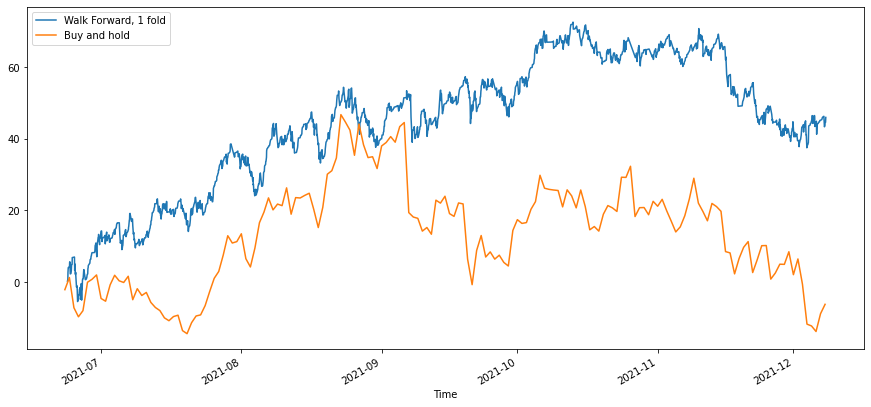

In [7]:
plt.figure(figsize=(15,7))
oos_trades[oos_trades.window.astype('int') == 1].profit.cumsum().plot(label='Walk Forward, 1 fold')
bh_days[bh_days.window.astype('int') == 1].Profit.cumsum().plot(label='Buy and hold')
plt.legend()

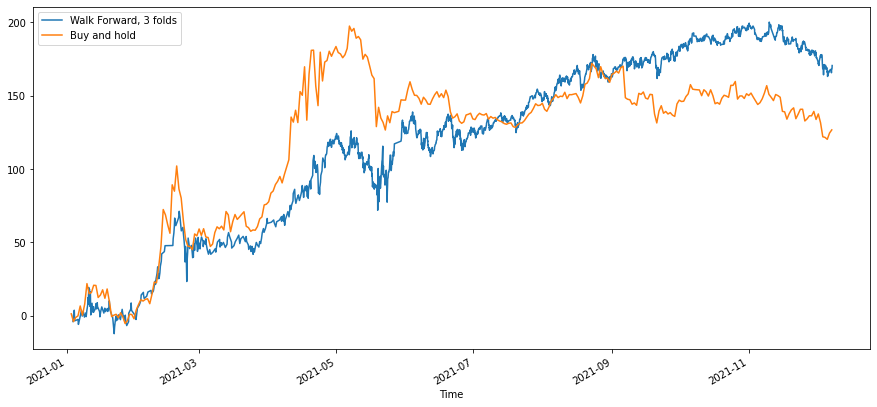

In [8]:
plt.figure(figsize=(15,7))
oos_trades[oos_trades.window.astype('int') == 3].profit.cumsum().plot(label='Walk Forward, 3 folds')
bh_days[bh_days.window.astype('int') == 3].Profit.cumsum().plot(label='Buy and hold')
plt.legend()

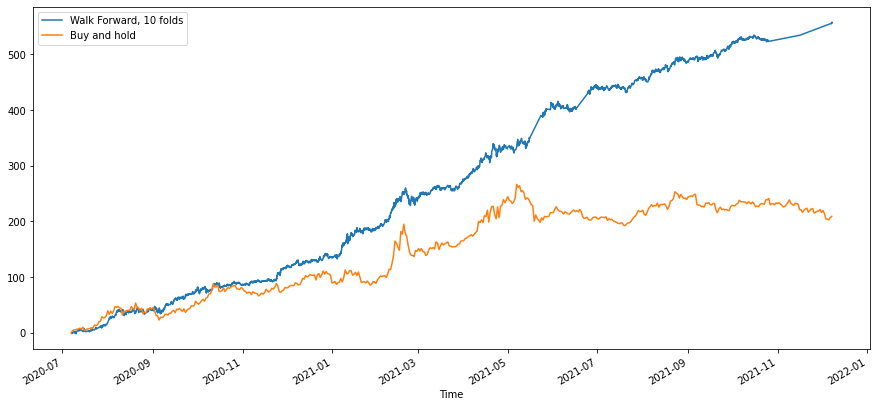

In [9]:
plt.figure(figsize=(15,7))
oos_trades[oos_trades.window.astype('int') == 10].profit.cumsum().plot(label='Walk Forward, 10 folds')
bh_days[bh_days.window.astype('int') == 10].Profit.cumsum().plot(label='Buy and hold')
plt.legend()